# Description

The notebook automates the process of pushing a pair of scenarios (baseline and alternative) through the simulation and optimization pipeline, comparing outputs for each scenario. Key outputs include harvested area (hectares), harvested volume (m³), and growth (m³). The notebook also reports stand age class distribution, old growth attributes, and tree species diversity at the beginning and end of the planning horizon for each scenario. Additionally, it calculates biodiversity and socioeconomic indicators, while quantifying differences between baseline and alternative scenarios in terms of carbon stocks and net emissions over a customizable simulation horizon, set to 100 years by default (the system can easily be parametrized to simulate shorter or longer horizons).

In [15]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, plugin_c_curves, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age

In [16]:
# Initialize the input parameters
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [17]:
# Define scenario options based on case study
scenario_options = {
    'mining_site_1': ['no_cons','evenflow_cons',  'bau_ms1', 'ms1_AAC_90%', 'ms1_AAC_80%', 'ms1_AAC_70%', 'ms1_AAC_60%', 'ms1_AAC_50%', 'ms1_AAC_40%', 'ms1_AAC_30%', 'ms1_AAC_20%', 'ms1_AAC_10%' ],
    'mining_site_2': ['no_cons', 'evenflow_cons', 'bau_ms2', 'ms2_AAC_90%', 'ms2_AAC_80%', 'ms2_AAC_70%', 'ms2_AAC_60%', 'ms2_AAC_50%', 'ms2_AAC_40%', 'ms2_AAC_30%', 'ms2_AAC_20%', 'ms2_AAC_10%'],
    'mining_site_3': [ 'no_cons','evenflow_cons', 'bau_ms3', 'ms3_AAC_90%', 'ms3_AAC_80%', 'ms3_AAC_70%', 'ms3_AAC_60%', 'ms3_AAC_50%', 'ms3_AAC_40%', 'ms3_AAC_30%', 'ms3_AAC_20%', 'ms3_AAC_10%']
}

# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value

# Case study dropdown
case_study_dropdown = widgets.Dropdown(
    options=['mining_site_1', 'mining_site_2', 'mining_site_3'],
    value='mining_site_3',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['mining_site_3'],  # Set initial options based on default case study
    value=scenario_options['mining_site_3'][0],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='max_hv',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', index=2, options=('mining_site_1', 'mining_site_2', 'mining_site_3'), valu…

Dropdown(description='Scenario:', options=('no_cons', 'evenflow_cons', 'bau_ms3', 'ms3_AAC_90%', 'ms3_AAC_80%'…

Dropdown(description='Objective:', options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='max_hv')

In [18]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=1, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=1, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [19]:
#Start Calculating the Running Time
Start = time.time()

In [20]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [21]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'mining_site_1': {
        'model_name': 'mining_site_1',
        'model_path': './data/woodstock_model_files_mining_site_1'
    },
    'mining_site_2': {
        'model_name': 'mining_site_2',
        'model_path': './data/woodstock_model_files_mining_site_2'
    },
    'mining_site_3': {
        'model_name': 'mining_site_3',
        'model_path': './data/woodstock_model_files_mining_site_3'
    },
    'test': {
        'model_name': 'mining_site_3',
        'model_path': './data/woodstock_model_files_mining_site_3_test'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [22]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [23]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [24]:
# Read carbon curves
file_directory = "./data/curves"
file_names = [f"{case_study}_c_curves_p.pkl", f"{case_study}_c_curves_f.pkl"]
loaded_data = {}

for filename in file_names:
    file_path = os.path.join(file_directory, filename)
    with open(file_path, 'rb') as file:
        loaded_data[filename] = pickle.load(file)
    print(f"Loaded data from {file_path}")

c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

Loaded data from ./data/curves/mining_site_3_c_curves_p.pkl
Loaded data from ./data/curves/mining_site_3_c_curves_f.pkl


In [25]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

Running for mining_site_3_max_hv_no_cons...
running no_cons scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3667 rows, 34533 columns and 34533 nonzeros
Model fingerprint: 0x38763cd3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3667 rows and 34533 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0063889e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.01 work units)
Optimal objective  3.006388928e+07


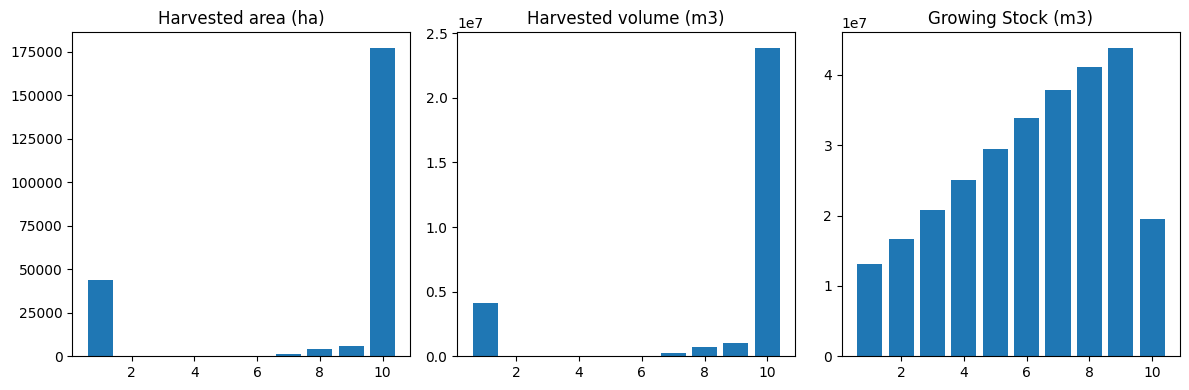

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_no_cons_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  31783
The economic indicator (the provincial government revenues) is:  1083897
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


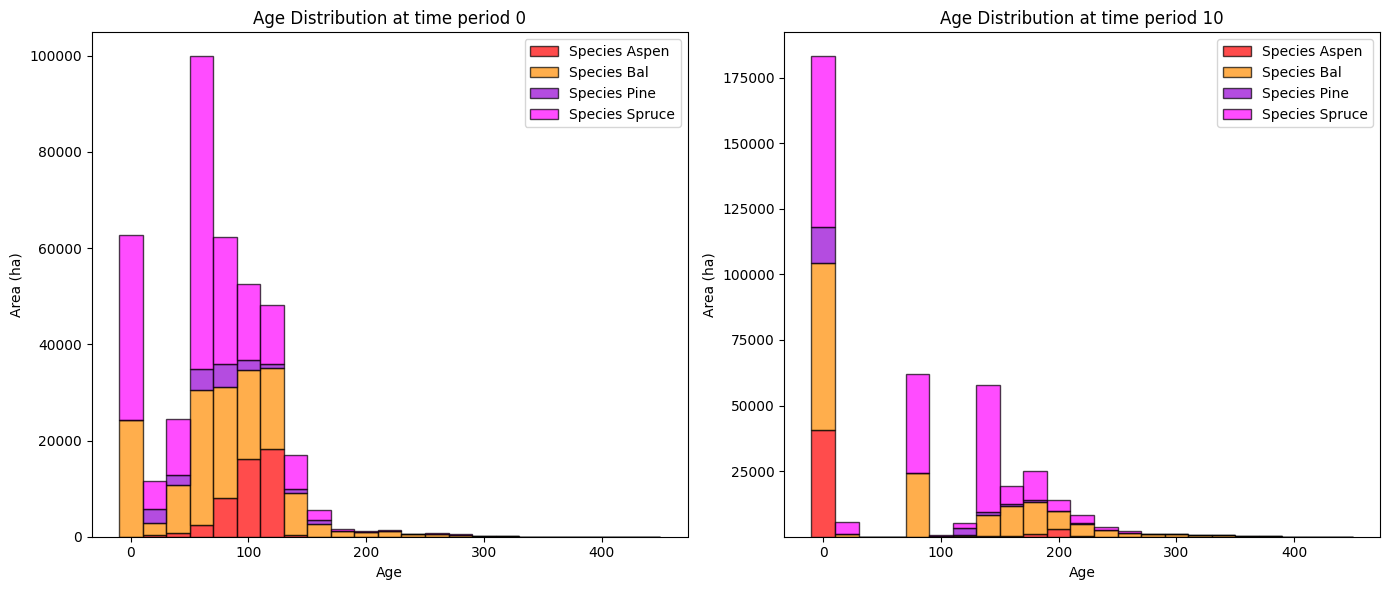

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_no_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   4909.785142   3964.471454
Pine     602.782616   1505.321386    902.538770
Bal     4315.588546  27951.218565  23635.630019
Spruce  1072.814408  12878.635366  11805.820959

Old growth has **increased** by 40308.46 hectares from time period 0 to time period 10.


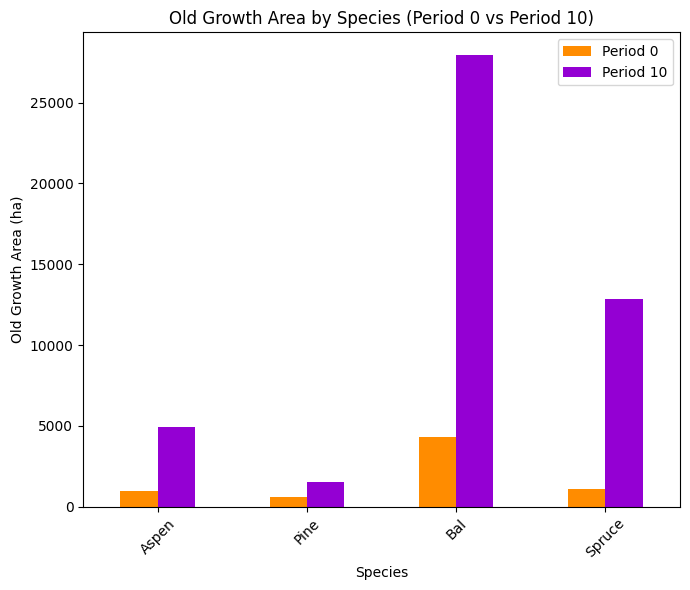

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_no_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.6880

Diversity has **decreased** by 19.68% from time 0 to time 10.


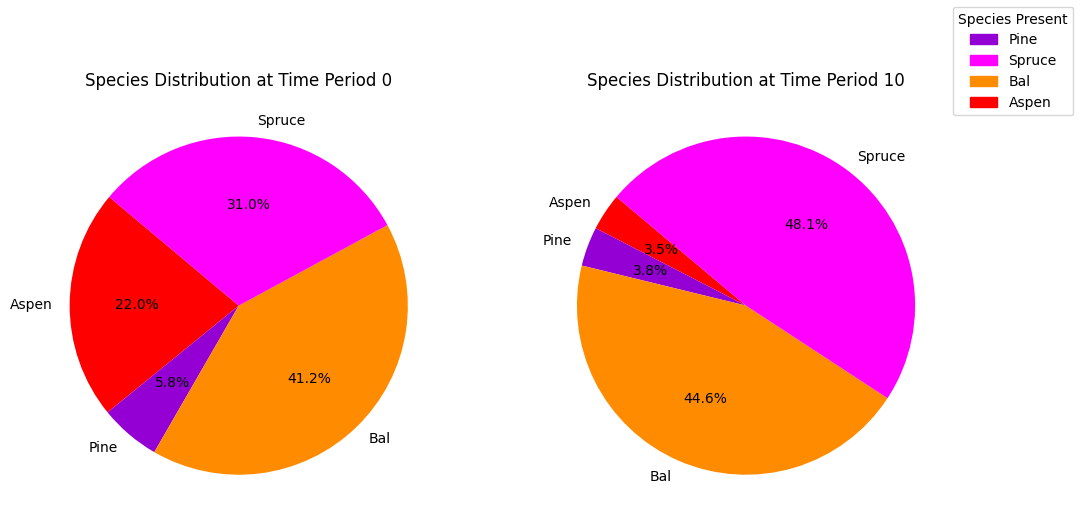

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_no_cons_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.12s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

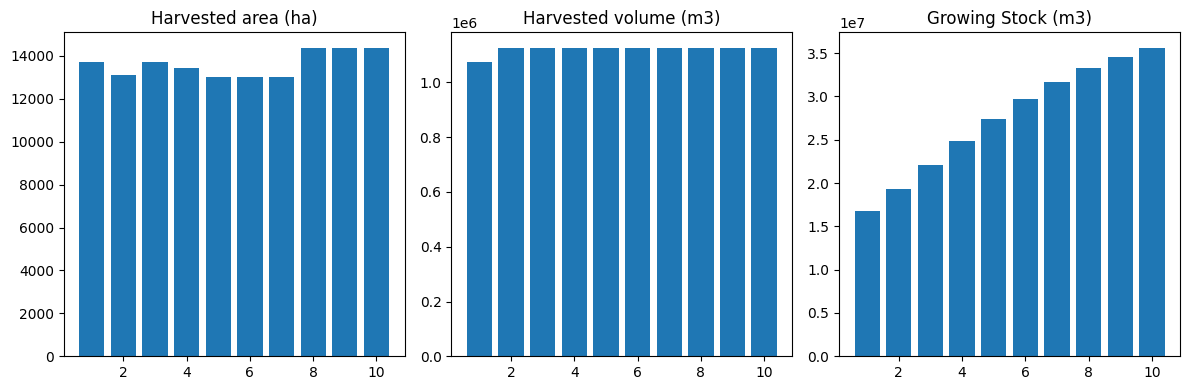

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


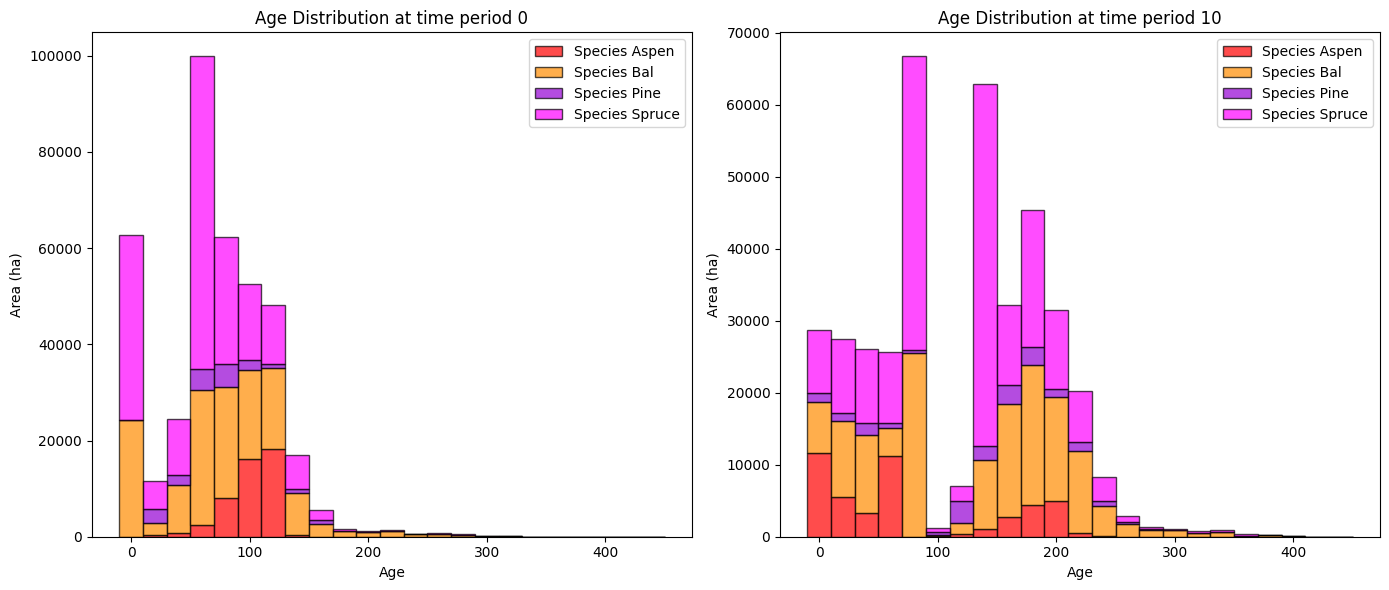

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


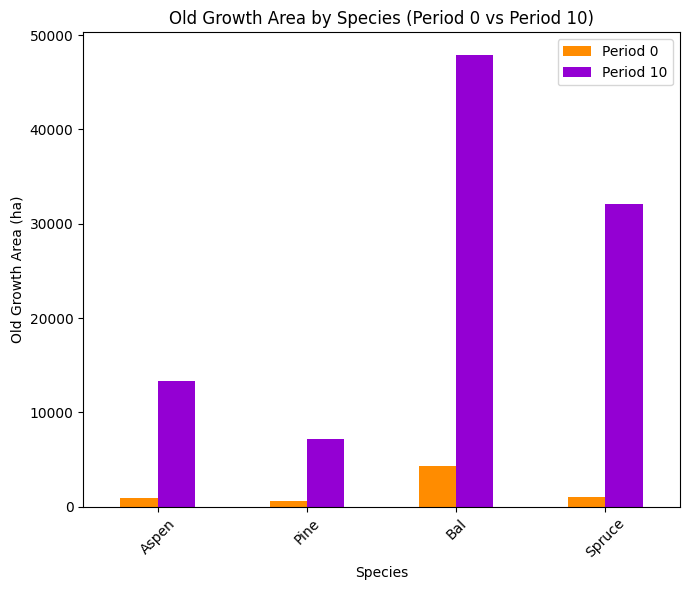

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


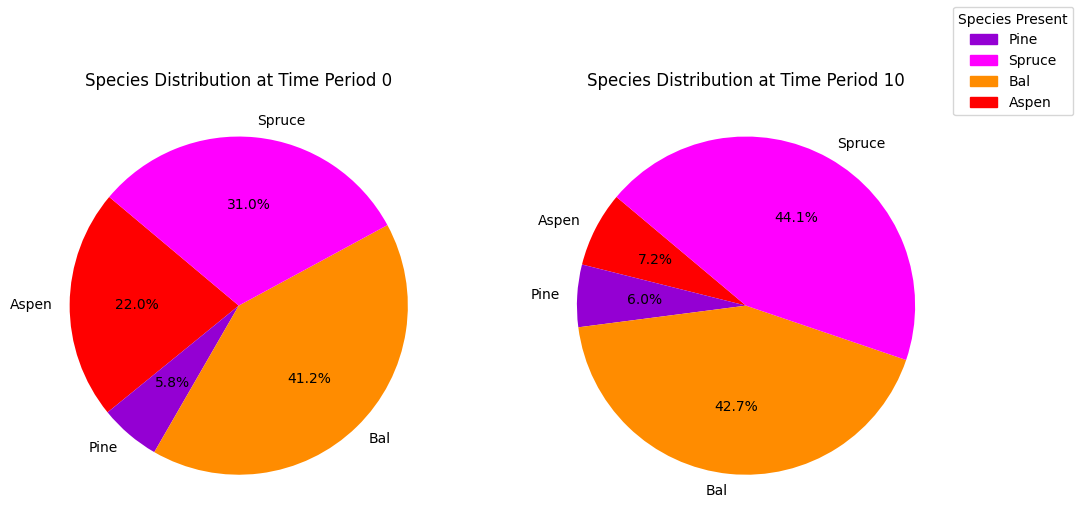

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


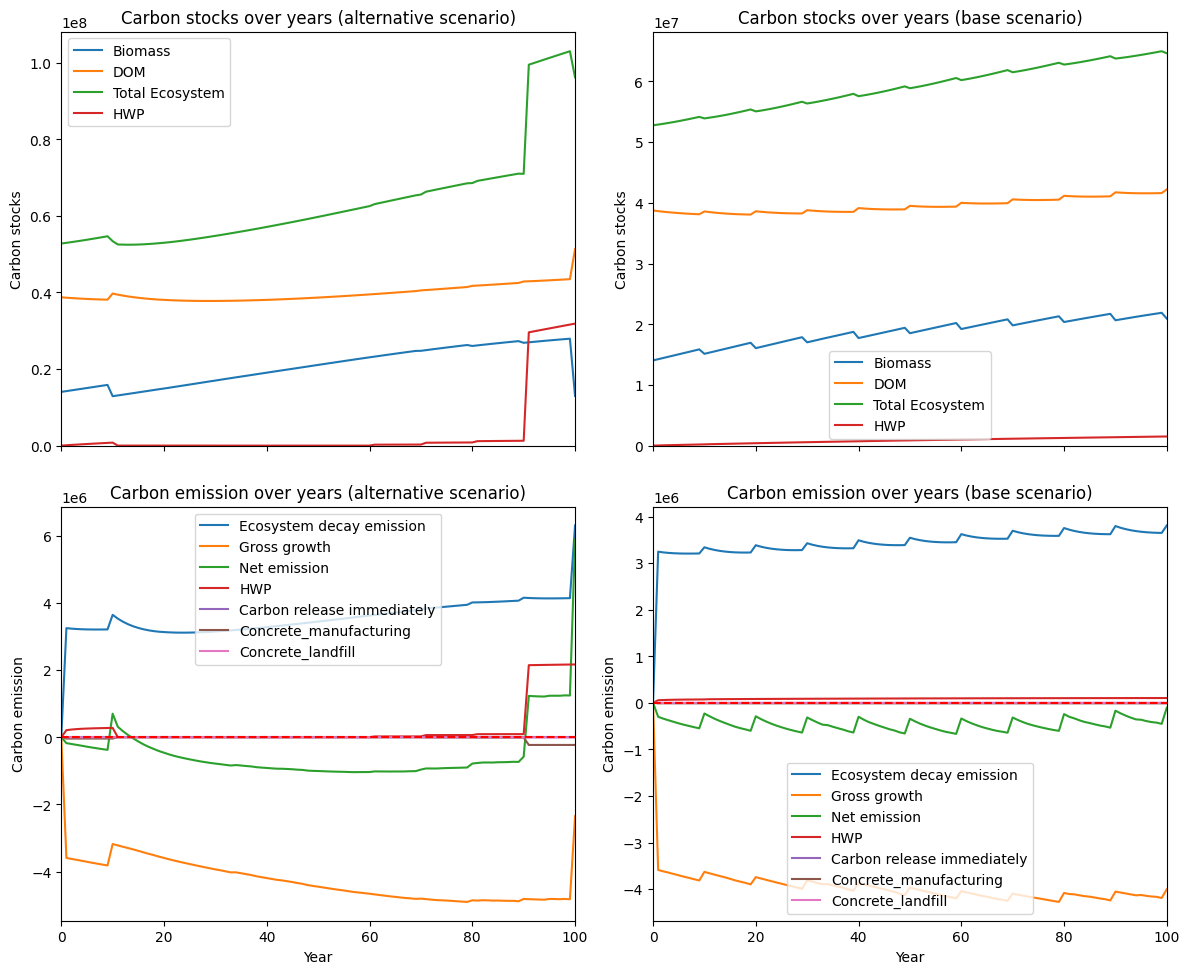

---------------------------------------------------------------------------------------
Net emission difference -1665406.6879790714
Net emission base scenario -46083355.39637767
Net emission alternative scenario -47748762.08435674
dollar_per_ton is:  6.004539354969653
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  -8377.198989  -8377.198989
Pine    0.0  -5675.665026  -5675.665026
Bal     0.0 -19941.541760 -19941.541760
Spruce  0.0 -19162.296554 -19162.296554

Overall, the old growth area has **decreased** by -53156.70 hectares in the alternative scenario compared to the base scenario.


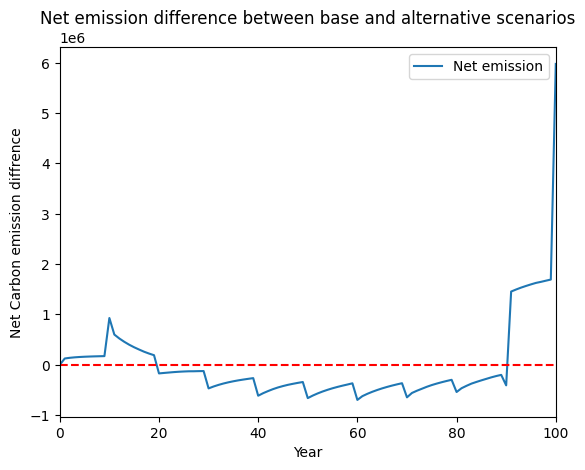

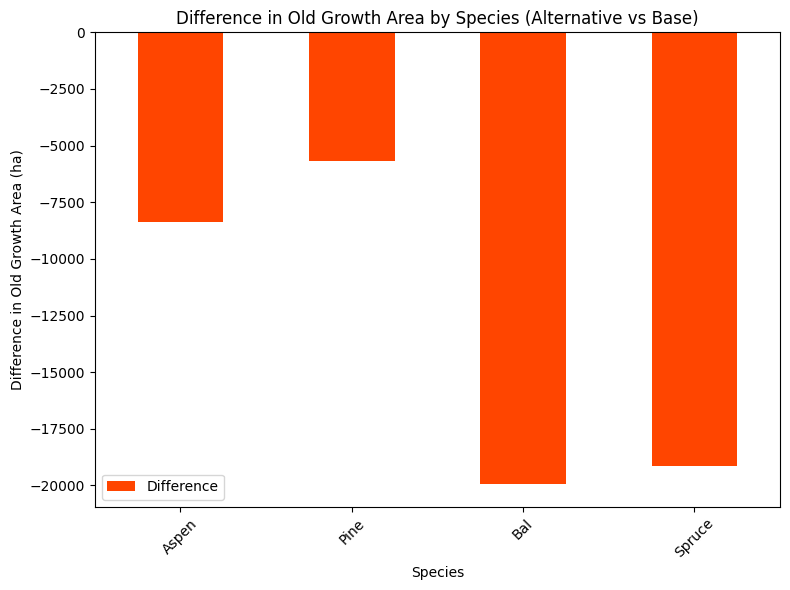

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


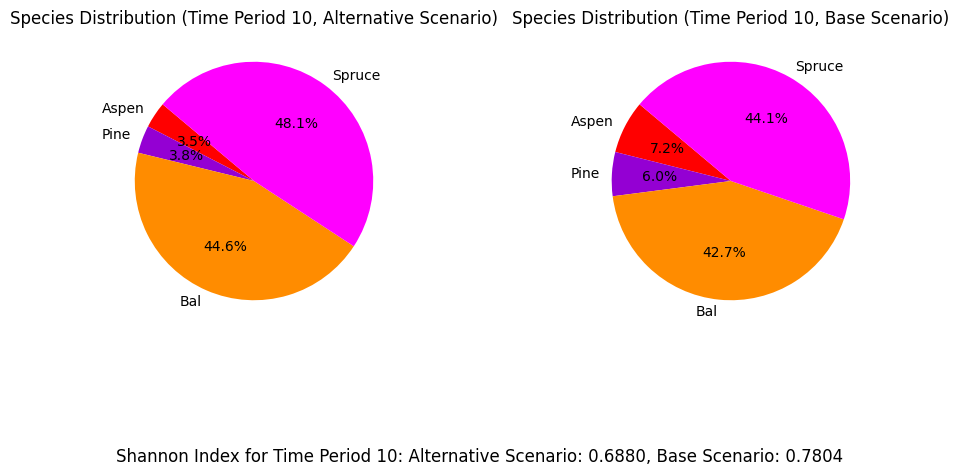

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 6.0 minutes to run all scenarios.


In [26]:
# Run only selected scenario
Start = time.time()
print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
results_scenarios(fm, 
                  clt_percentage, 
                  credibility, 
                  budget_input, 
                  n_steps, 
                  max_harvest, 
                  scenario_name, 
                  displacement_effect, 
                  hwp_pool_effect_value, 
                  release_immediately_value, 
                  case_study, 
                  obj_mode,                   
                  pickle_output_base=False, 
                  pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

Running for mining_site_3_max_hv_no_cons...
running no_cons scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-17
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3667 rows, 34533 columns and 34533 nonzeros
Model fingerprint: 0x38763cd3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3667 rows and 34533 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0063889e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds (0.01 work units)
Optimal objective  3.006388928e+07


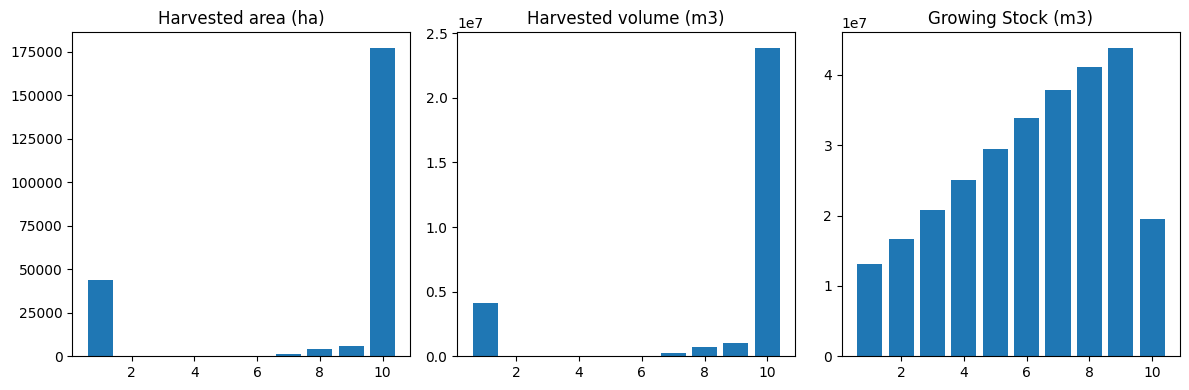

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_no_cons_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  31783
The economic indicator (the provincial government revenues) is:  1083897
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


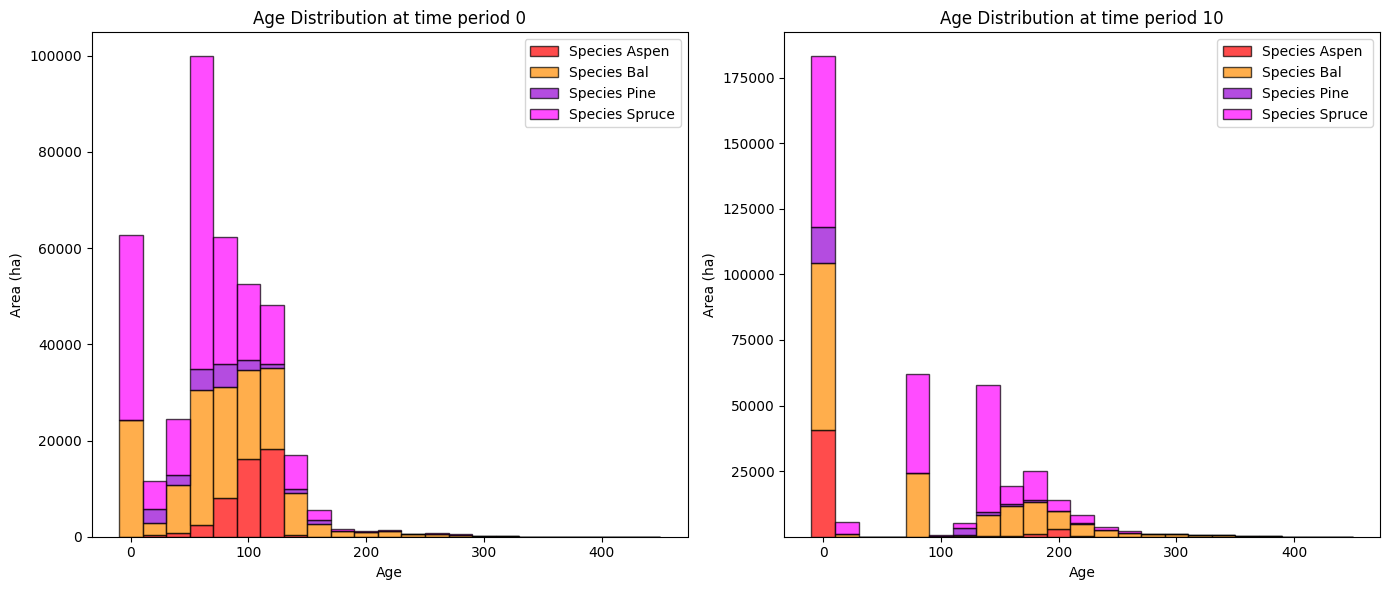

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_no_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   4909.785142   3964.471454
Pine     602.782616   1505.321386    902.538770
Bal     4315.588546  27951.218565  23635.630019
Spruce  1072.814408  12878.635366  11805.820959

Old growth has **increased** by 40308.46 hectares from time period 0 to time period 10.


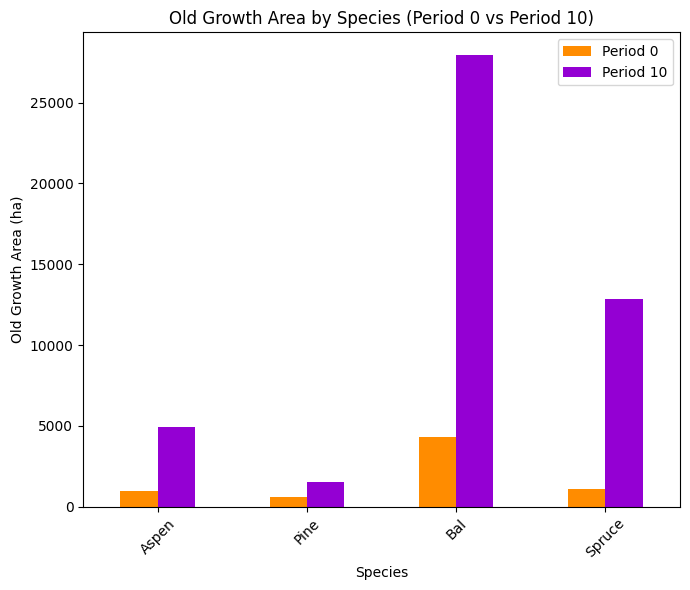

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_no_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.6880

Diversity has **decreased** by 19.68% from time 0 to time 10.


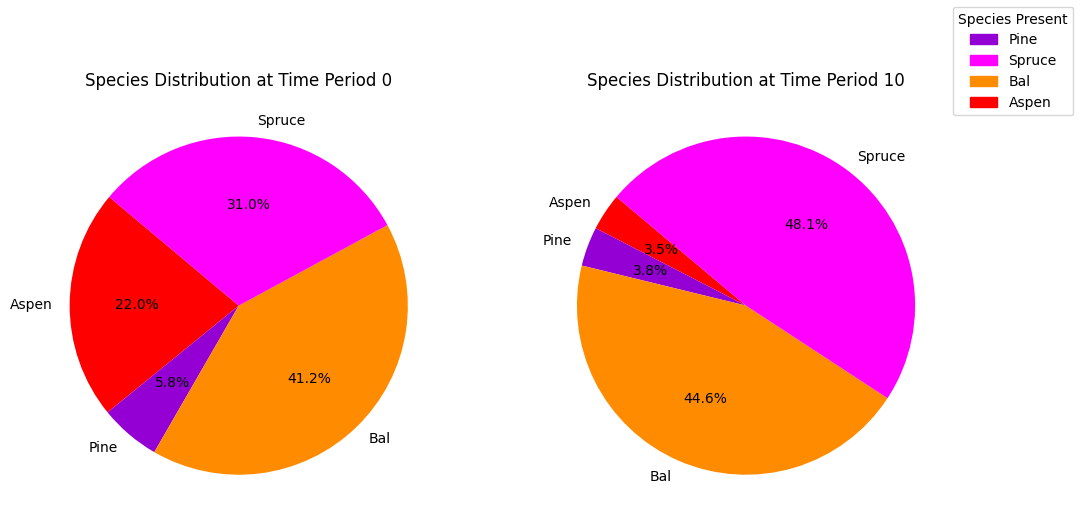

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_no_cons_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.13s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

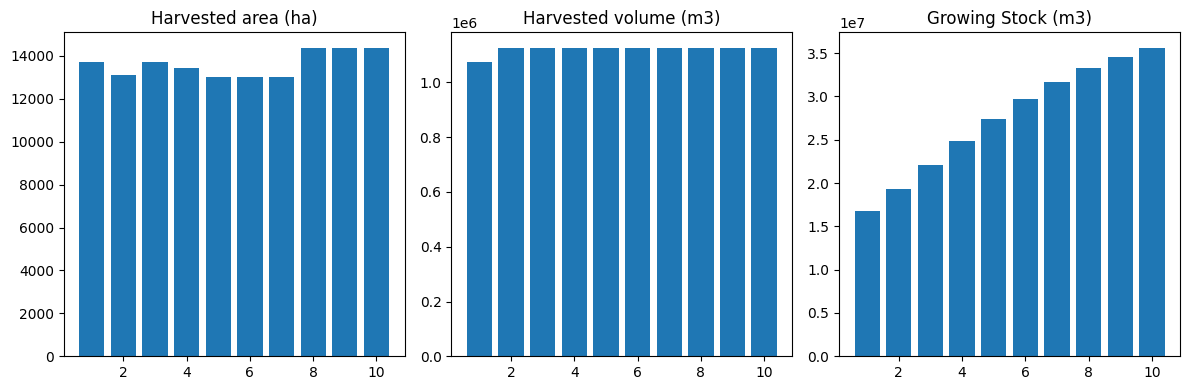

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


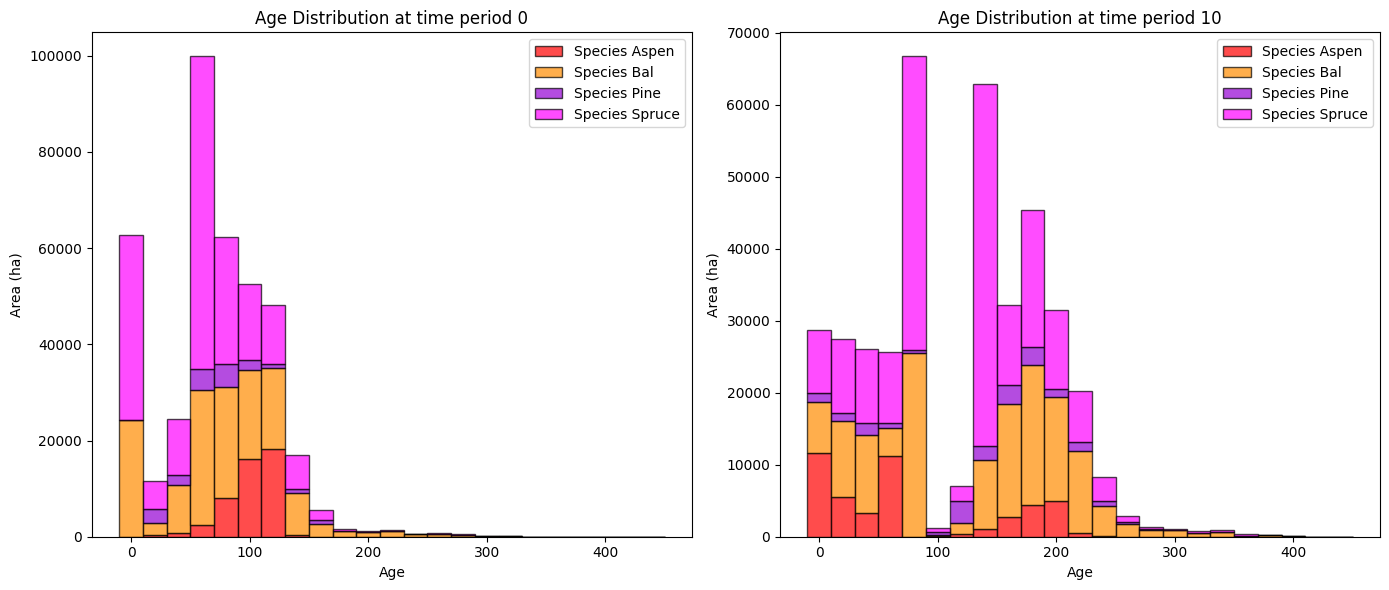

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


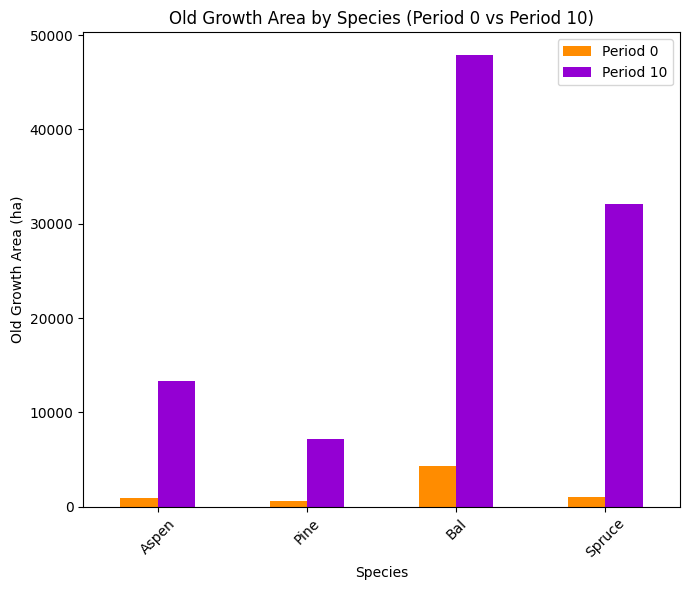

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


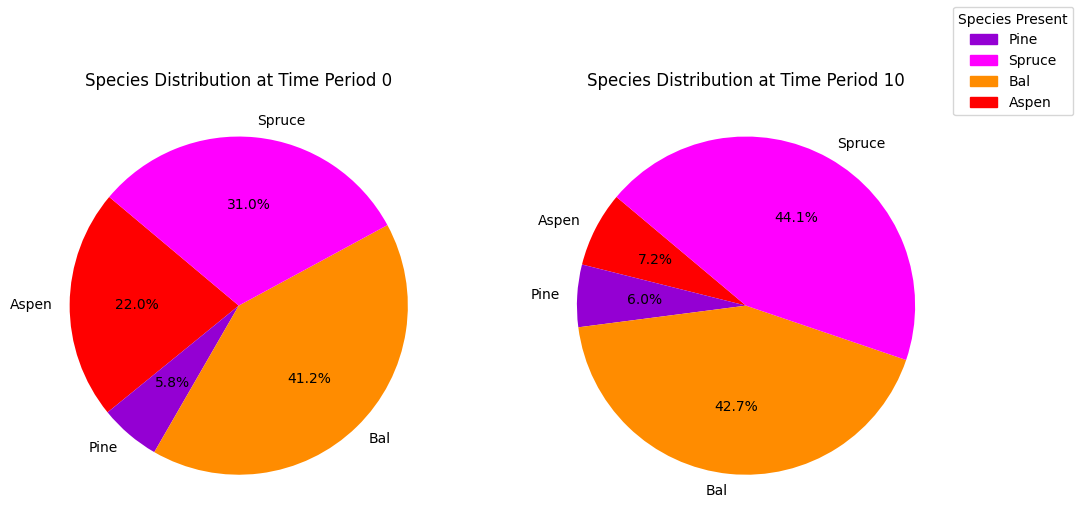

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


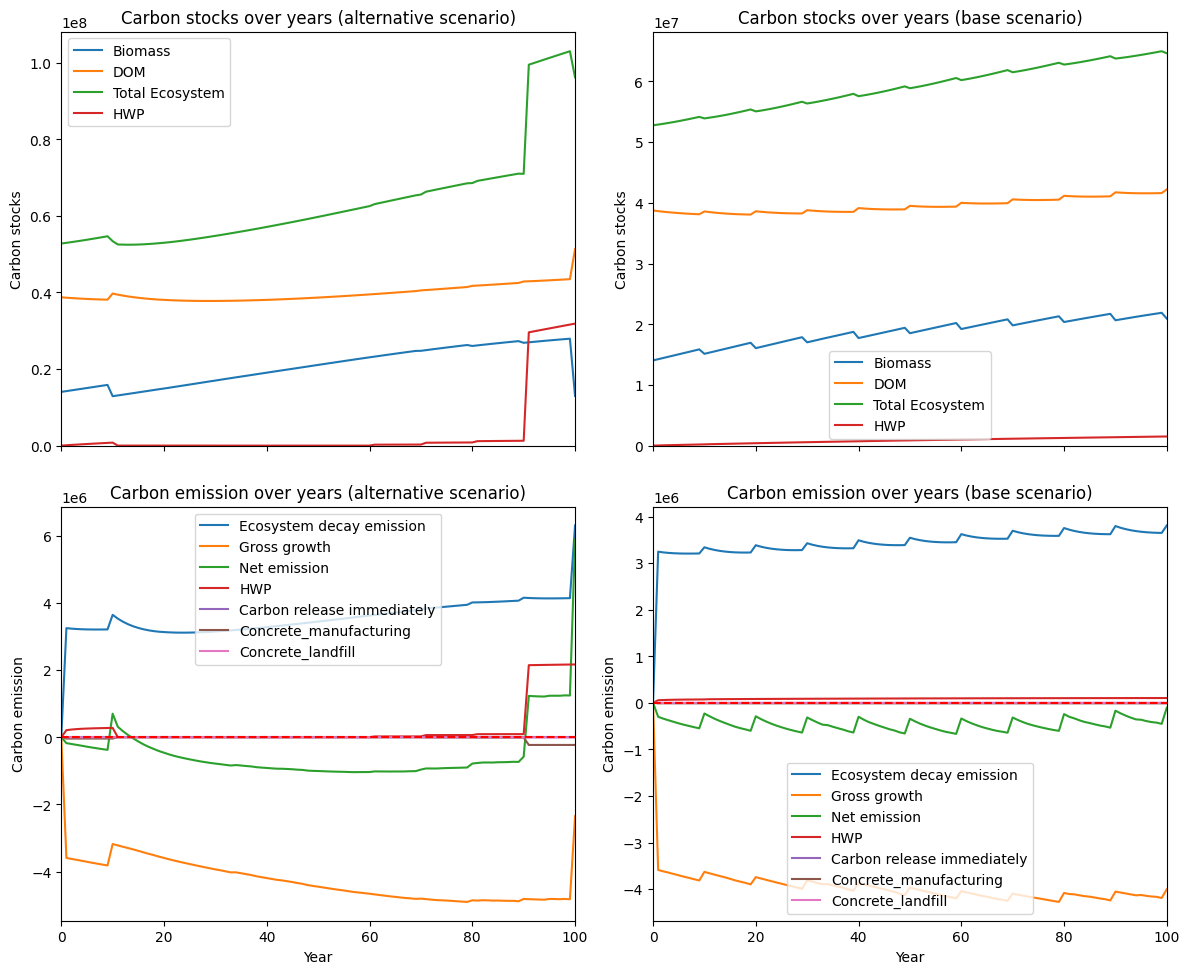

---------------------------------------------------------------------------------------
Net emission difference -1665406.6879790714
Net emission base scenario -46083355.39637767
Net emission alternative scenario -47748762.08435674
dollar_per_ton is:  6.004539354969653
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  -8377.198989  -8377.198989
Pine    0.0  -5675.665026  -5675.665026
Bal     0.0 -19941.541760 -19941.541760
Spruce  0.0 -19162.296554 -19162.296554

Overall, the old growth area has **decreased** by -53156.70 hectares in the alternative scenario compared to the base scenario.


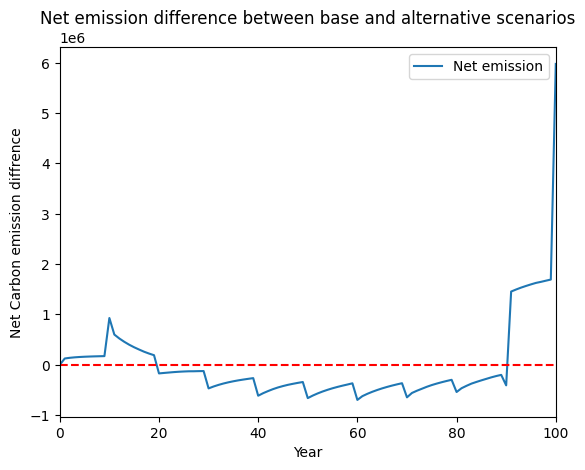

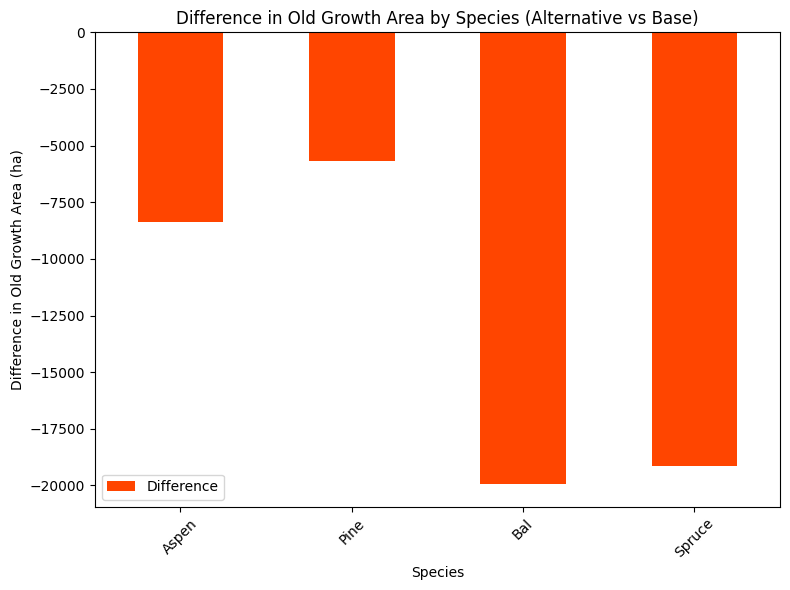

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


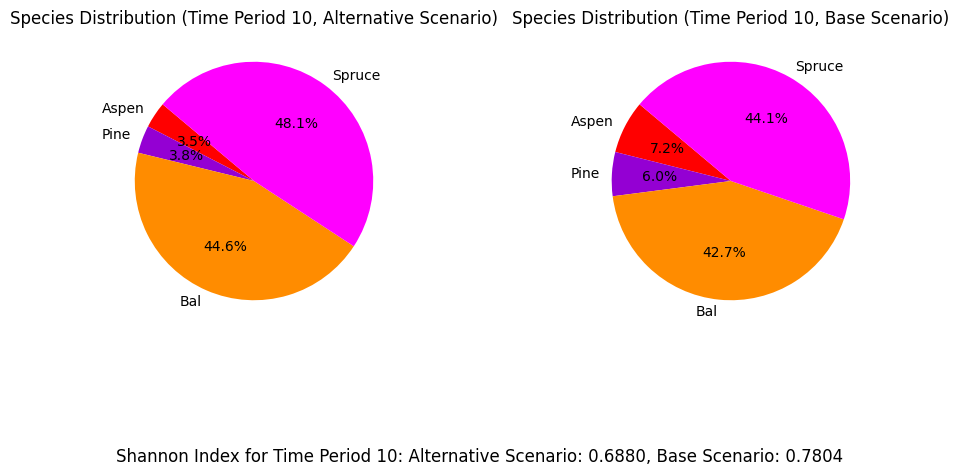

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for mining_site_3_max_hv_evenflow_cons...
running even flow constraints scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3707 rows, 34533 columns and 445161 nonzeros
Model fingerprint: 0x5ba631eb
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2009 rows and 3667 columns
Presolve time: 0.09s
Presolved: 1698 rows, 30866 columns, 413674 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

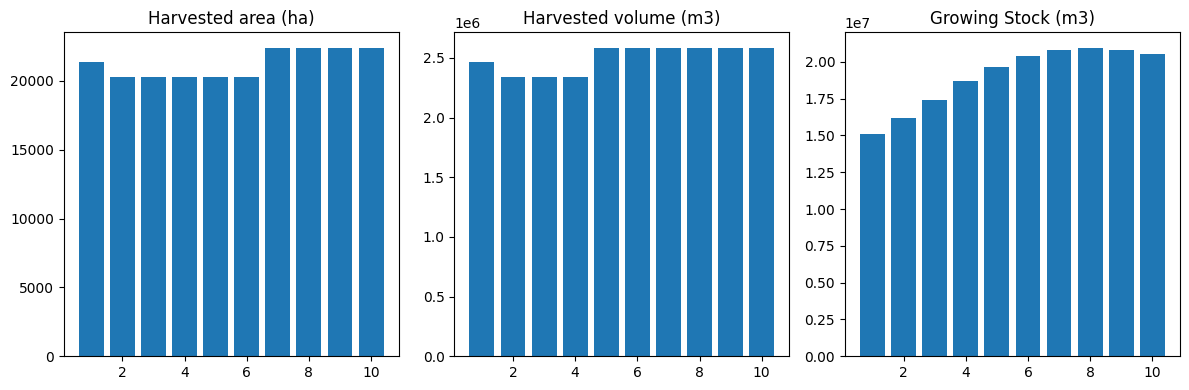

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_evenflow_cons_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  26423
The economic indicator (the provincial government revenues) is:  901104
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


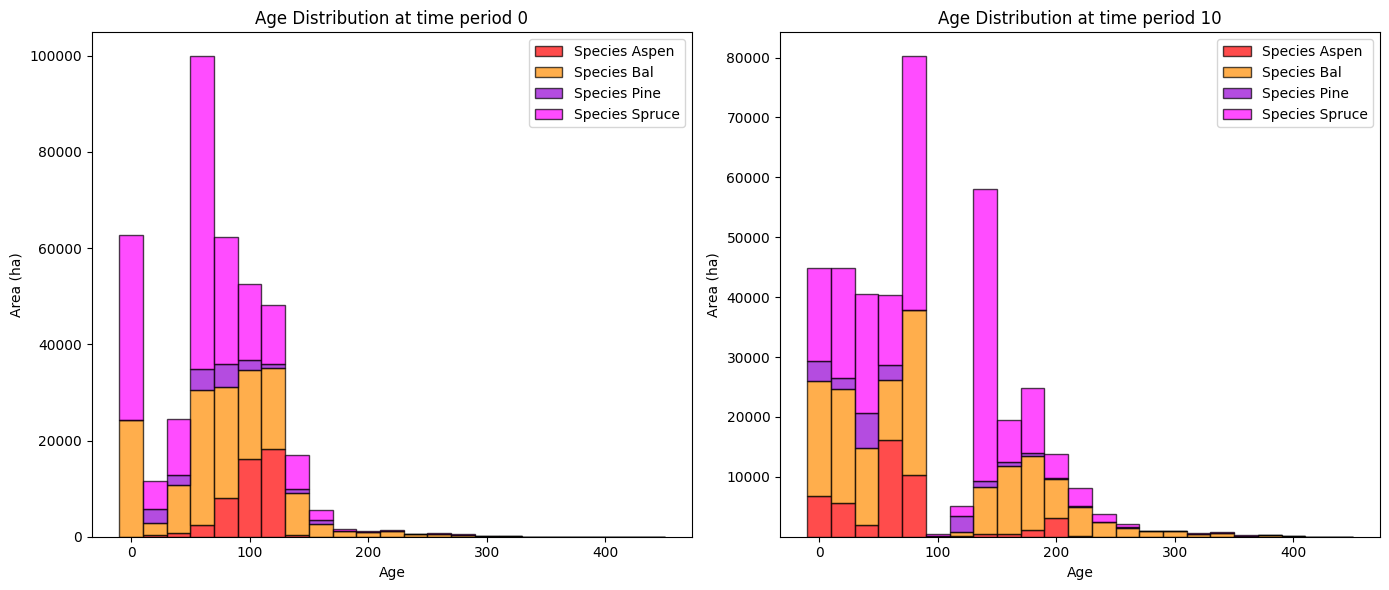

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_evenflow_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   4909.785142   3964.471454
Pine     602.782616   1505.321386    902.538770
Bal     4315.588546  27951.218565  23635.630019
Spruce  1072.814408  12878.635366  11805.820959

Old growth has **increased** by 40308.46 hectares from time period 0 to time period 10.


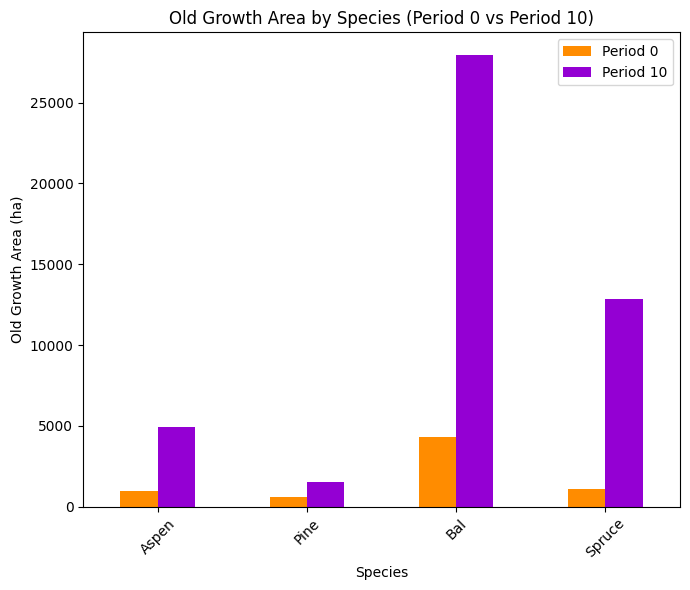

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_evenflow_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7300

Diversity has **decreased** by 15.48% from time 0 to time 10.


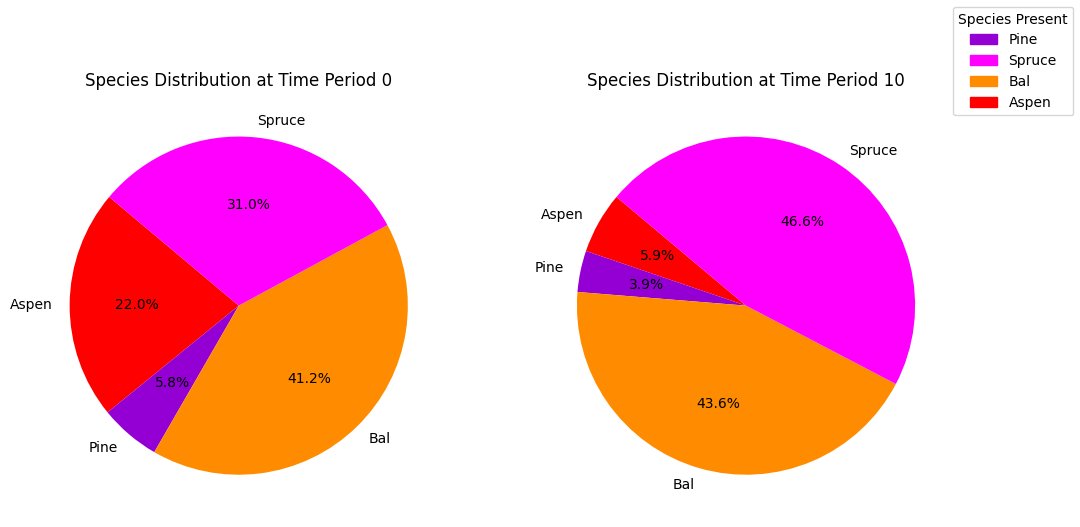

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_evenflow_cons_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.12s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

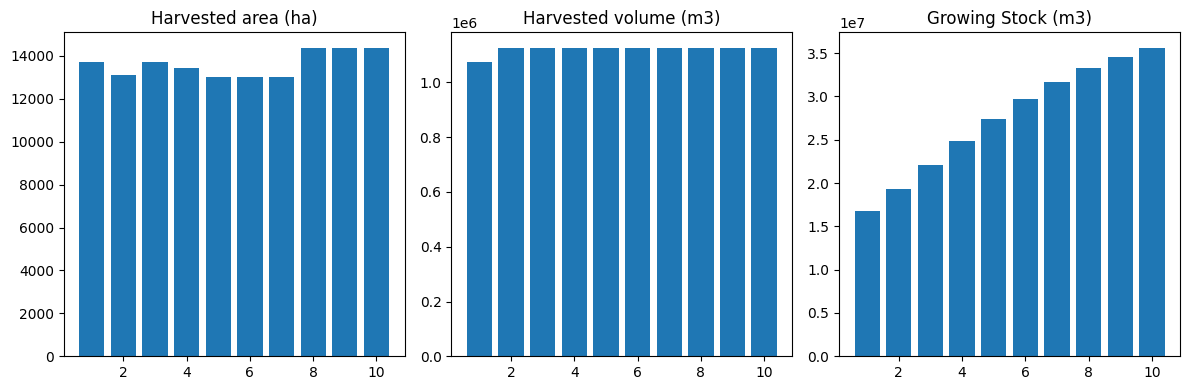

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


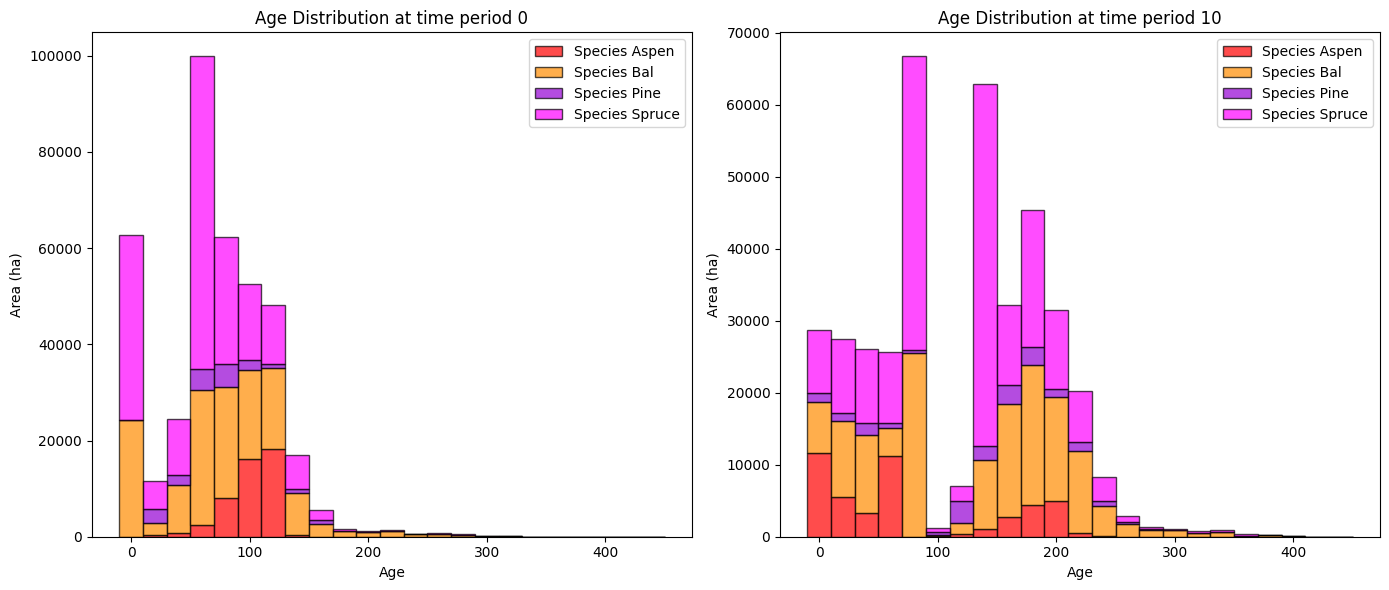

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


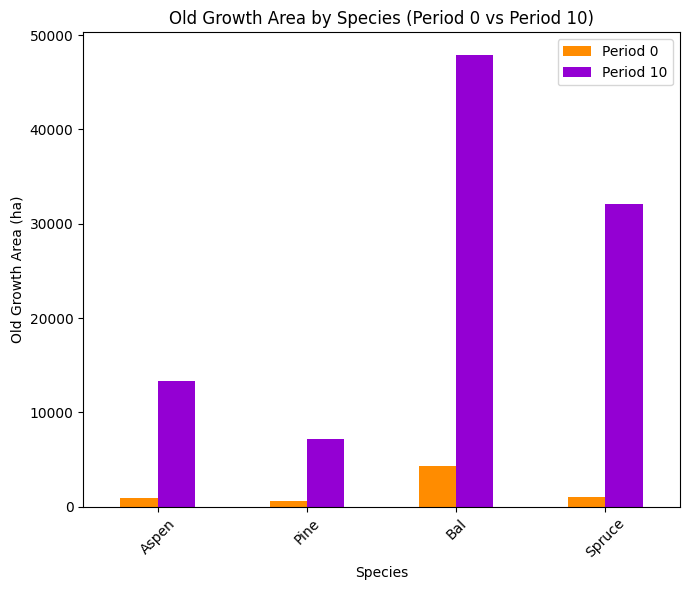

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


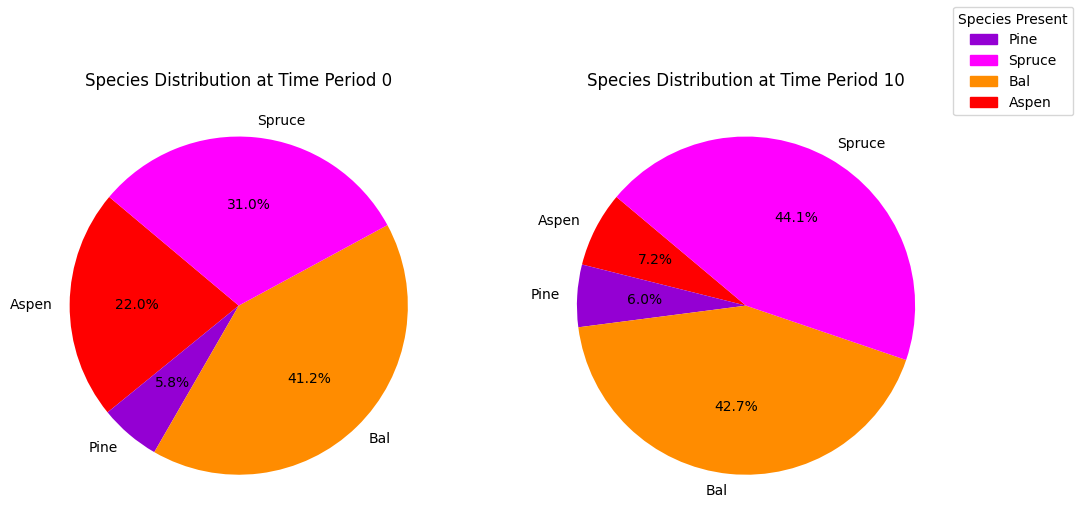

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


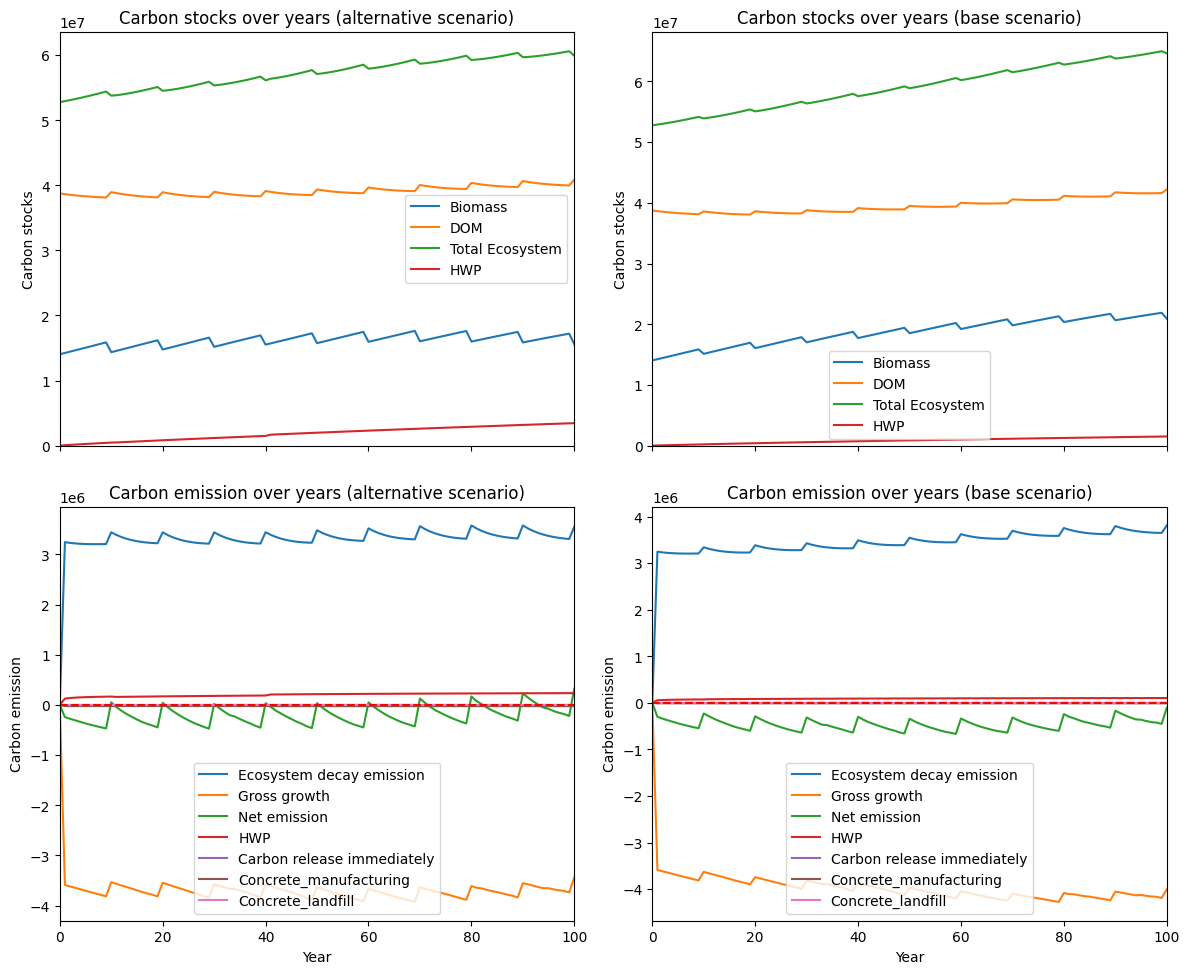

---------------------------------------------------------------------------------------
Net emission difference 25529533.146460894
Net emission base scenario -46083355.39637767
Net emission alternative scenario -20553822.249916766
dollar_per_ton is:  0.3917032067382822
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  -8377.198989  -8377.198989
Pine    0.0  -5675.665026  -5675.665026
Bal     0.0 -19941.541760 -19941.541760
Spruce  0.0 -19162.296554 -19162.296554

Overall, the old growth area has **decreased** by -53156.70 hectares in the alternative scenario compared to the base scenario.


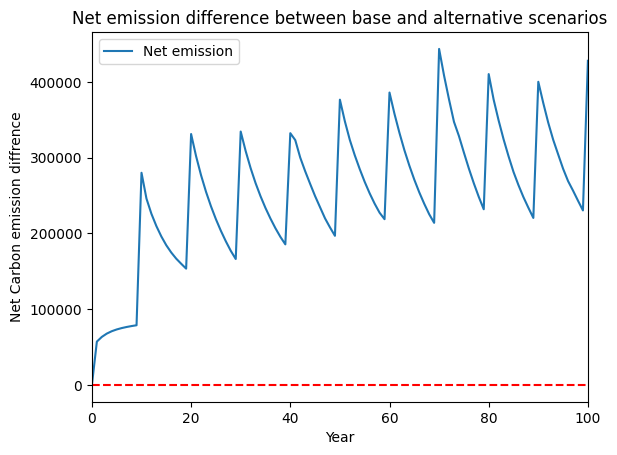

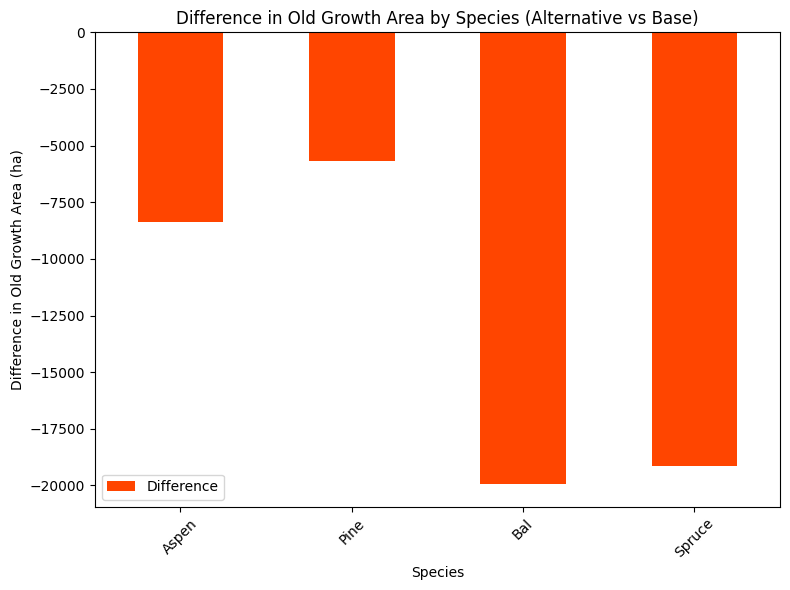

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


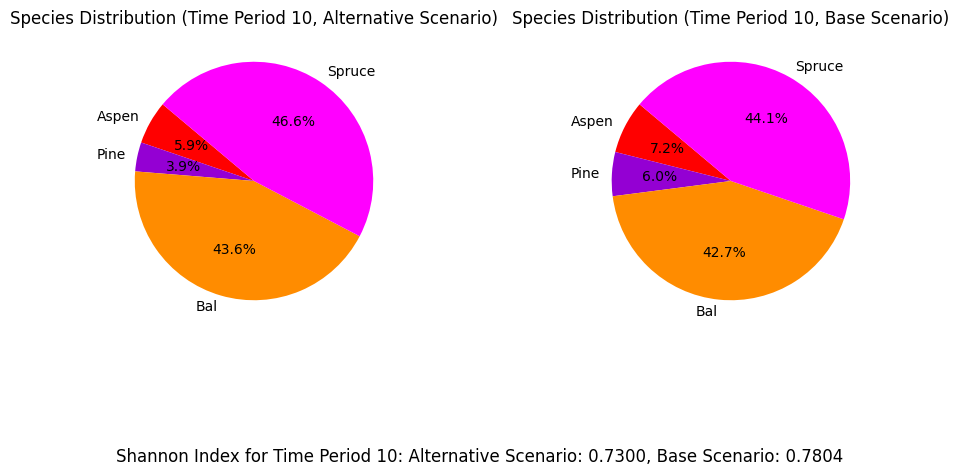

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for mining_site_3_max_hv_bau_ms3...
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.18s
Presolved: 1699 rows, 30866 col

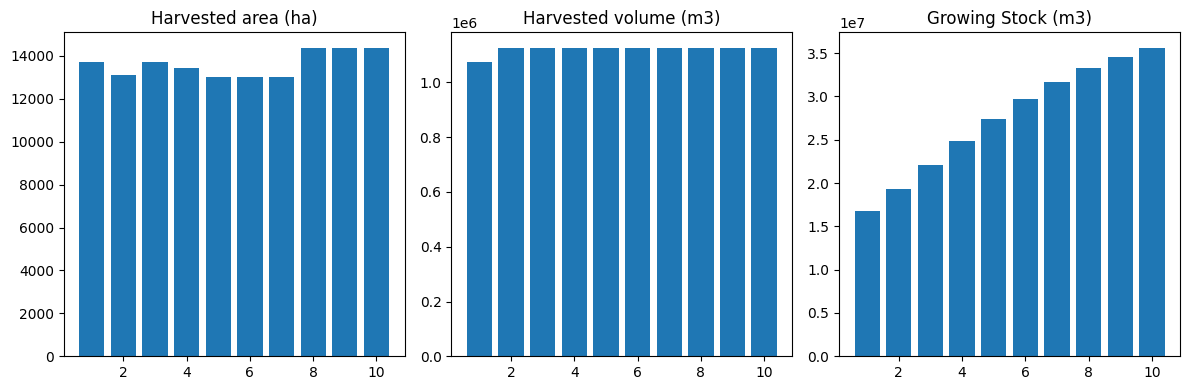

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


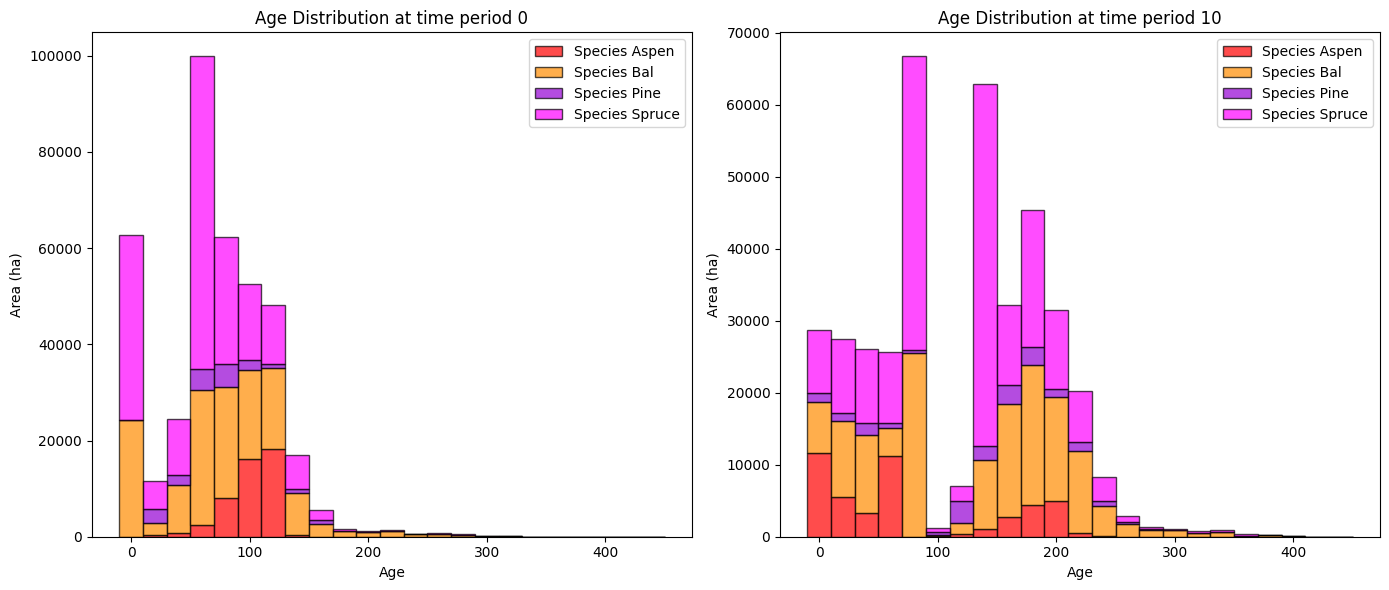

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


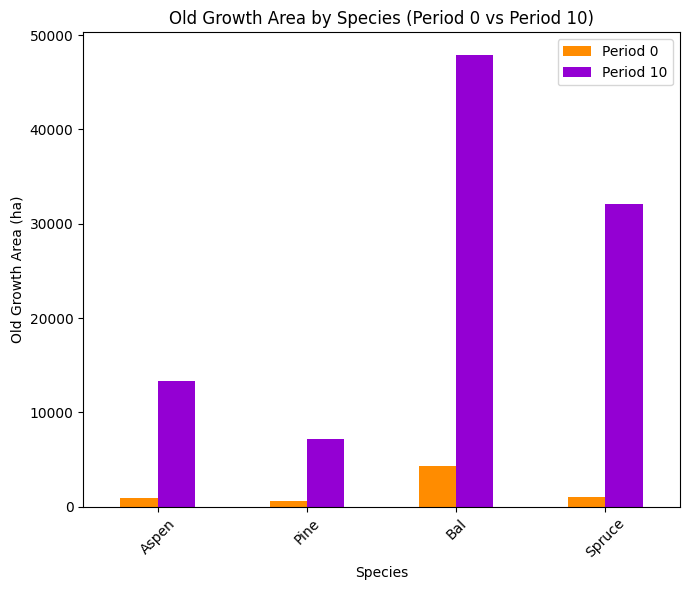

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


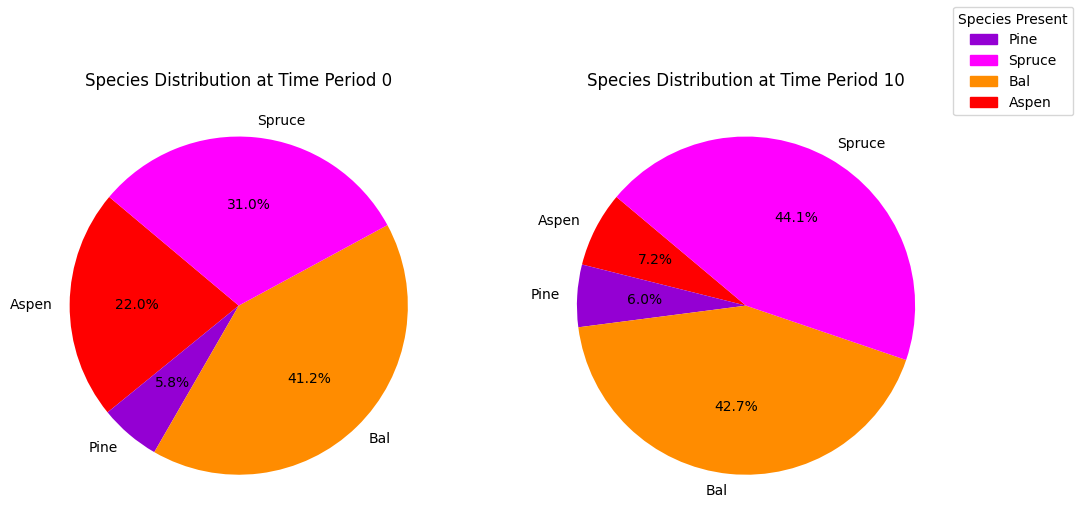

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.12s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

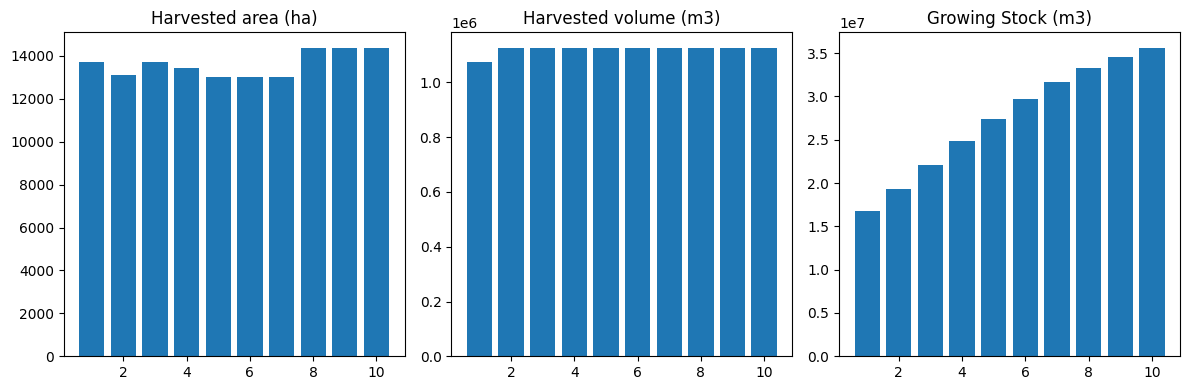

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


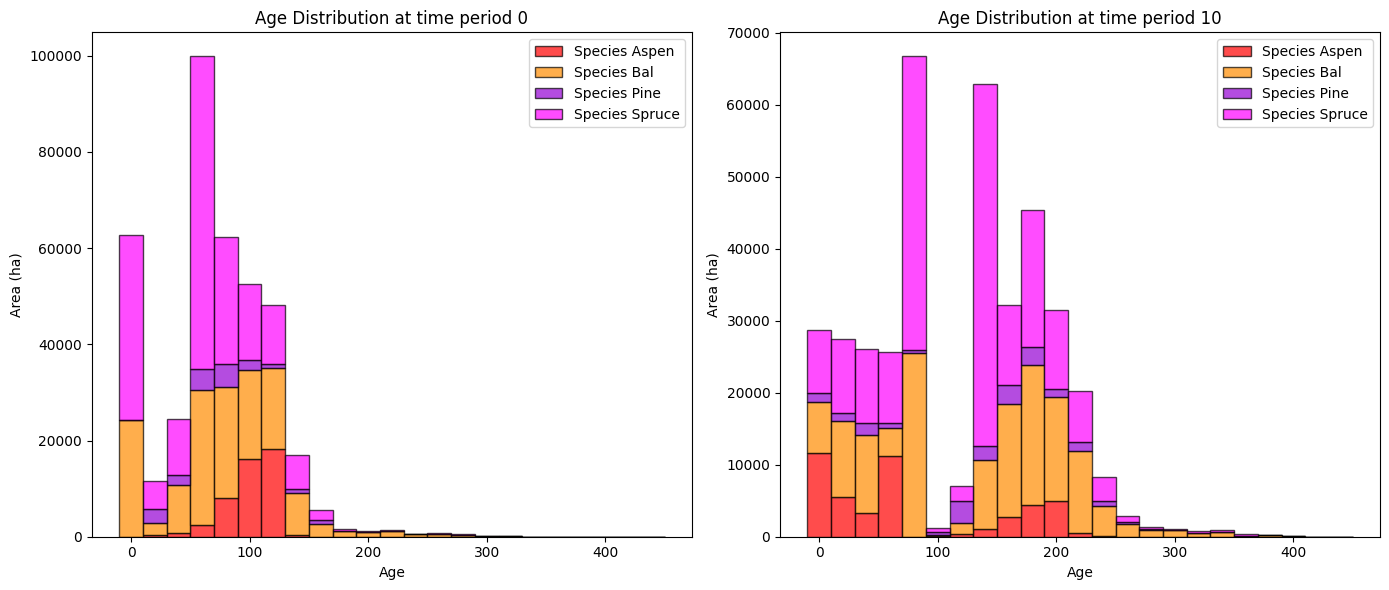

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


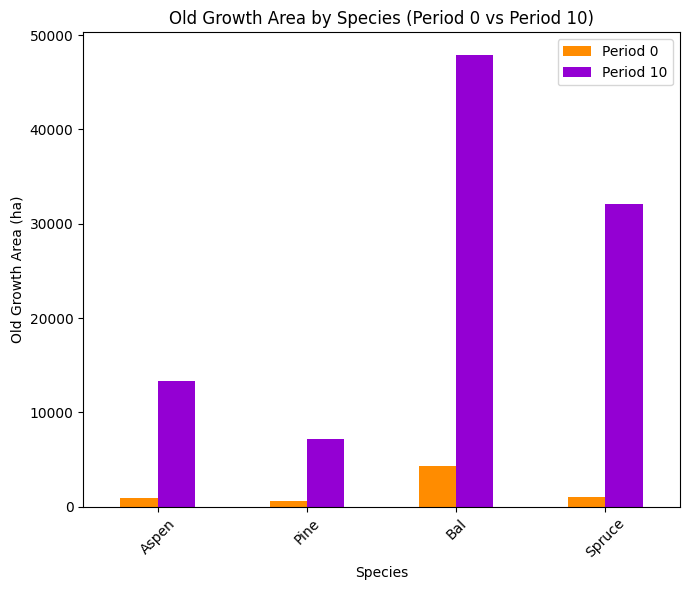

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


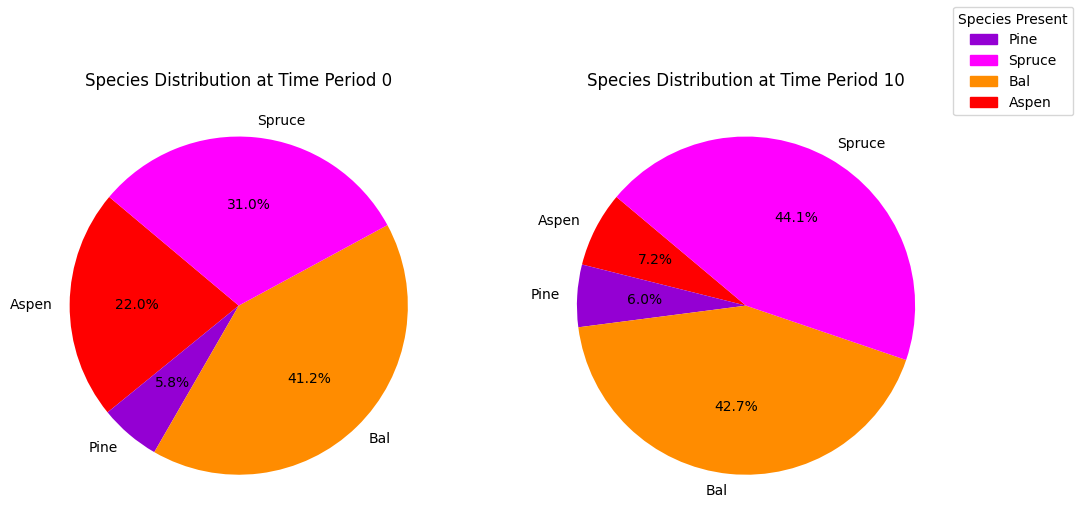

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


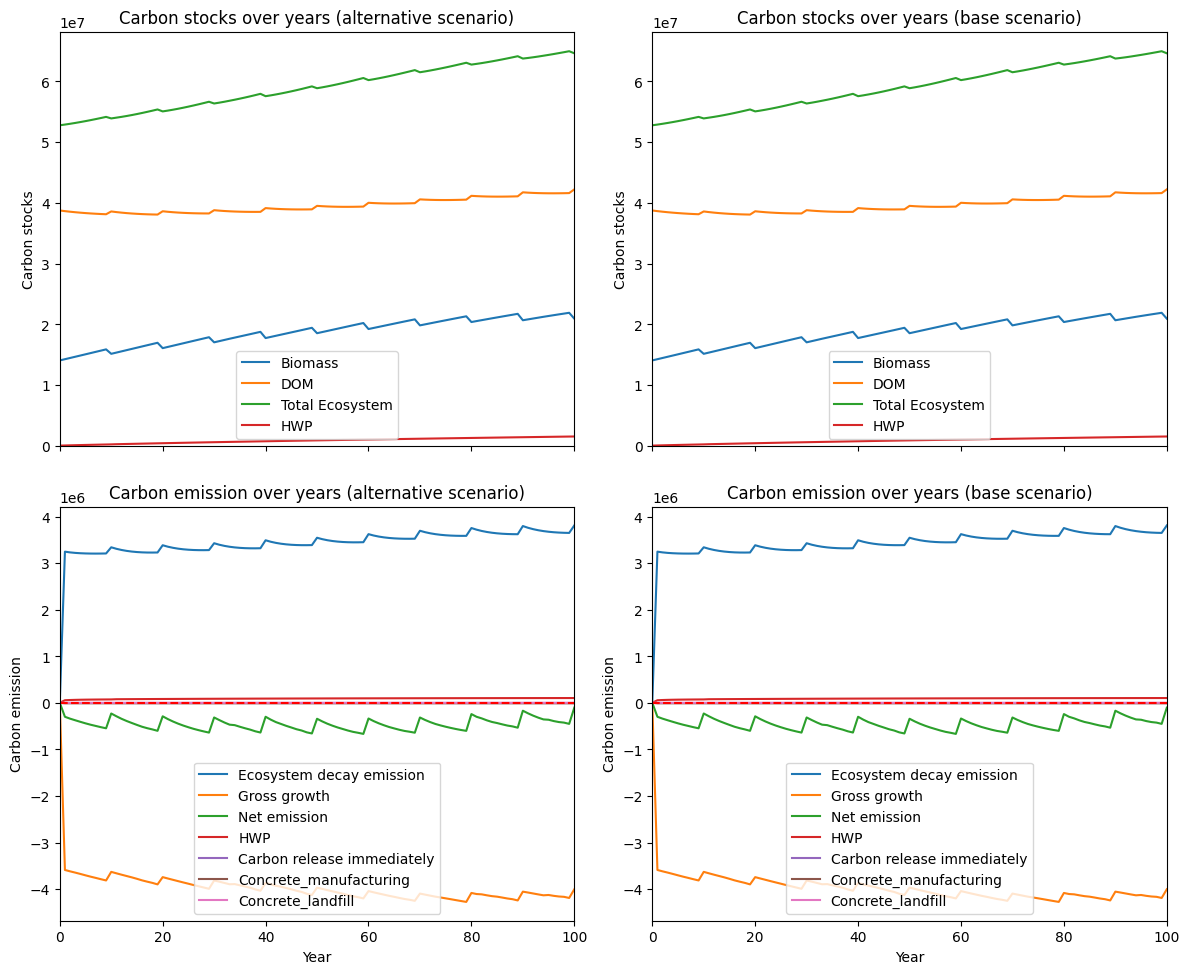

---------------------------------------------------------------------------------------
Net emission difference 0.0
Net emission base scenario -46083355.39637767
Net emission alternative scenario -46083355.39637767
dollar_per_ton is:  inf
Comparison of Old Growth Areas (Alternative - Base)
          0   10  Difference
Aspen   0.0  0.0         0.0
Pine    0.0  0.0         0.0
Bal     0.0  0.0         0.0
Spruce  0.0  0.0         0.0

Overall, the old growth area has **increased** by 0.00 hectares in the alternative scenario compared to the base scenario.


/media/data/project/eghasemi/nbds_dss/util.py:1217: RuntimeWarning: divide by zero encountered in scalar divide
  dollar_per_ton = abs(budget_input / dif_scenario['Net emission'].sum()) # Calculate for the next 25 years


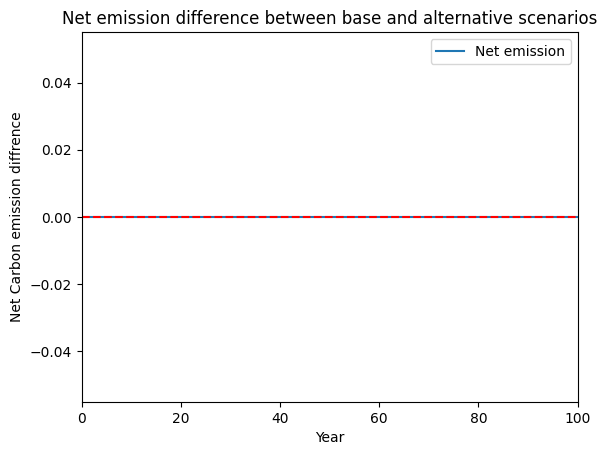

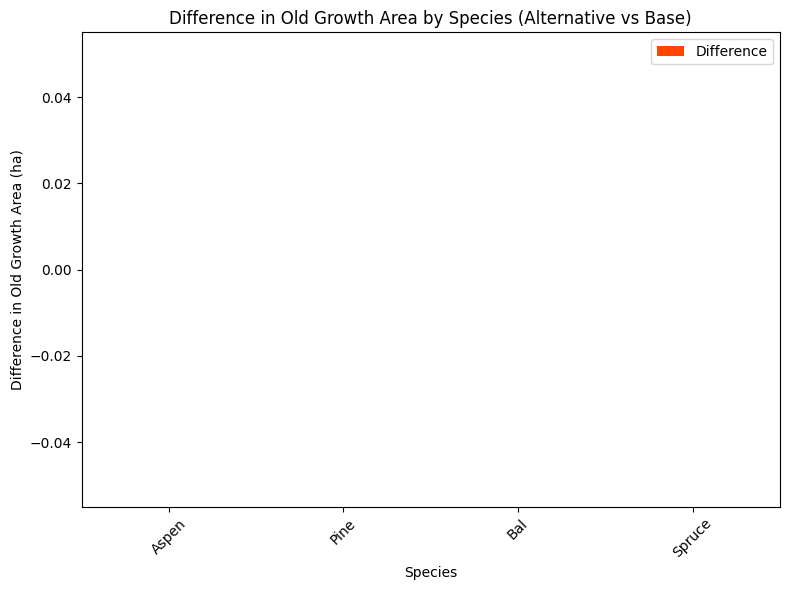

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


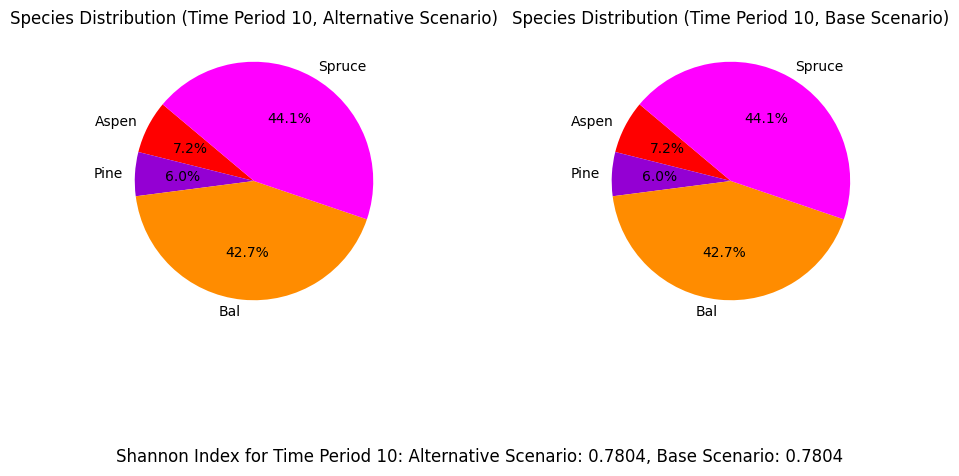

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for mining_site_3_max_hv_ms3_AAC_90%...
running the scenario for the mining site 3(90%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x63014774
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.15s
Presolved: 1699 rows, 30867 colu

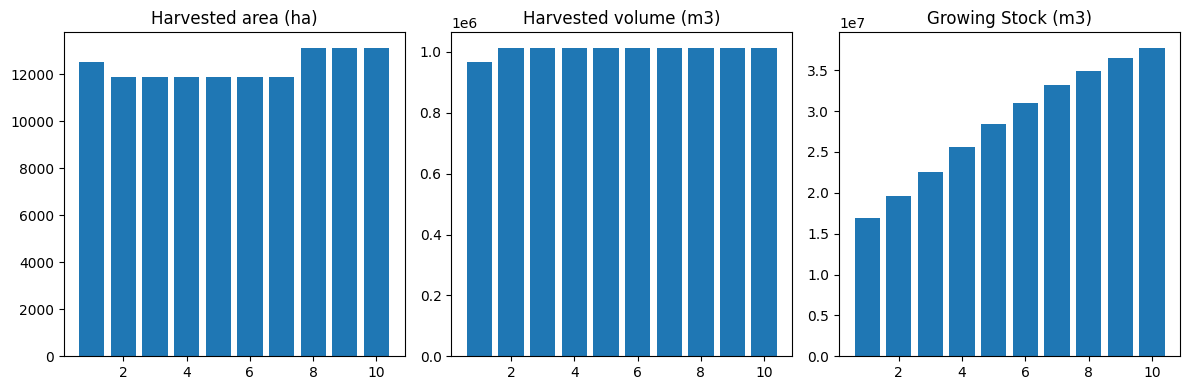

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_90%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10667
The economic indicator (the provincial government revenues) is:  363785
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


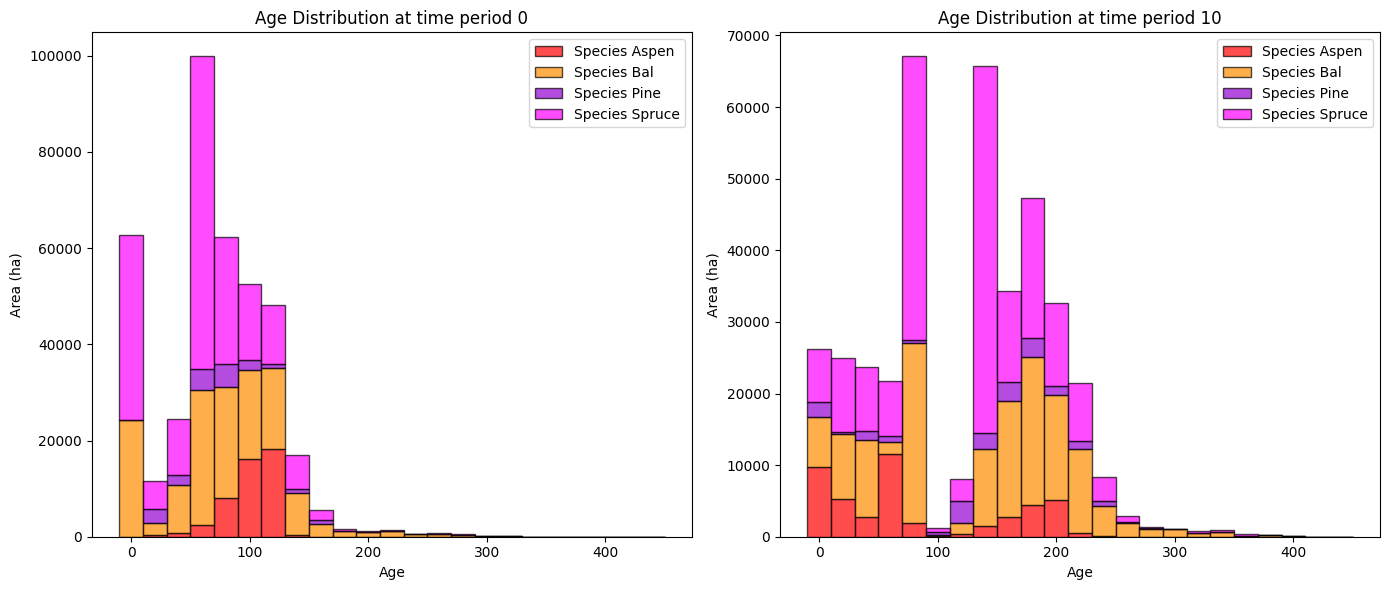

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_90%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13577.035221  12631.721533
Pine     602.782616   7310.907227   6708.124611
Bal     4315.588546  49372.562958  45056.974412
Spruce  1072.814408  34215.209124  33142.394716

Old growth has **increased** by 97539.22 hectares from time period 0 to time period 10.


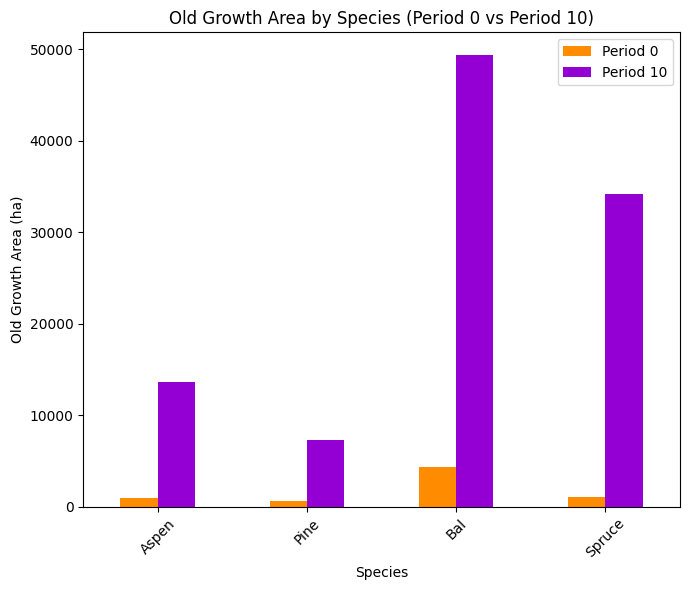

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_90%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7774

Diversity has **decreased** by 10.75% from time 0 to time 10.


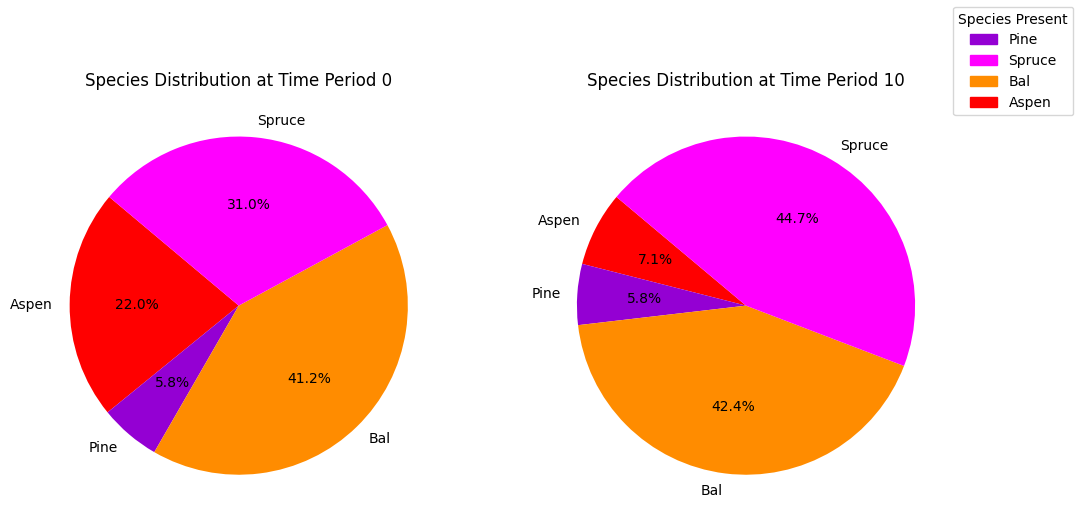

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_90%_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.12s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0

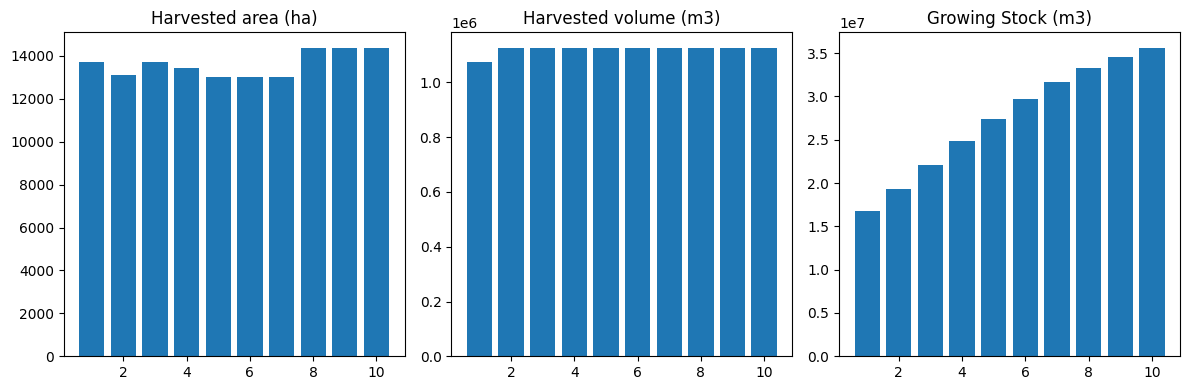

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


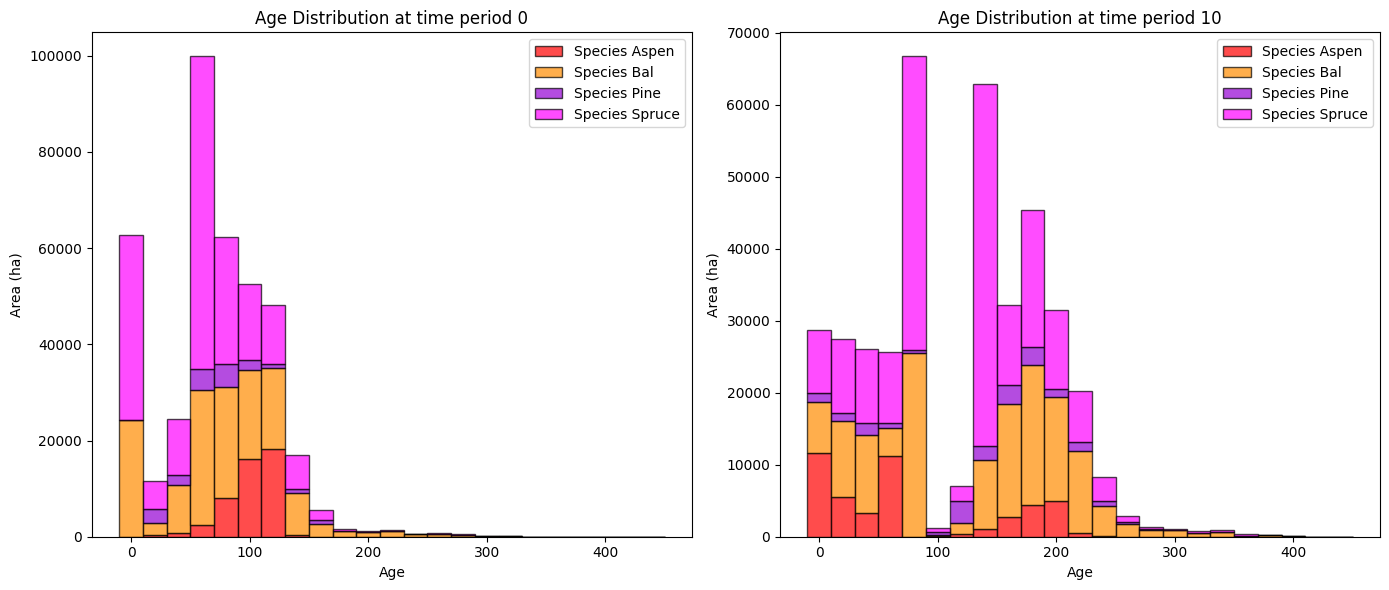

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


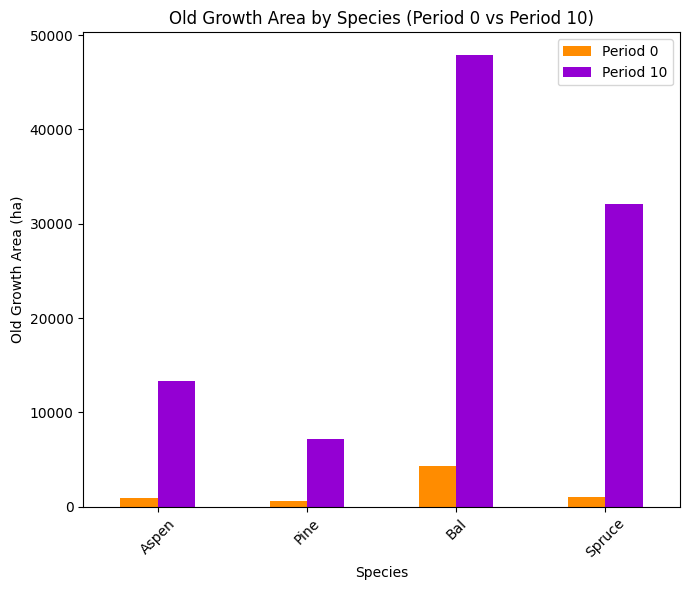

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


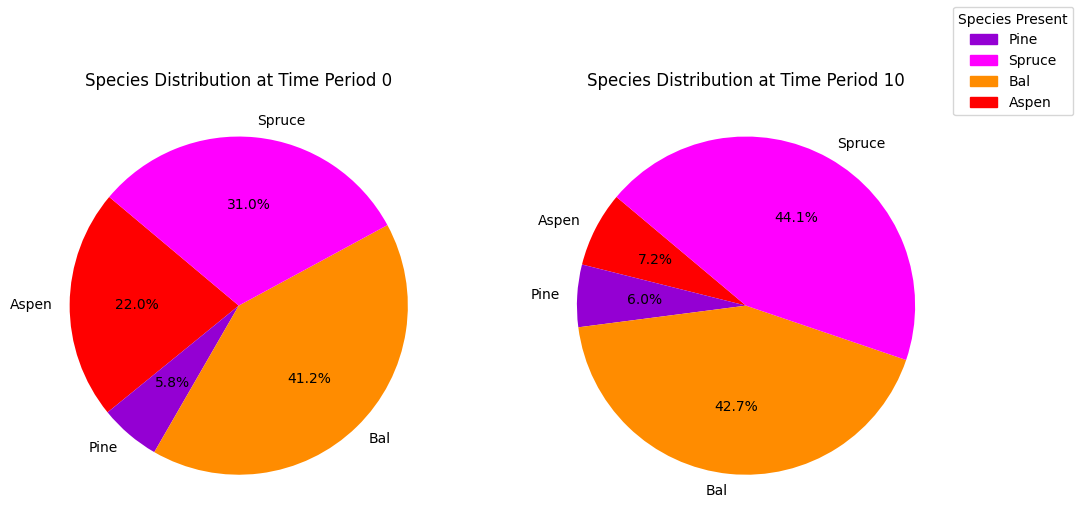

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


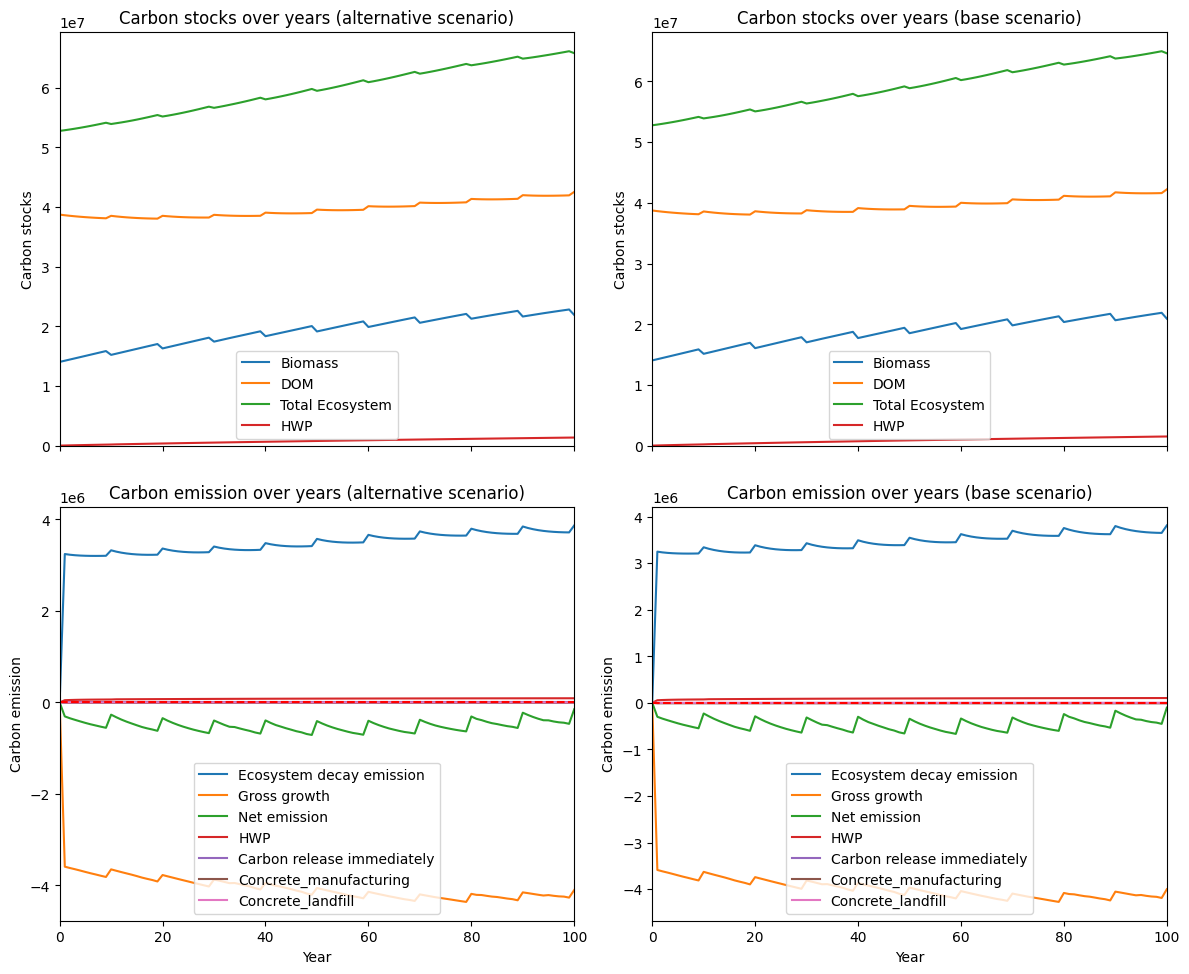

---------------------------------------------------------------------------------------
Net emission difference -4150675.9392781286
Net emission base scenario -46083355.39637767
Net emission alternative scenario -50234031.335655786
dollar_per_ton is:  2.4092461435905705
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0   290.051090   290.051090
Pine    0.0   129.920814   129.920814
Bal     0.0  1479.802633  1479.802633
Spruce  0.0  2174.277203  2174.277203

Overall, the old growth area has **increased** by 4074.05 hectares in the alternative scenario compared to the base scenario.


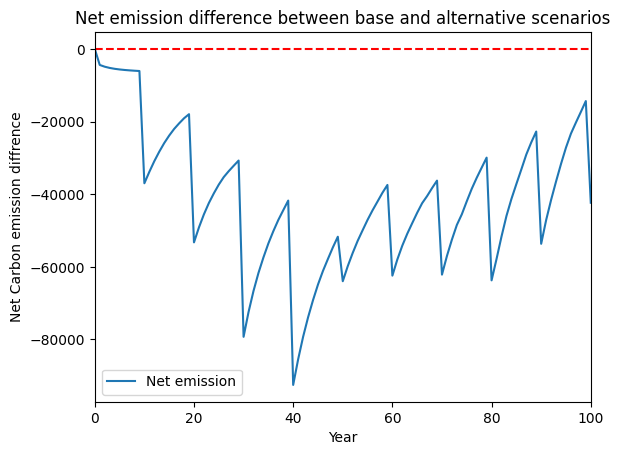

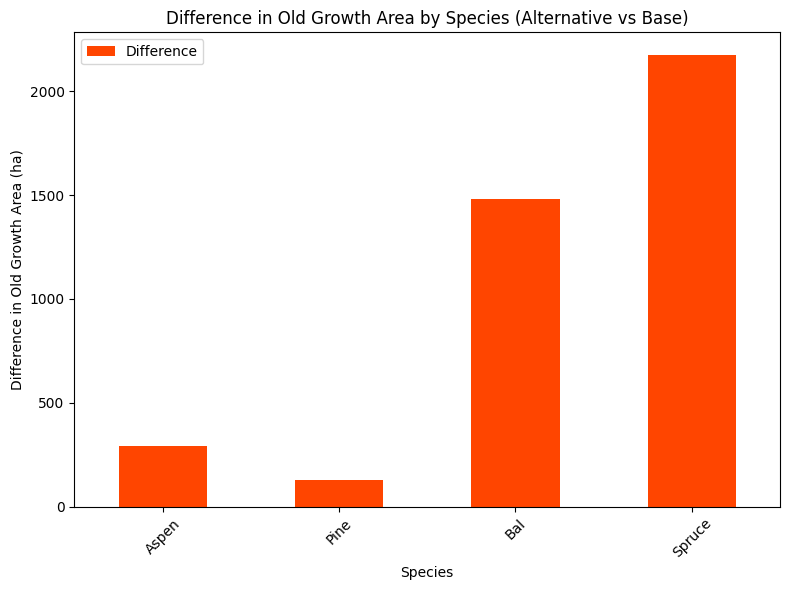

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


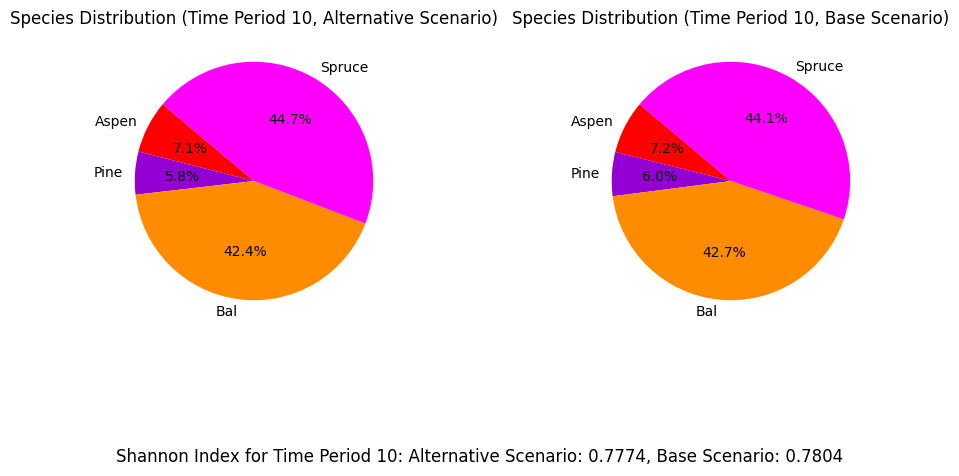

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for mining_site_3_max_hv_ms3_AAC_80%...
running the scenario for the mining site 3 (80%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x47cc0108
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.13s
Presolved: 1699 rows, 30867 col

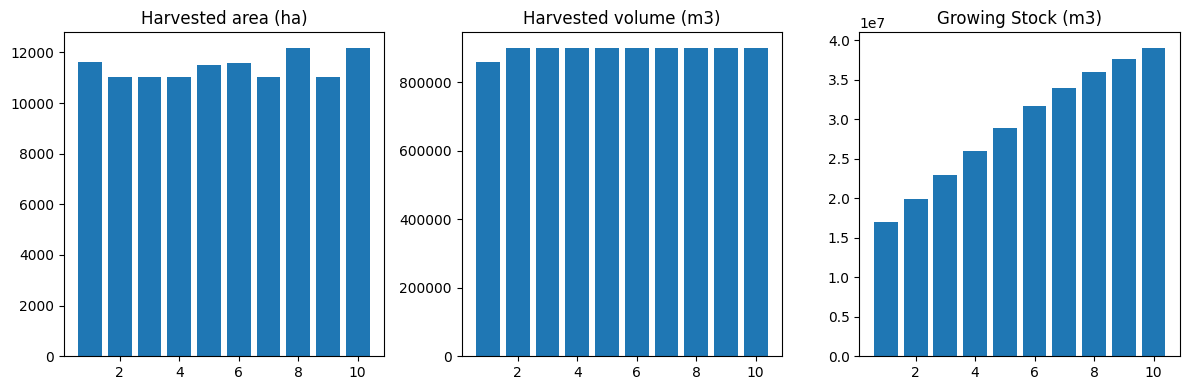

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_80%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  9482
The economic indicator (the provincial government revenues) is:  323364
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


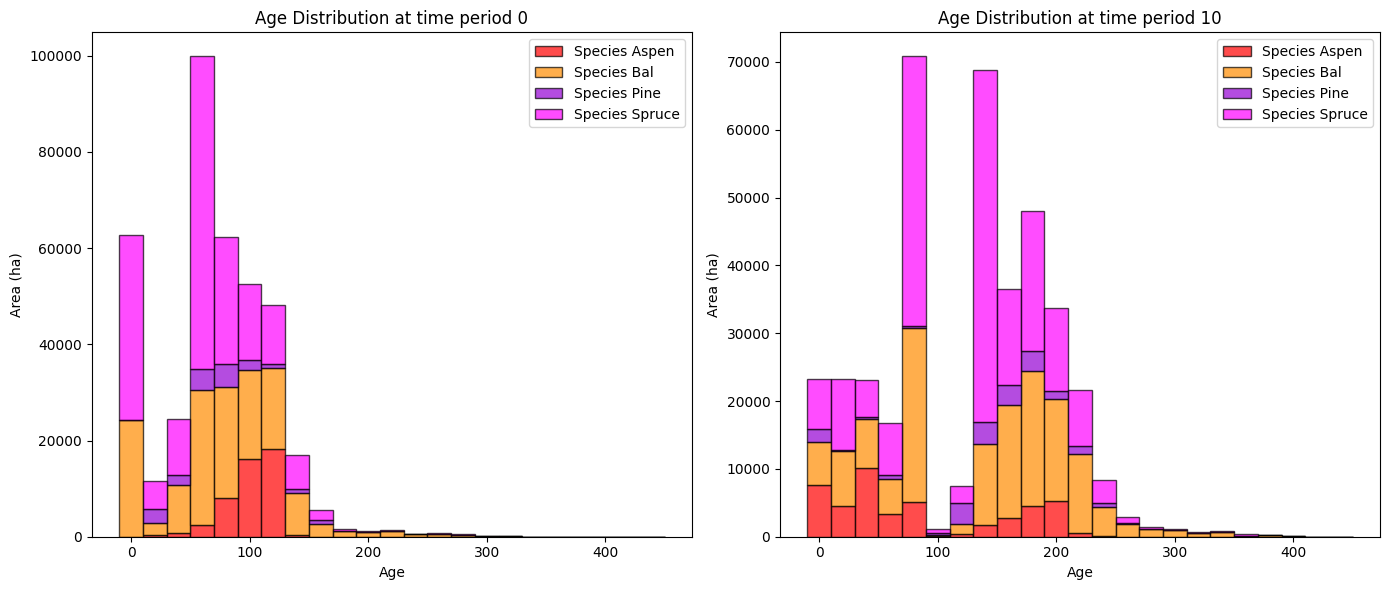

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_80%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13992.917391  13047.603703
Pine     602.782616   7969.452841   7366.670225
Bal     4315.588546  49475.202912  45159.614366
Spruce  1072.814408  35402.542006  34329.727598

Old growth has **increased** by 99903.62 hectares from time period 0 to time period 10.


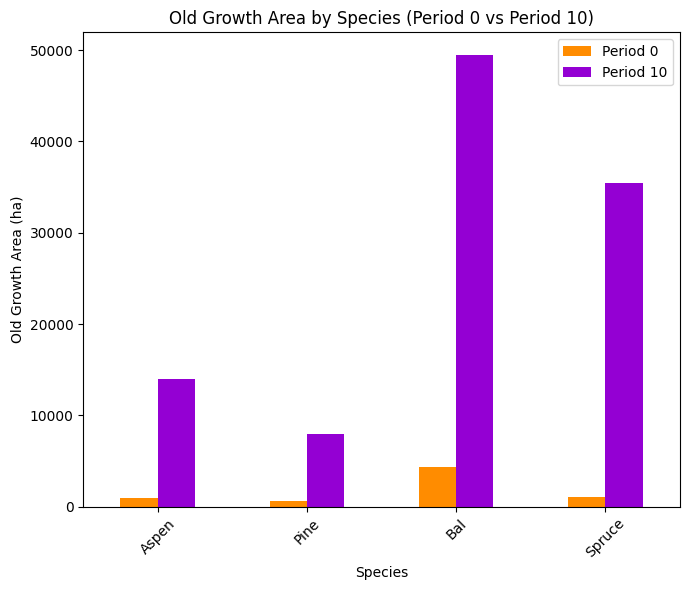

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_80%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7825

Diversity has **decreased** by 10.24% from time 0 to time 10.


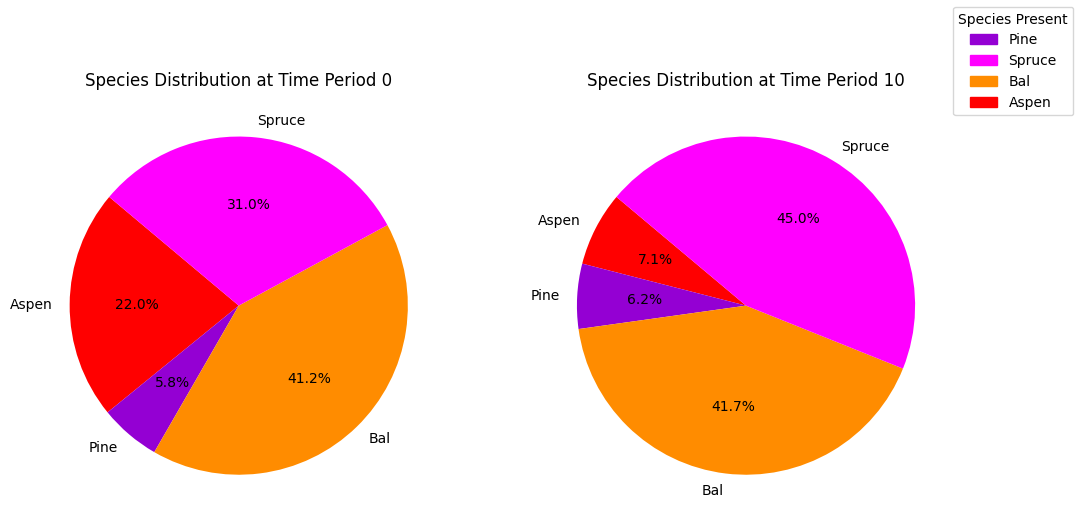

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_80%_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.13s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0

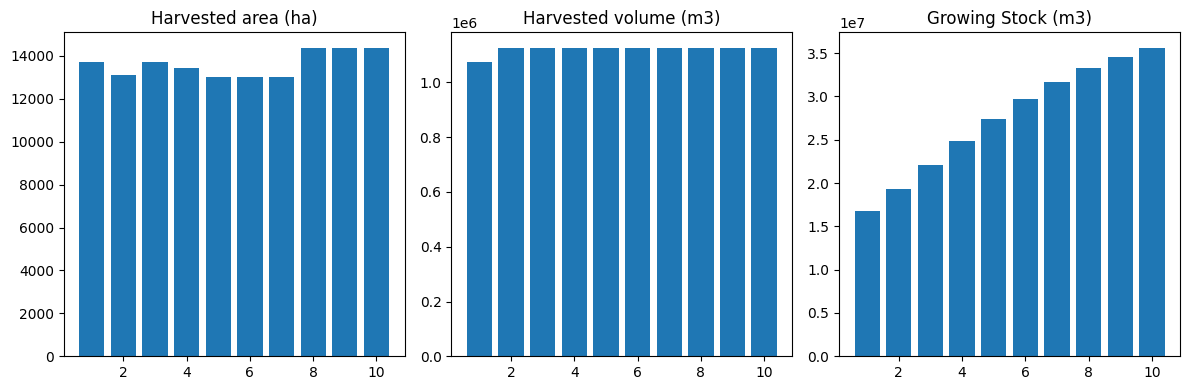

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


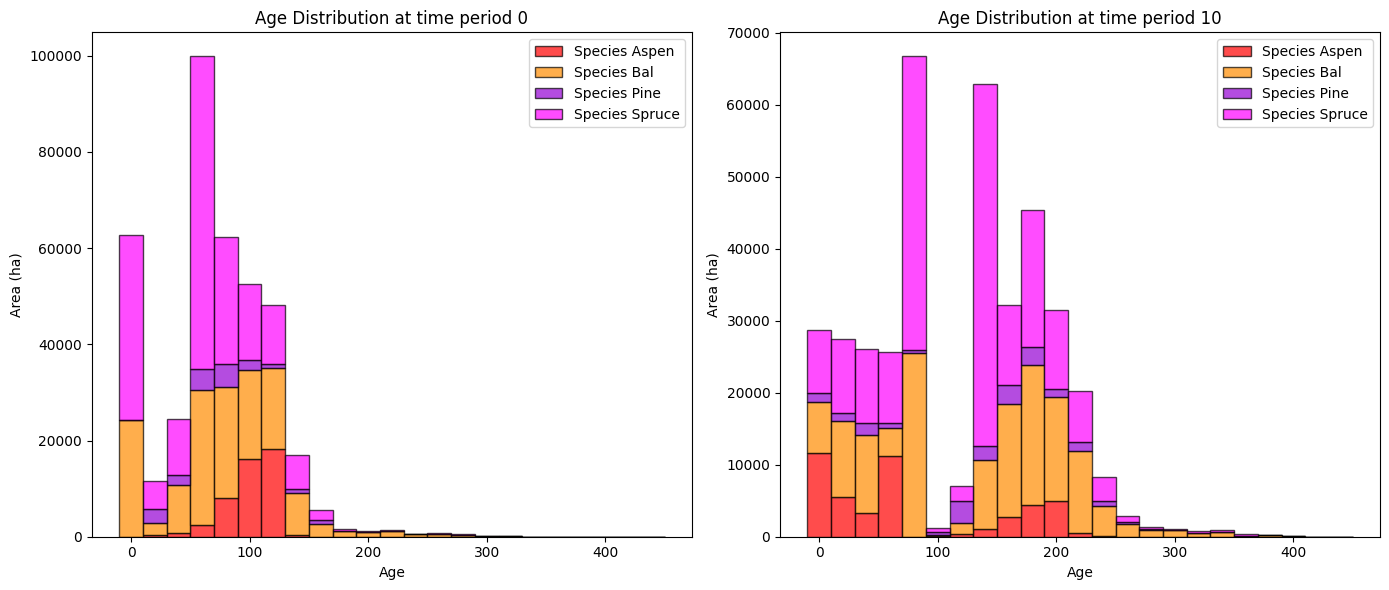

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


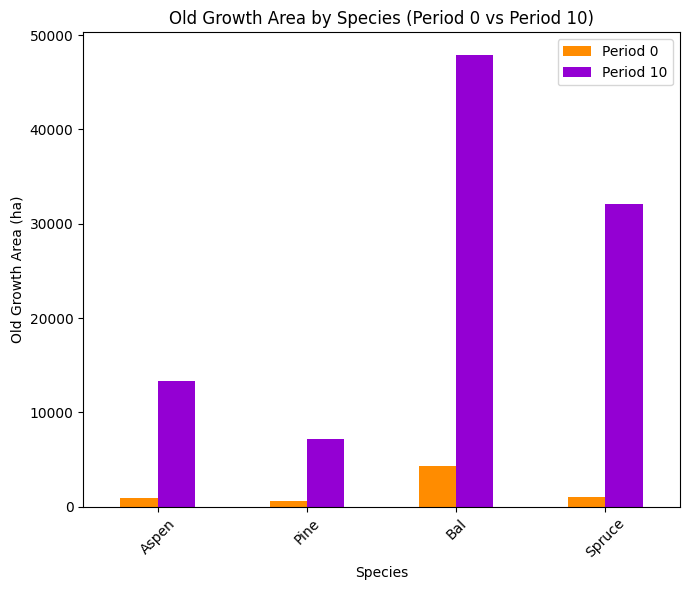

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


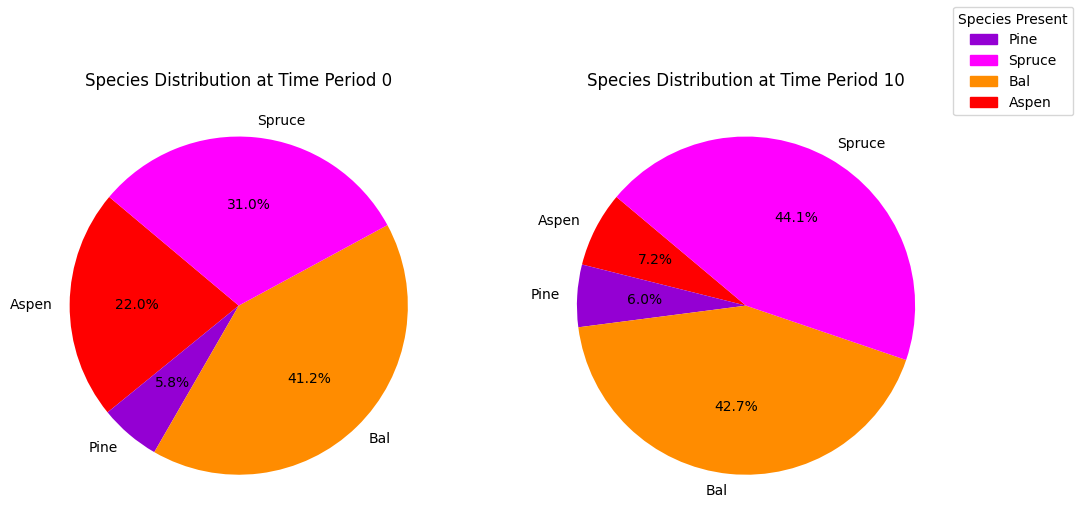

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


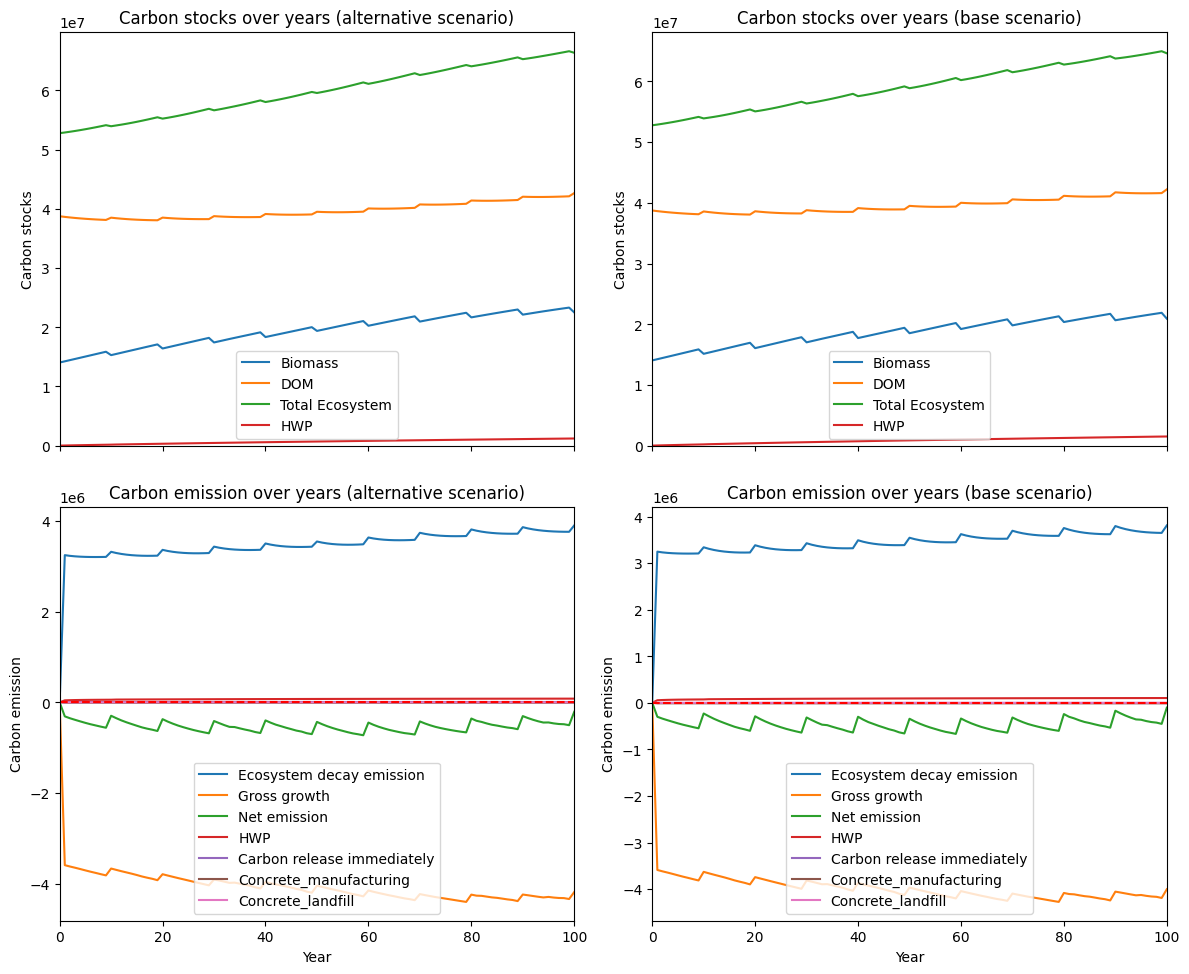

---------------------------------------------------------------------------------------
Net emission difference -6569501.293303678
Net emission base scenario -46083355.39637767
Net emission alternative scenario -52652856.689681344
dollar_per_ton is:  1.5221855592285285
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0   705.933260   705.933260
Pine    0.0   788.466428   788.466428
Bal     0.0  1582.442588  1582.442588
Spruce  0.0  3361.610086  3361.610086

Overall, the old growth area has **increased** by 6438.45 hectares in the alternative scenario compared to the base scenario.


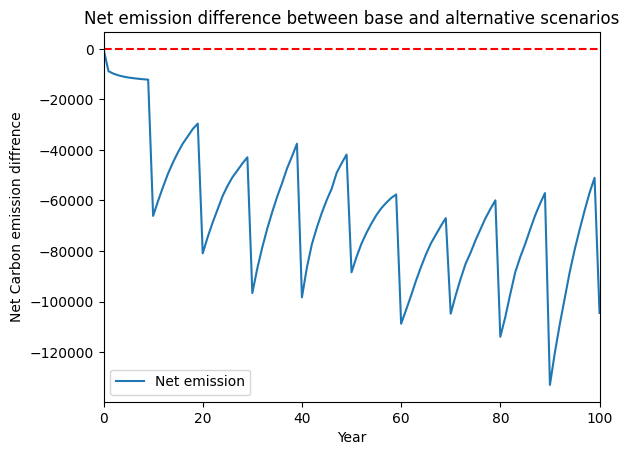

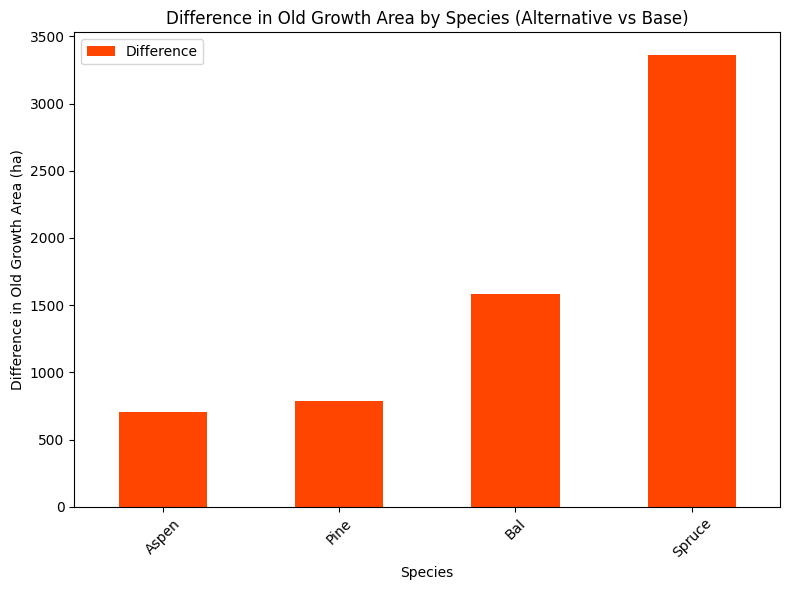

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


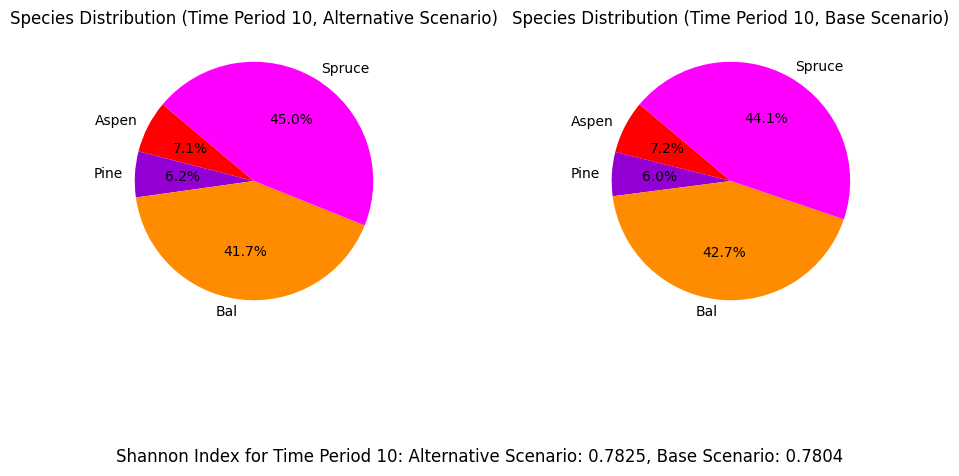

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for mining_site_3_max_hv_ms3_AAC_70%...
running the scenario for the mining site 3 (70%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xfb1596fd
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.12s
Presolved: 1699 rows, 30867 col

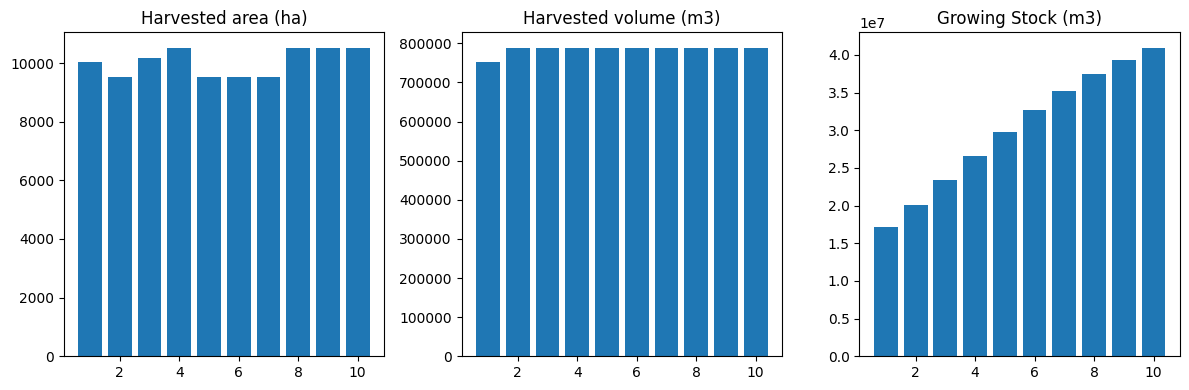

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_70%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8296
The economic indicator (the provincial government revenues) is:  282944
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


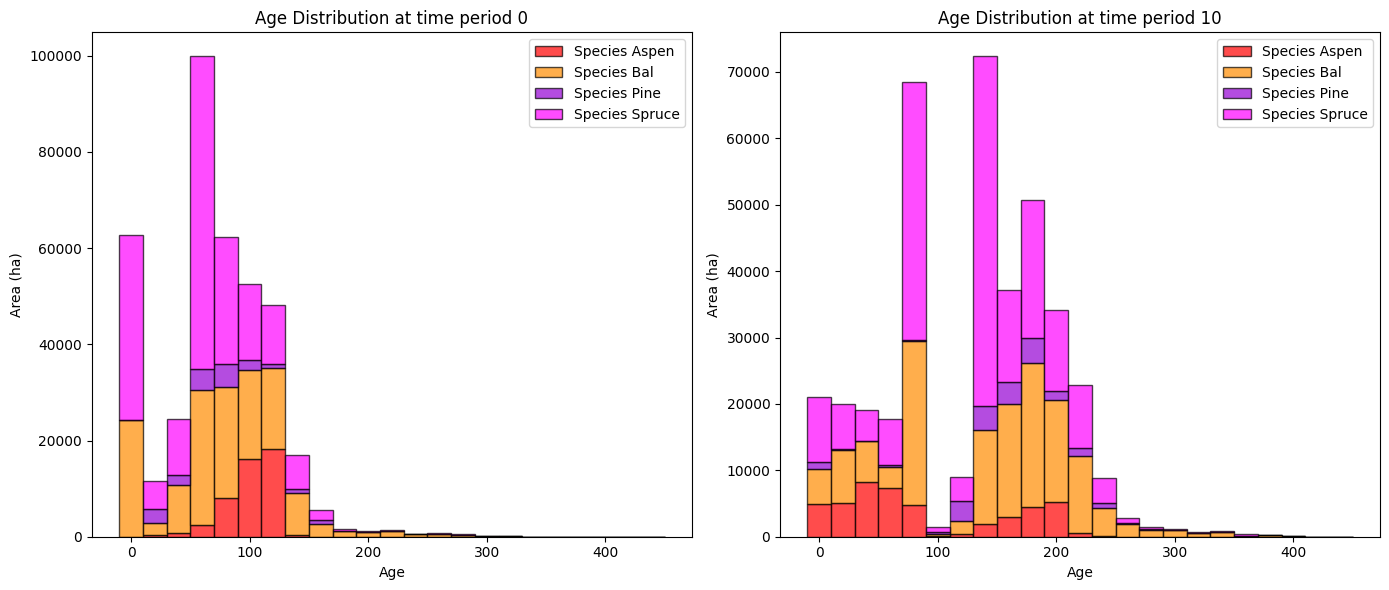

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_70%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  14276.748119  13331.434431
Pine     602.782616   8905.683793   8302.901177
Bal     4315.588546  50667.660346  46352.071800
Spruce  1072.814408  37141.235415  36068.421008

Old growth has **increased** by 104054.83 hectares from time period 0 to time period 10.


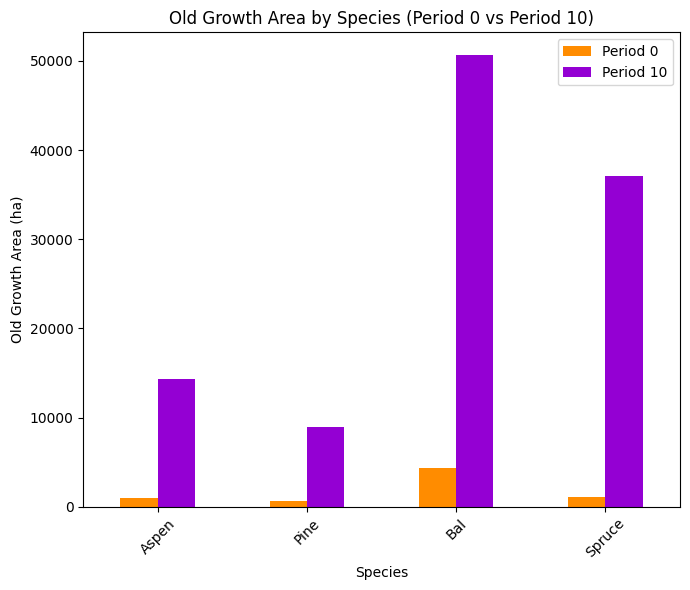

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_70%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7852

Diversity has **decreased** by 9.97% from time 0 to time 10.


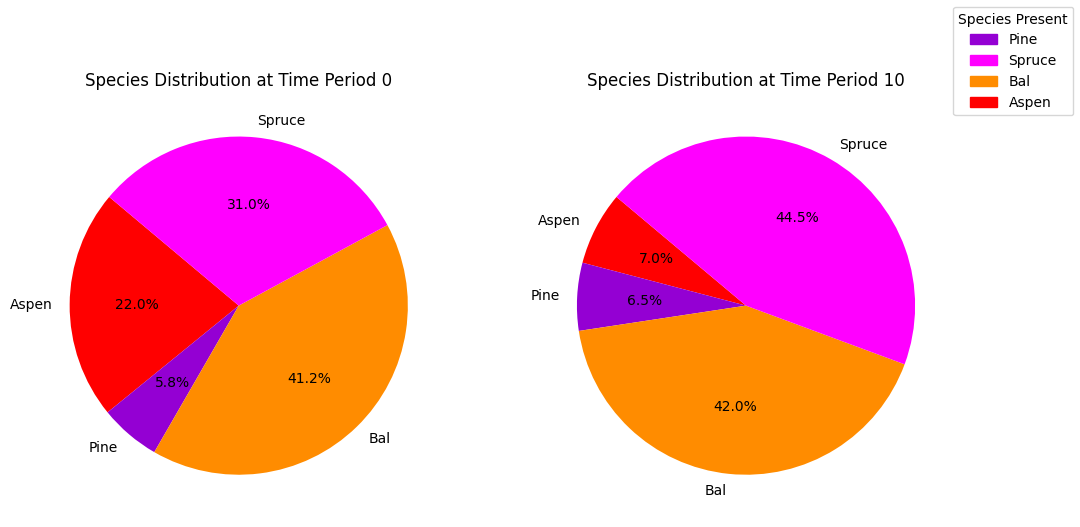

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_70%_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.13s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0

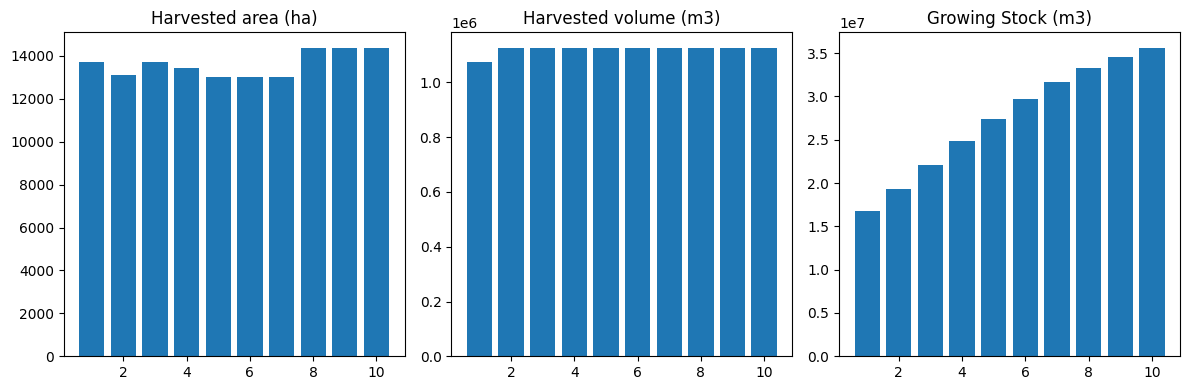

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


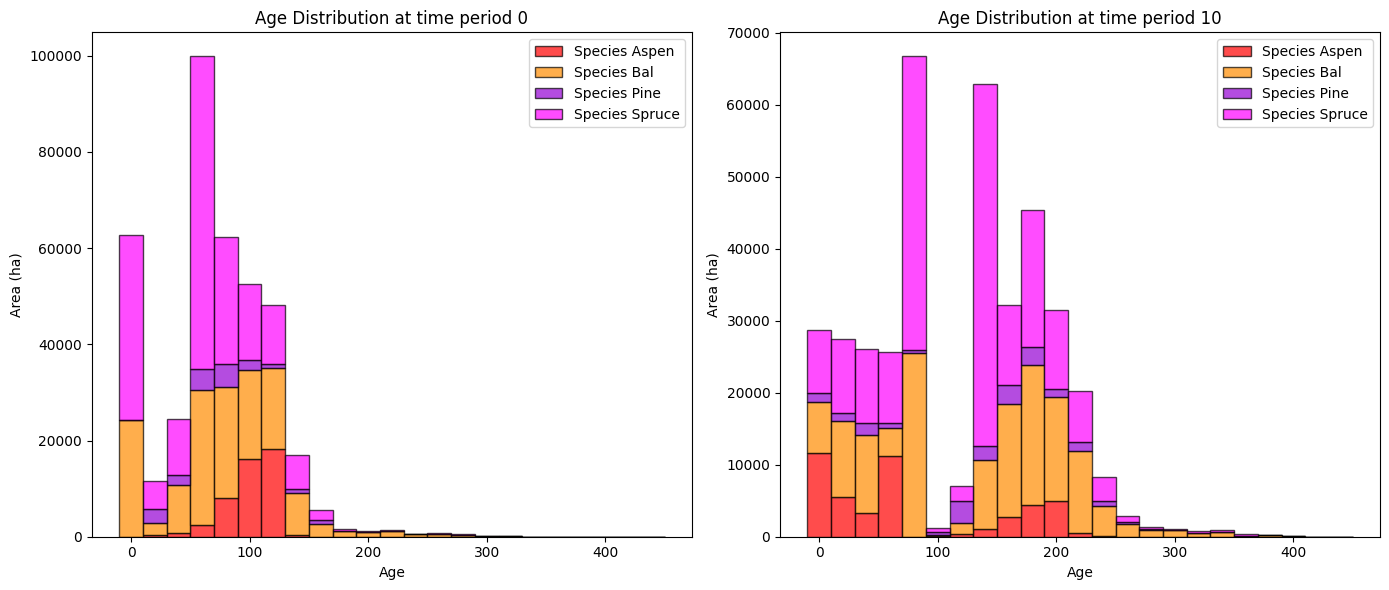

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


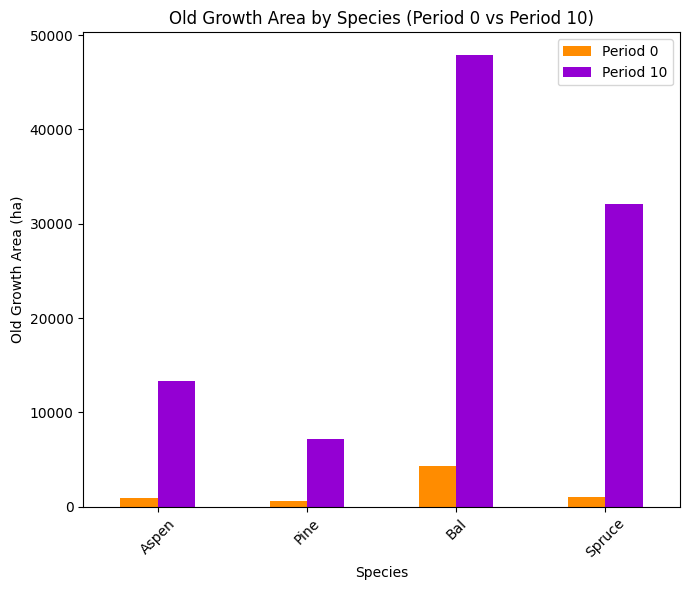

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


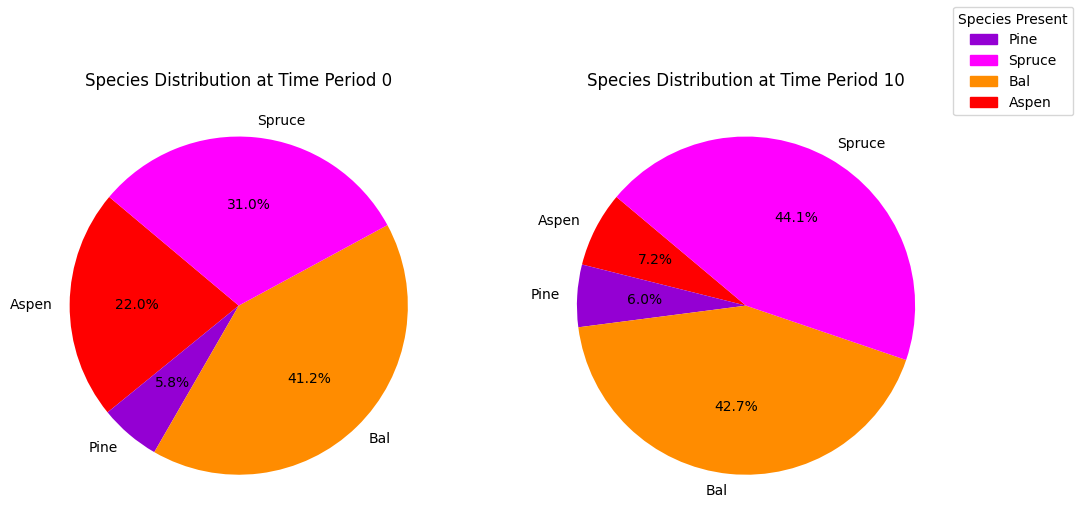

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


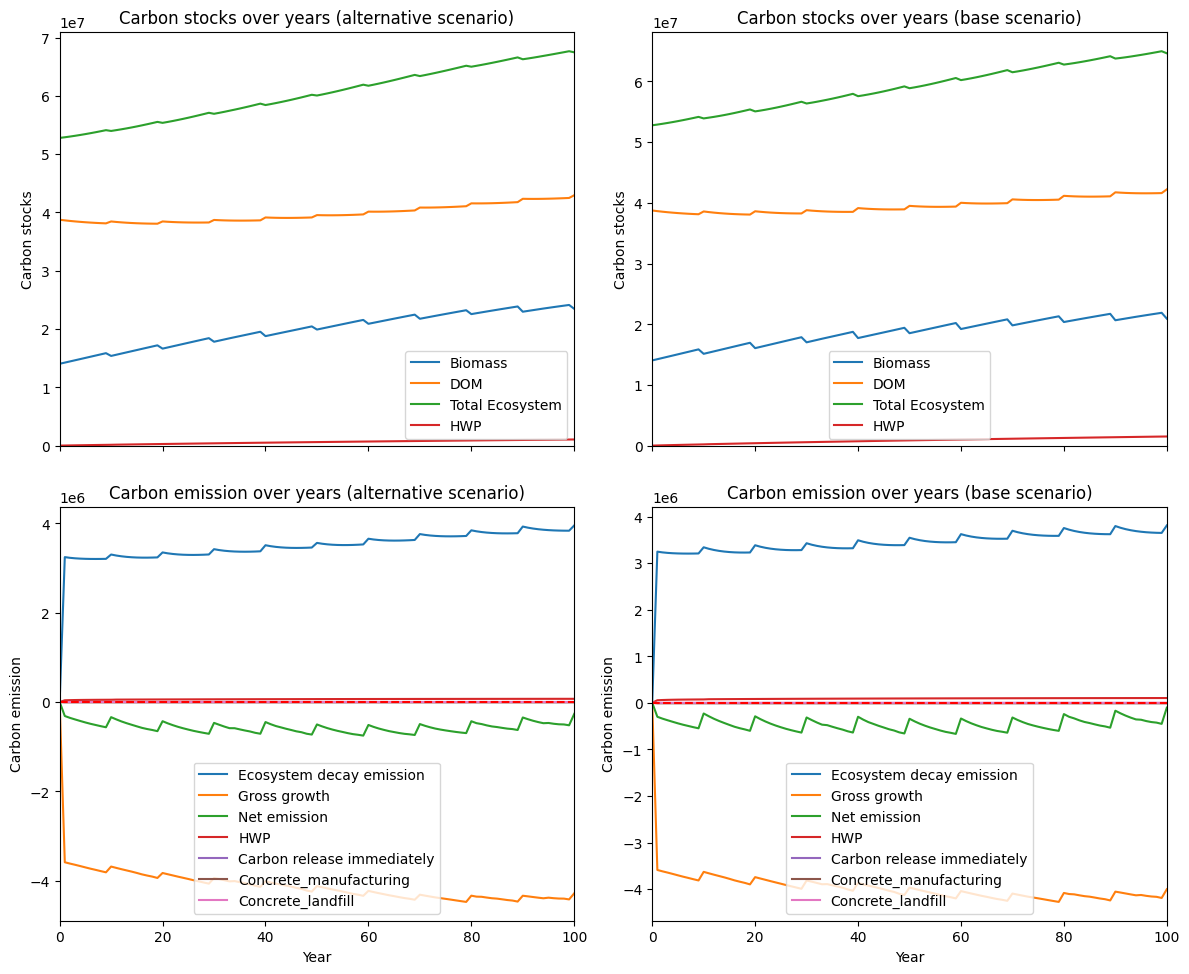

---------------------------------------------------------------------------------------
Net emission difference -10475672.954942737
Net emission base scenario -46083355.39637767
Net emission alternative scenario -56559028.3513204
dollar_per_ton is:  0.9545926111870169
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0   989.763988   989.763988
Pine    0.0  1724.697381  1724.697381
Bal     0.0  2774.900021  2774.900021
Spruce  0.0  5100.303495  5100.303495

Overall, the old growth area has **increased** by 10589.66 hectares in the alternative scenario compared to the base scenario.


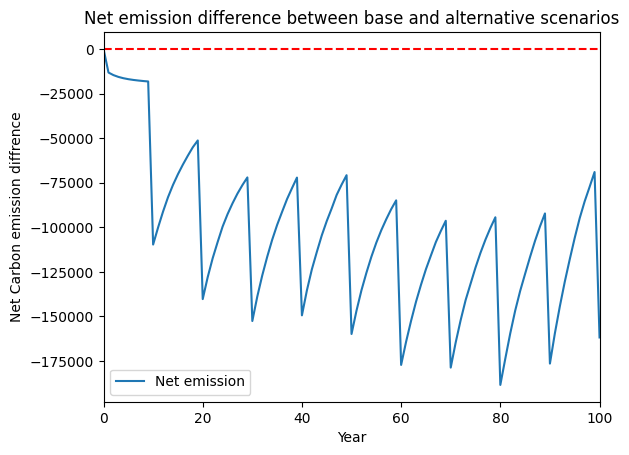

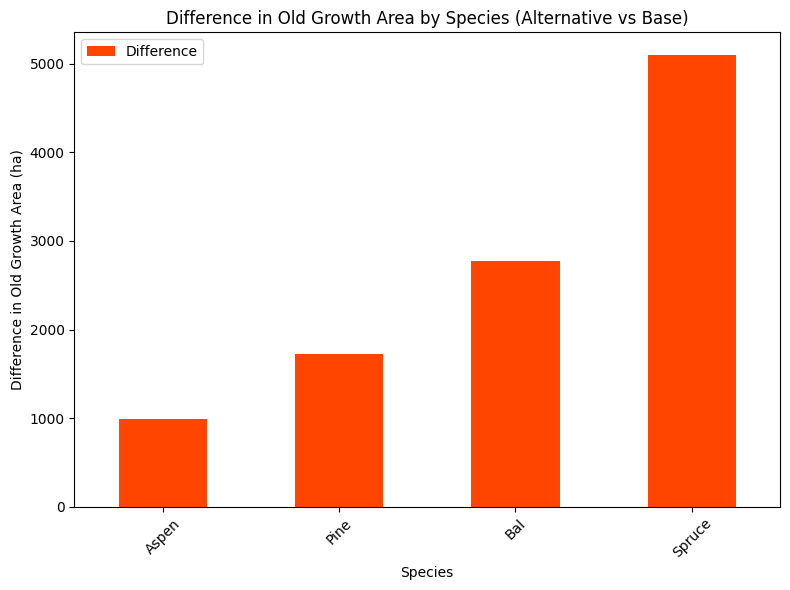

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


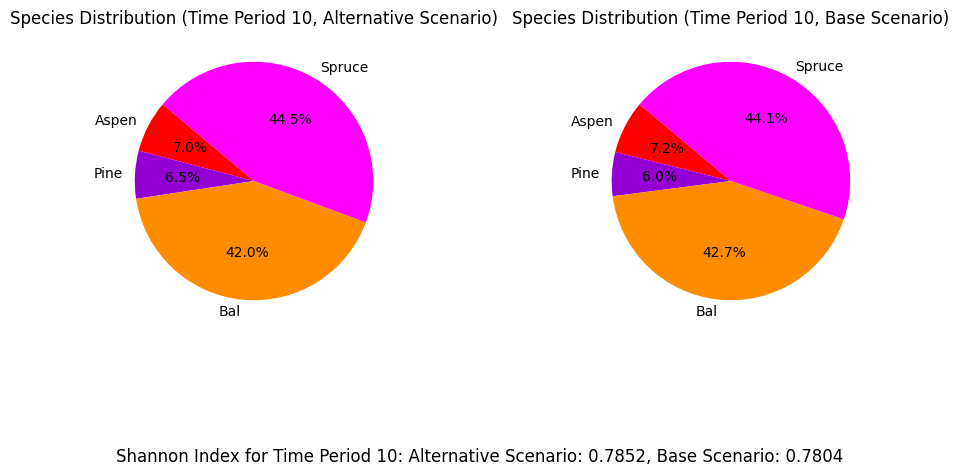

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for mining_site_3_max_hv_ms3_AAC_60%...
running the scenario for the mining site 3 (60%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x7c10d97b
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.13s
Presolved: 1699 rows, 30867 col

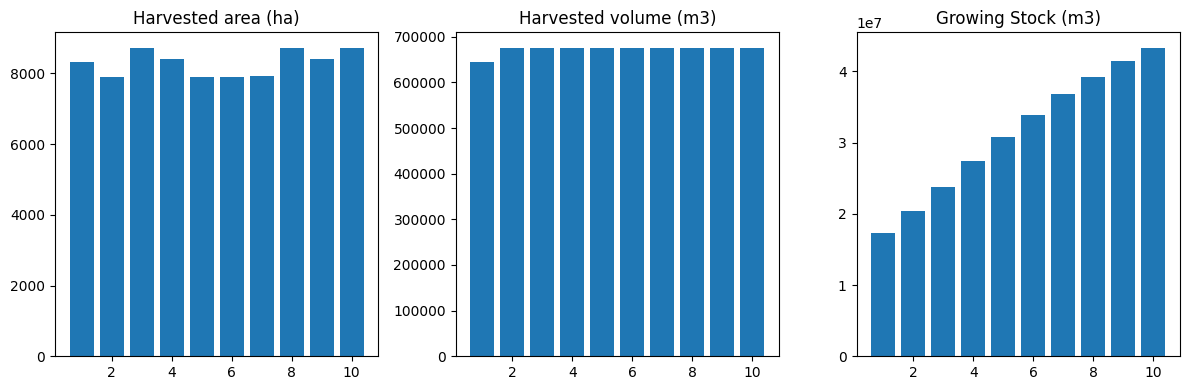

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_60%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7111
The economic indicator (the provincial government revenues) is:  242523
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


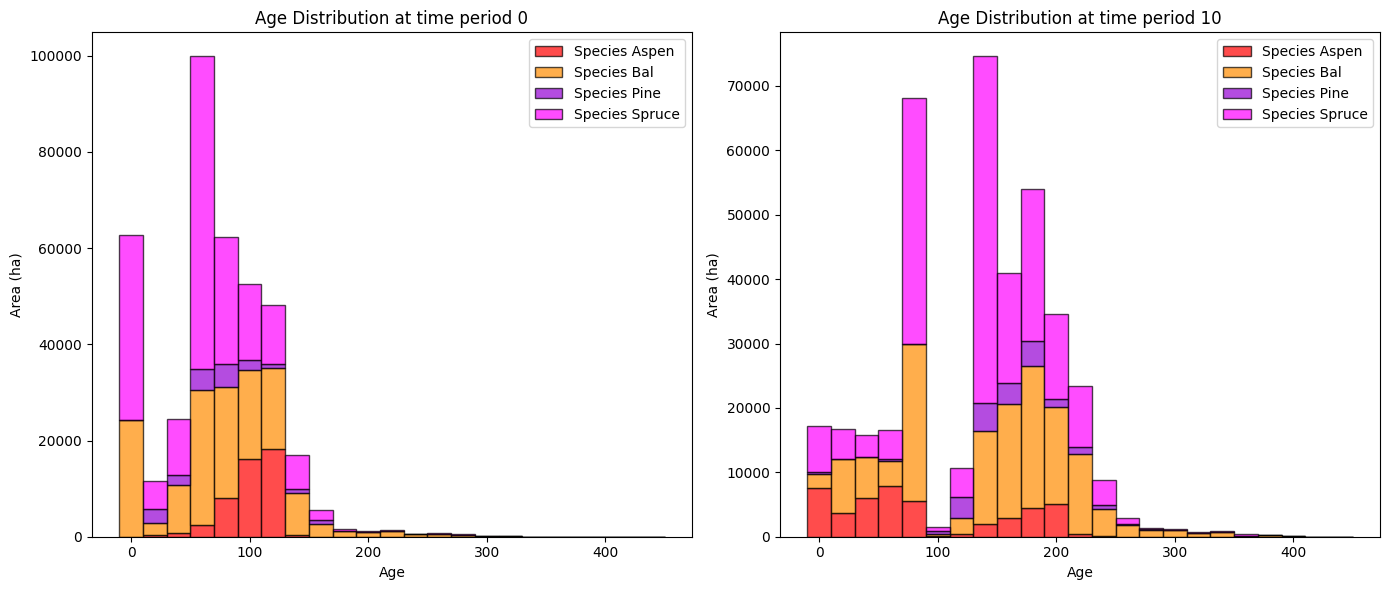

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_60%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13978.117263  13032.803575
Pine     602.782616   9168.440555   8565.657938
Bal     4315.588546  51385.129954  47069.541408
Spruce  1072.814408  39613.459781  38540.645373

Old growth has **increased** by 107208.65 hectares from time period 0 to time period 10.


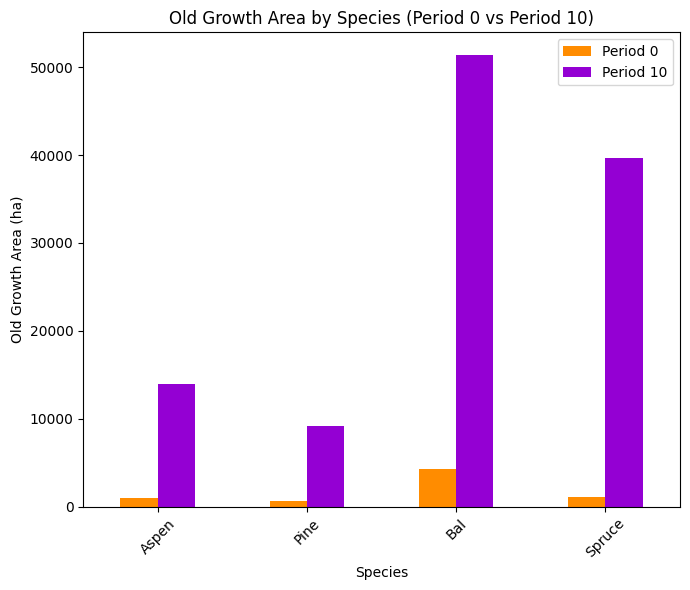

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_60%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7786

Diversity has **decreased** by 10.62% from time 0 to time 10.


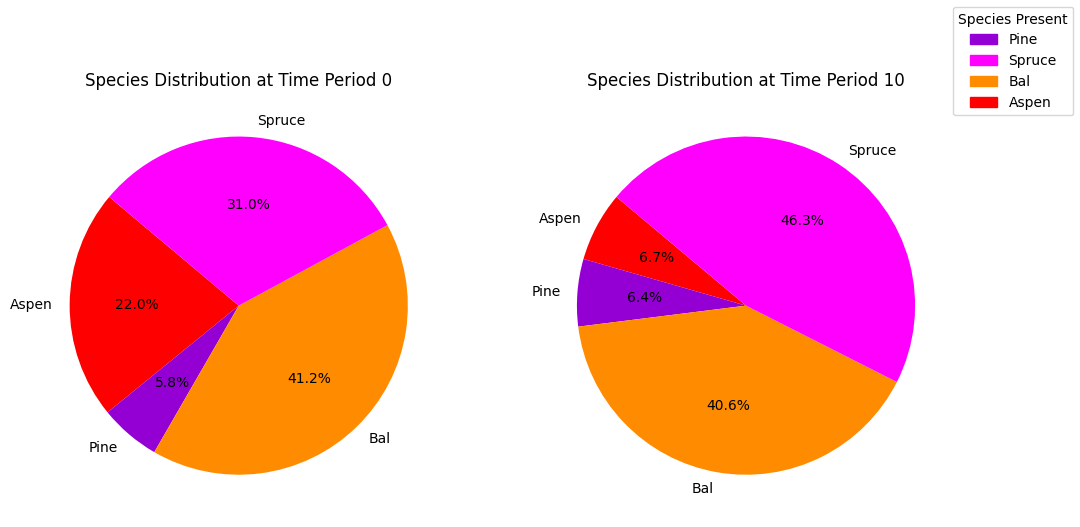

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_60%_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.12s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0

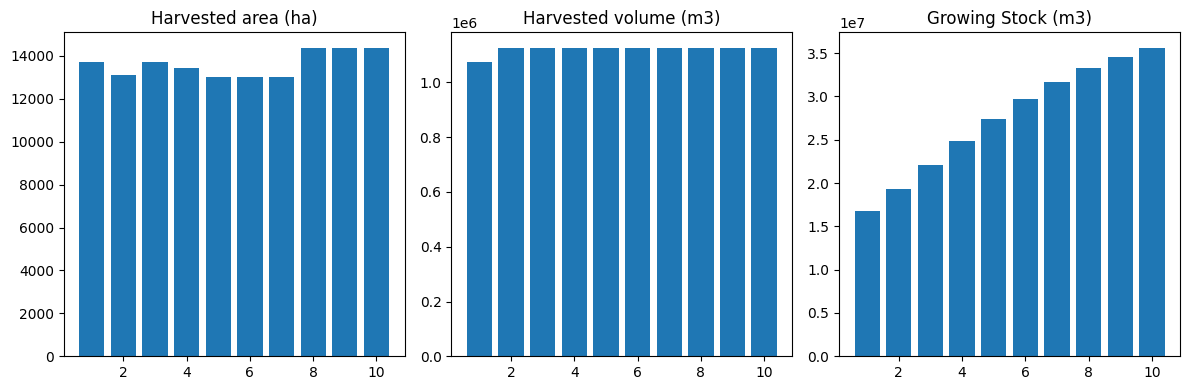

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


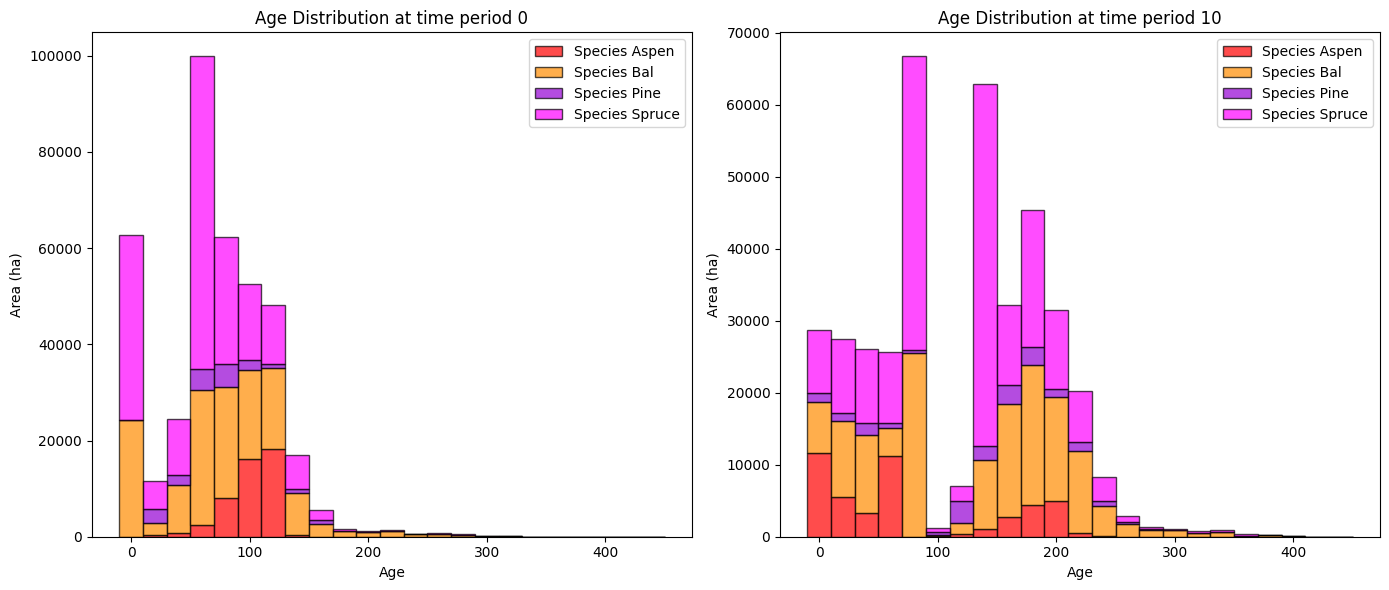

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


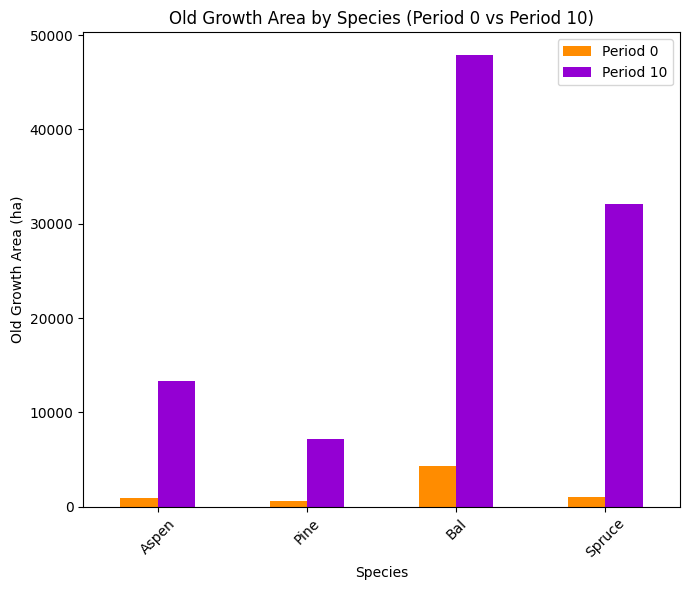

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


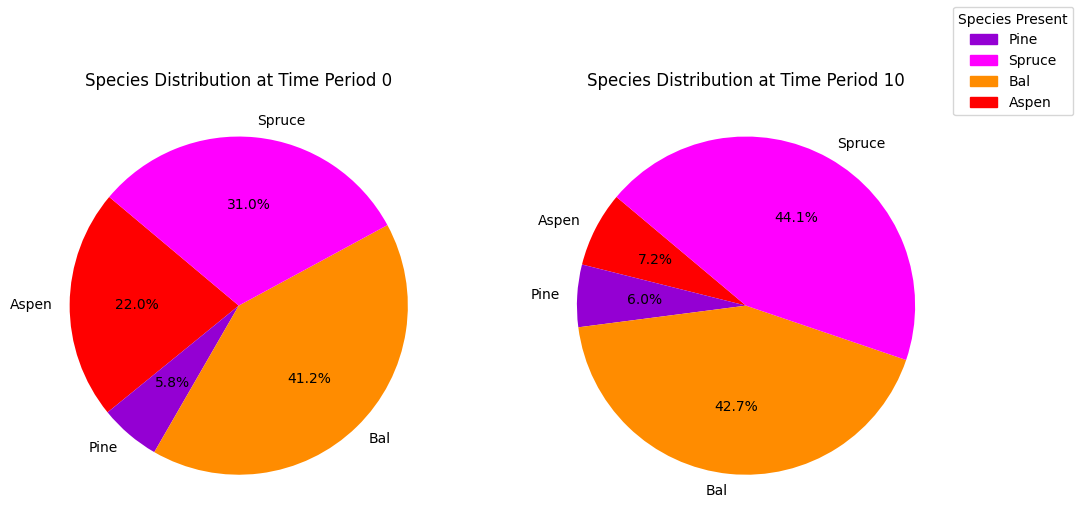

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


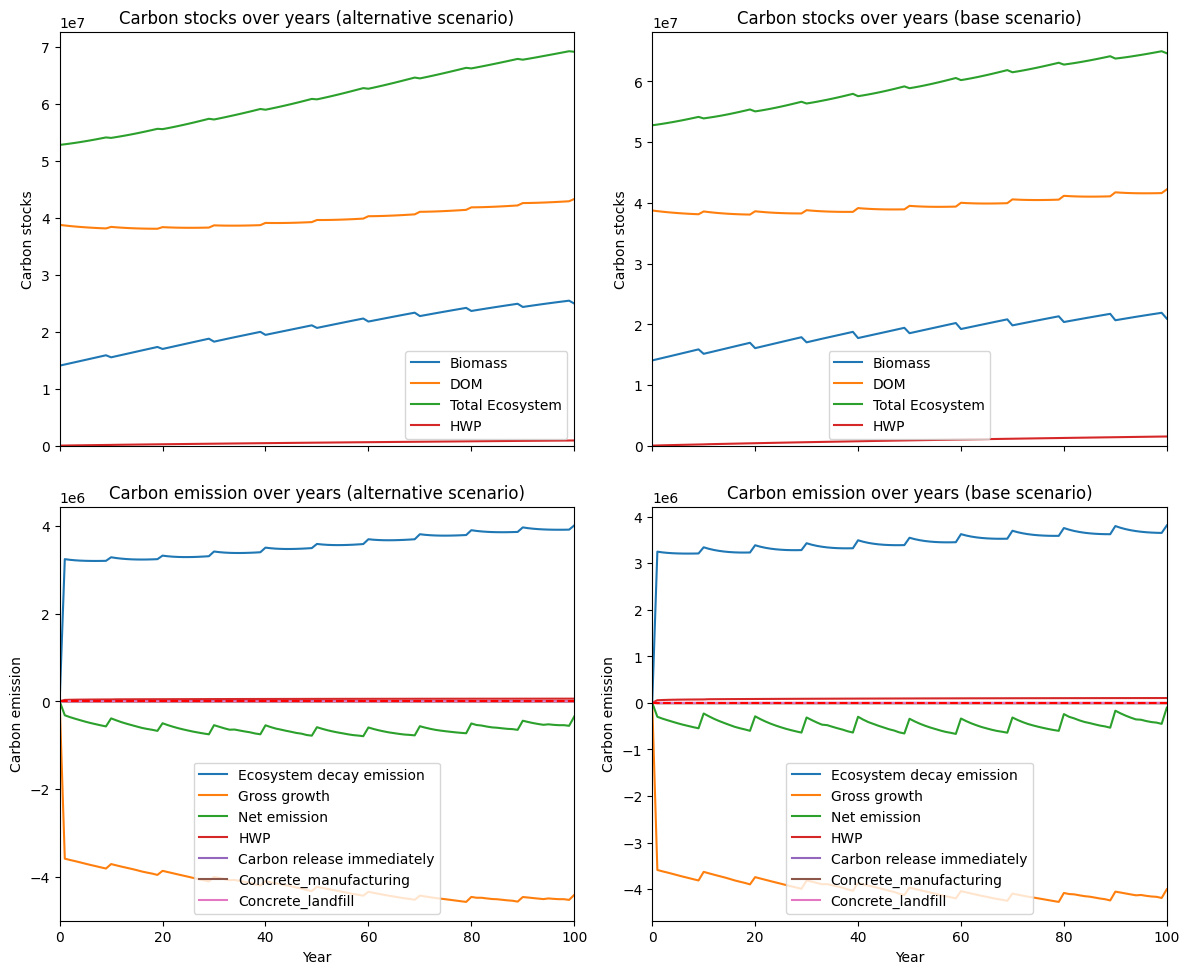

---------------------------------------------------------------------------------------
Net emission difference -15482176.816264126
Net emission base scenario -46083355.39637767
Net emission alternative scenario -61565532.21264179
dollar_per_ton is:  0.6459040042415053
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0   691.133132   691.133132
Pine    0.0  1987.454142  1987.454142
Bal     0.0  3492.369630  3492.369630
Spruce  0.0  7572.527860  7572.527860

Overall, the old growth area has **increased** by 13743.48 hectares in the alternative scenario compared to the base scenario.


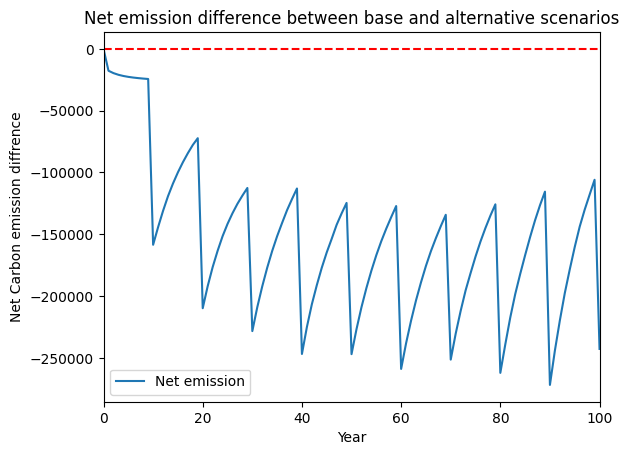

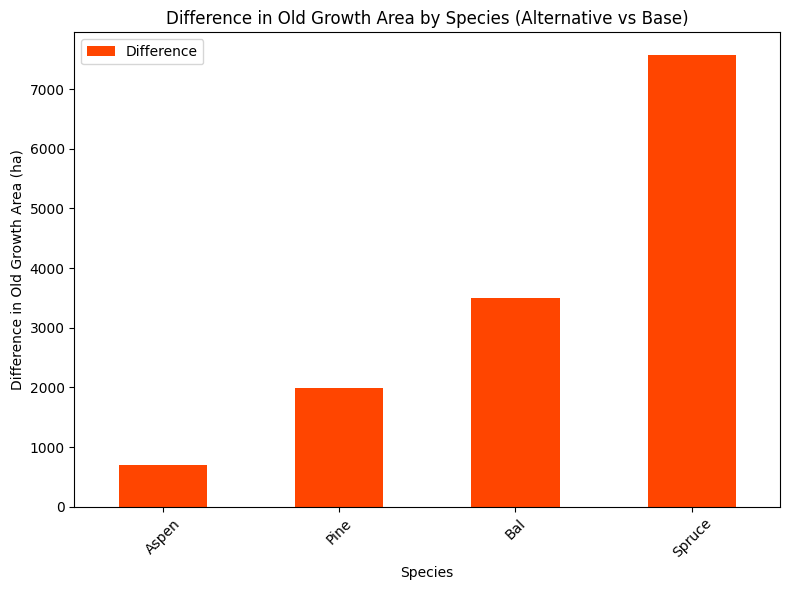

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


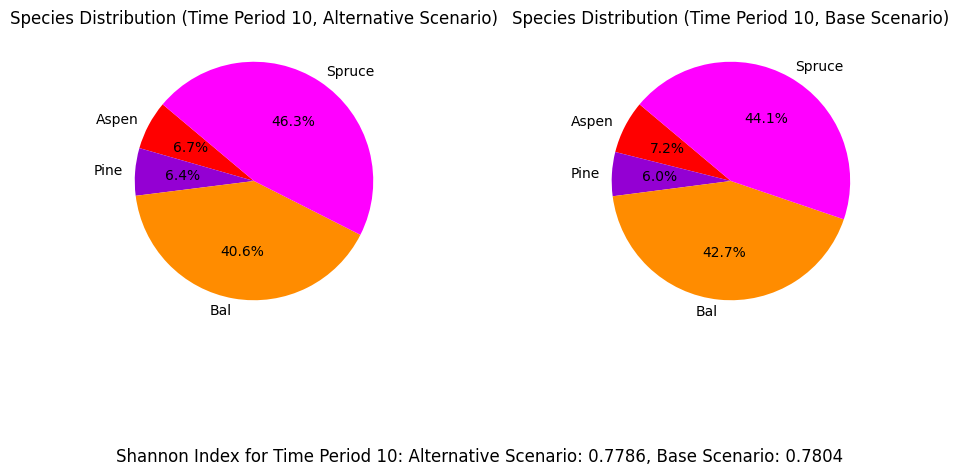

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for mining_site_3_max_hv_ms3_AAC_50%...
running the scenario for the mining site 3 (50%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x1fd7c8ee
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.12s
Presolved: 1699 rows, 30867 col

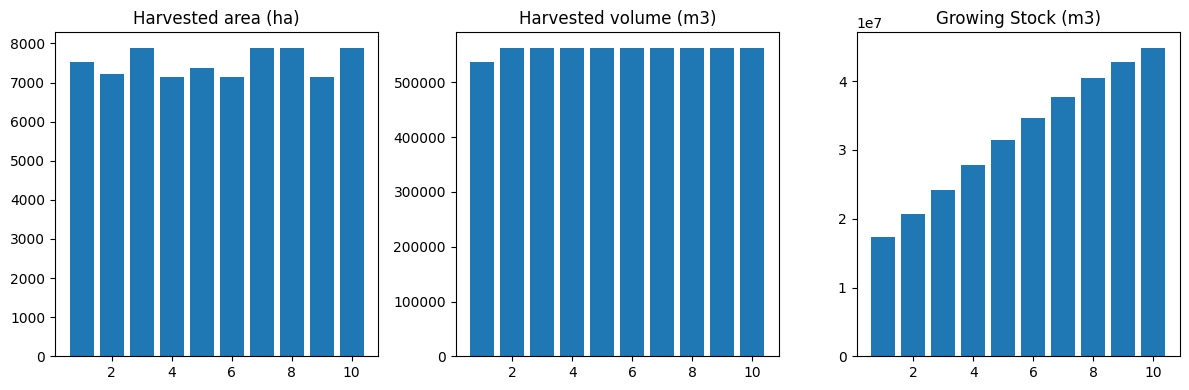

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_50%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  5926
The economic indicator (the provincial government revenues) is:  202103
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


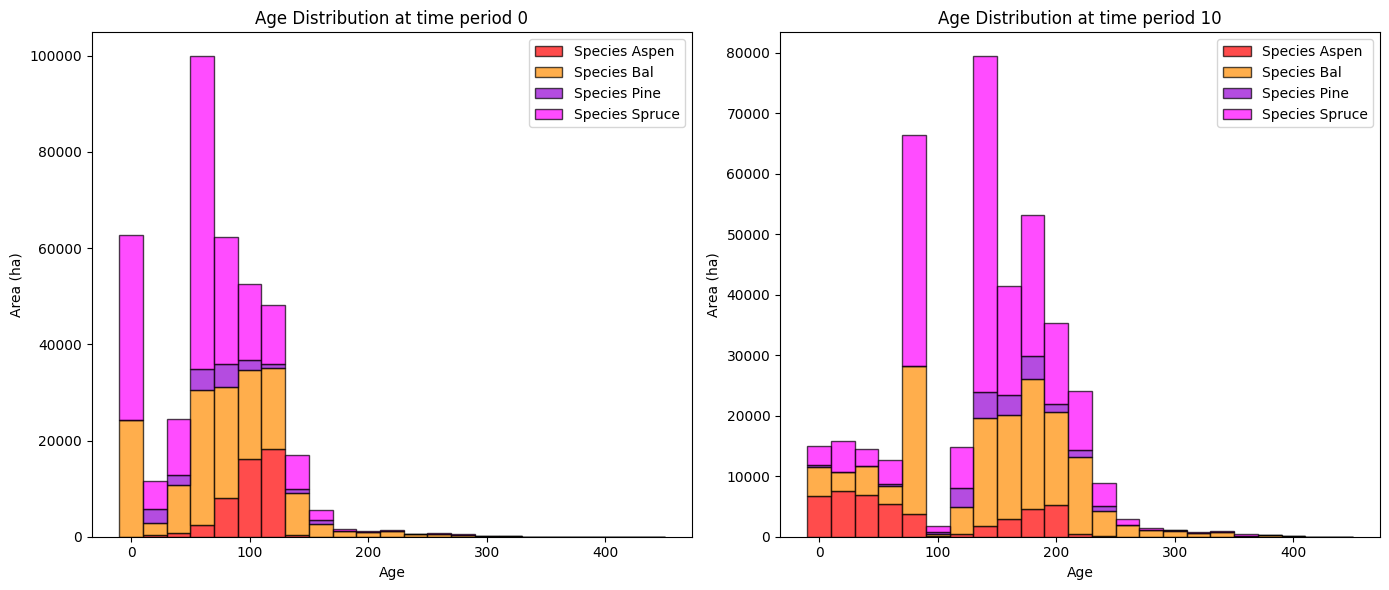

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_50%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  14224.010654  13278.696967
Pine     602.782616   9217.435167   8614.652550
Bal     4315.588546  51857.606709  47542.018163
Spruce  1072.814408  39919.031987  38846.217580

Old growth has **increased** by 108281.59 hectares from time period 0 to time period 10.


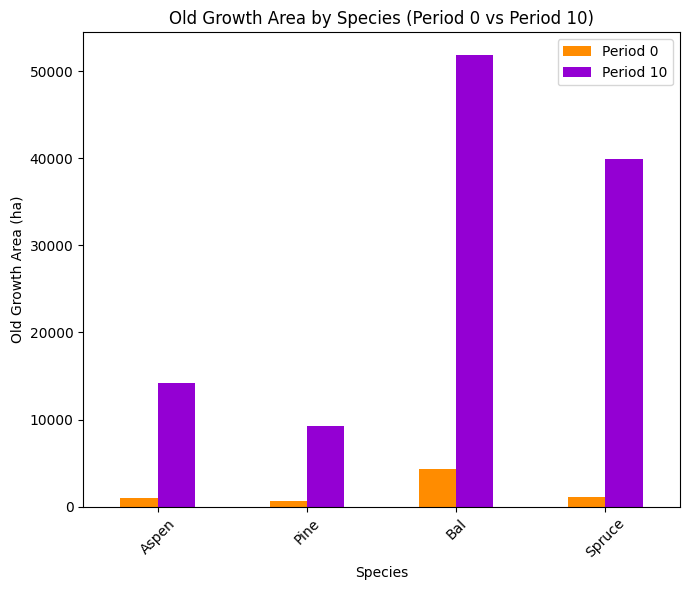

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_50%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7707

Diversity has **decreased** by 11.42% from time 0 to time 10.


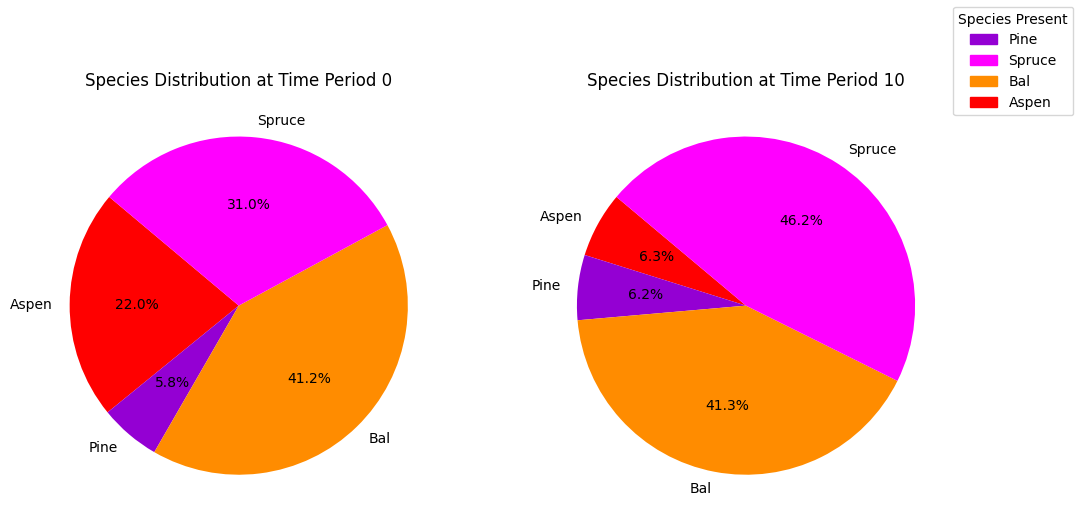

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_50%_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.12s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0

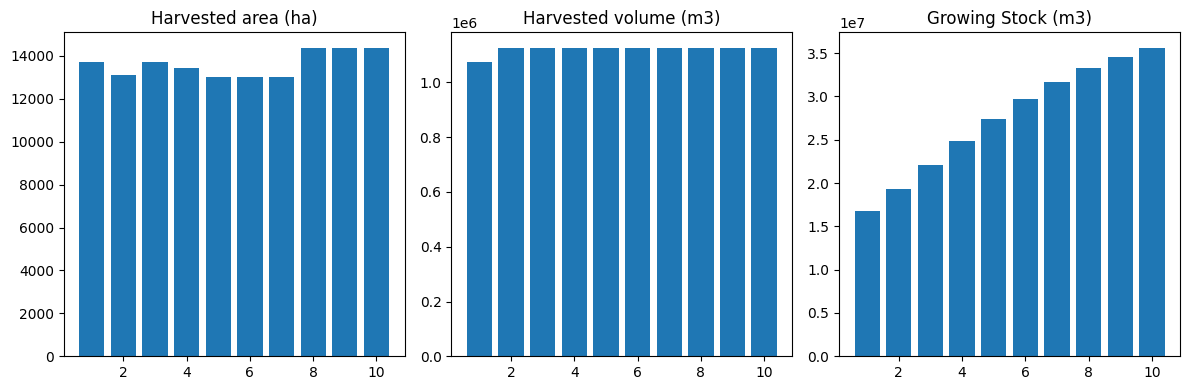

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


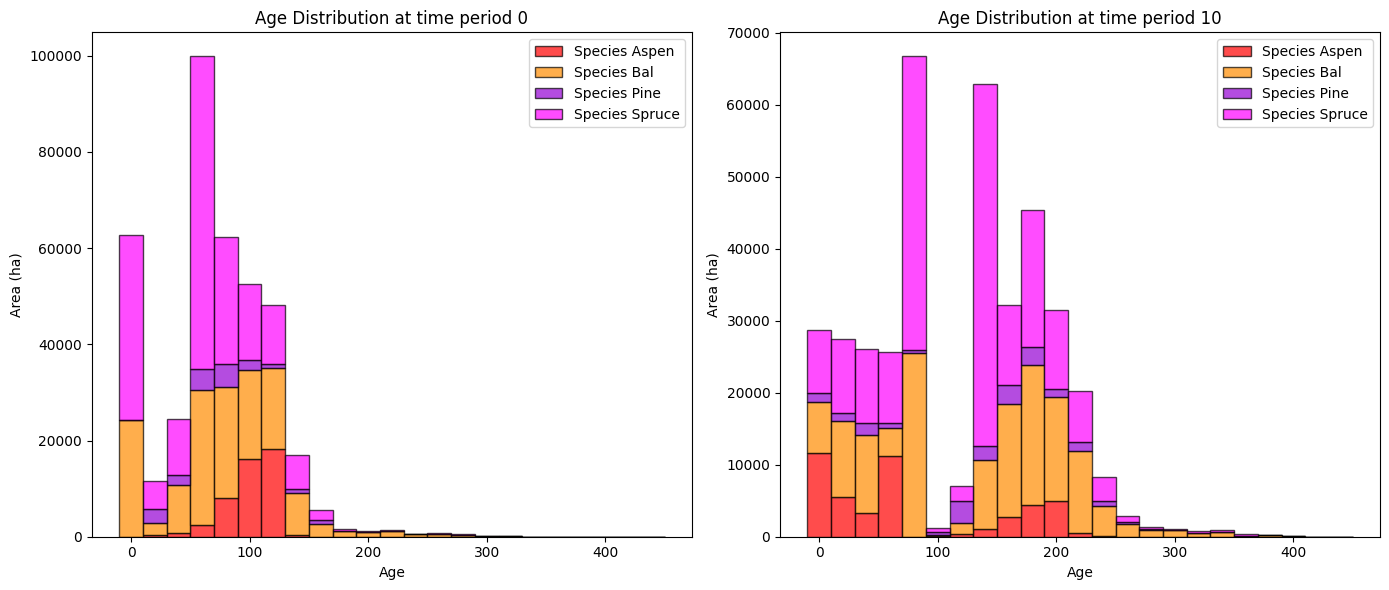

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


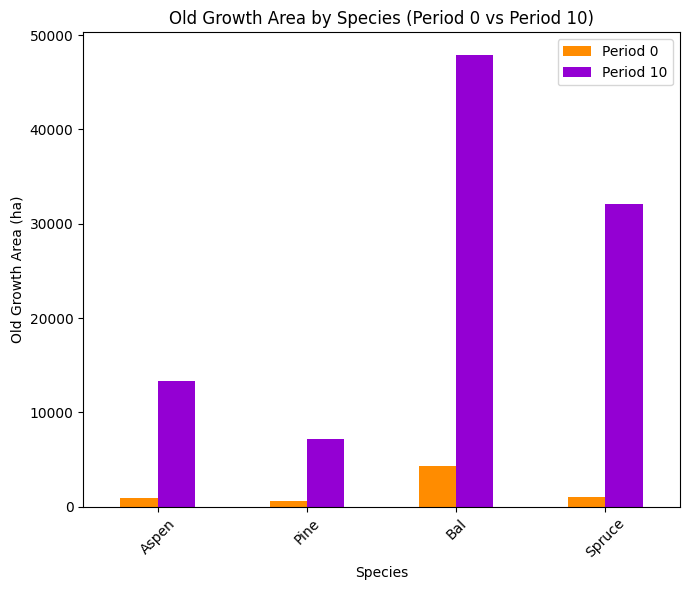

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


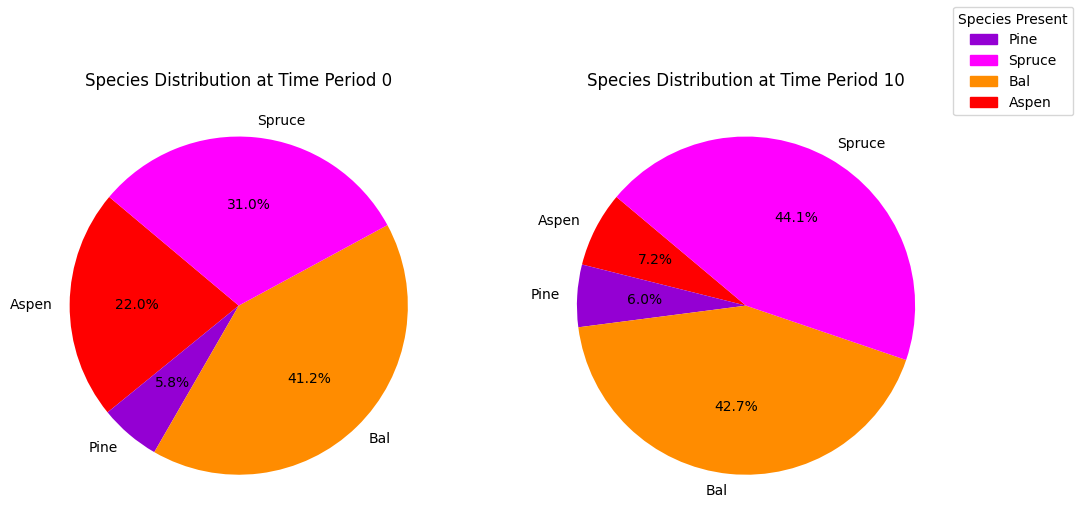

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


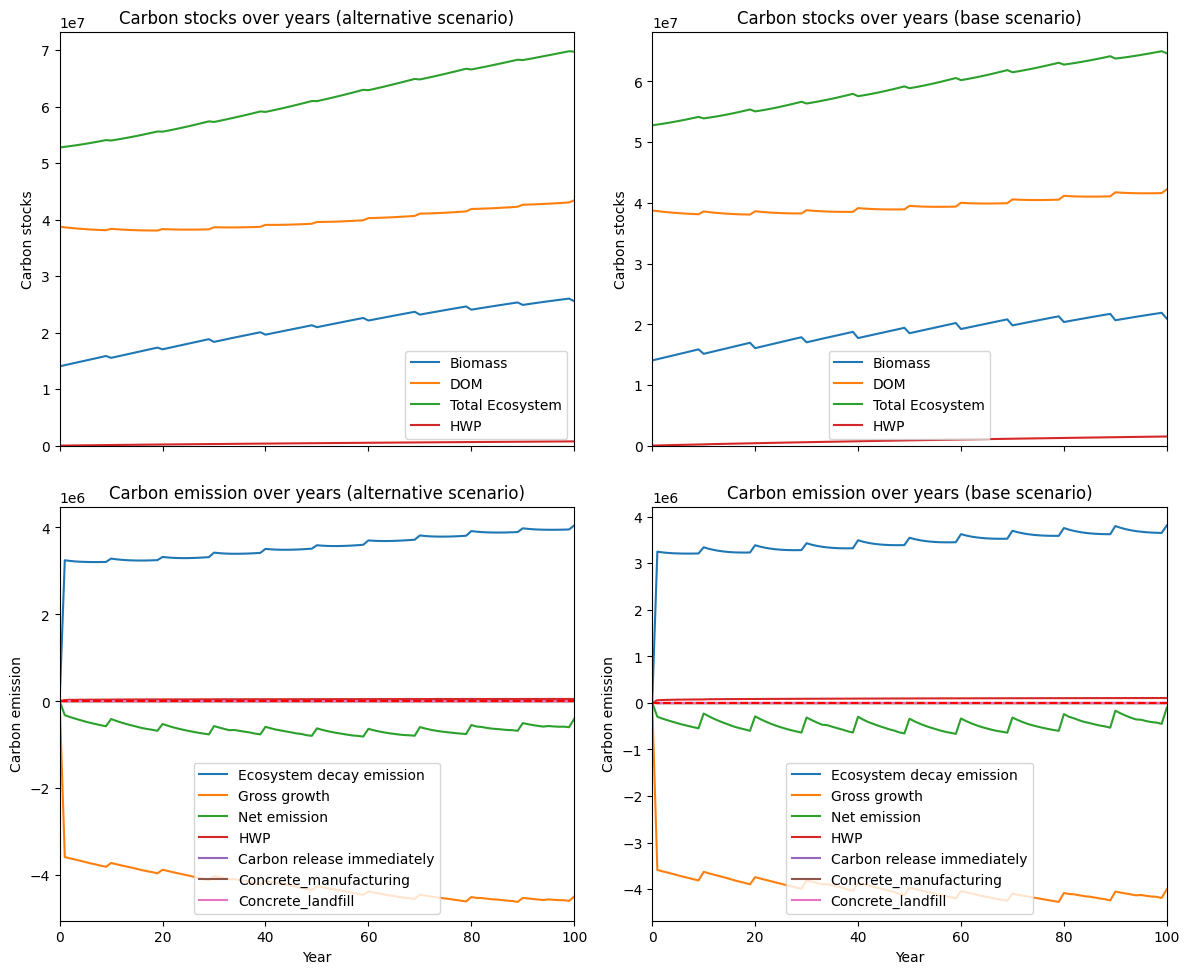

---------------------------------------------------------------------------------------
Net emission difference -18108672.957982924
Net emission base scenario -46083355.39637767
Net emission alternative scenario -64192028.35436059
dollar_per_ton is:  0.5522215804108195
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0   937.026524   937.026524
Pine    0.0  2036.448754  2036.448754
Bal     0.0  3964.846385  3964.846385
Spruce  0.0  7878.100067  7878.100067

Overall, the old growth area has **increased** by 14816.42 hectares in the alternative scenario compared to the base scenario.


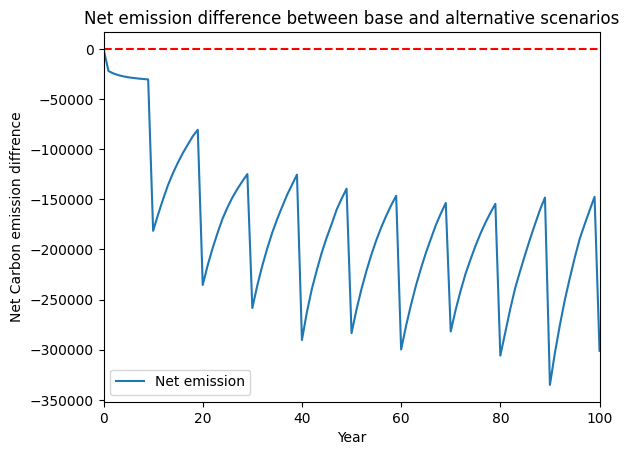

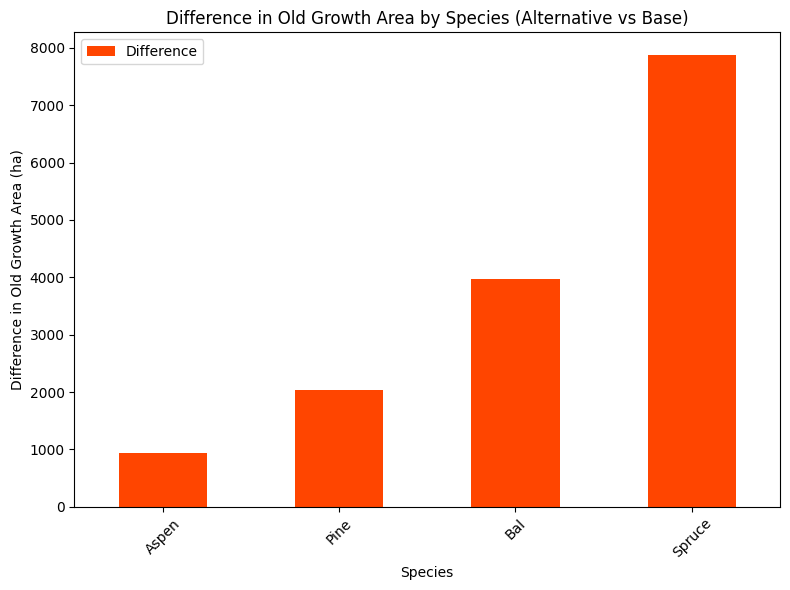

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


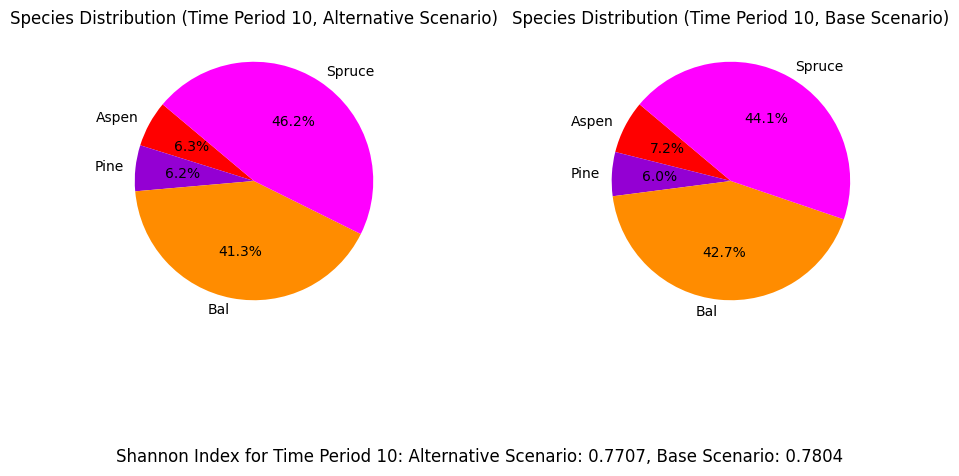

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for mining_site_3_max_hv_ms3_AAC_40%...
running the scenario for the mining site 3 (40%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xf1006c83
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.13s
Presolved: 1699 rows, 30867 col

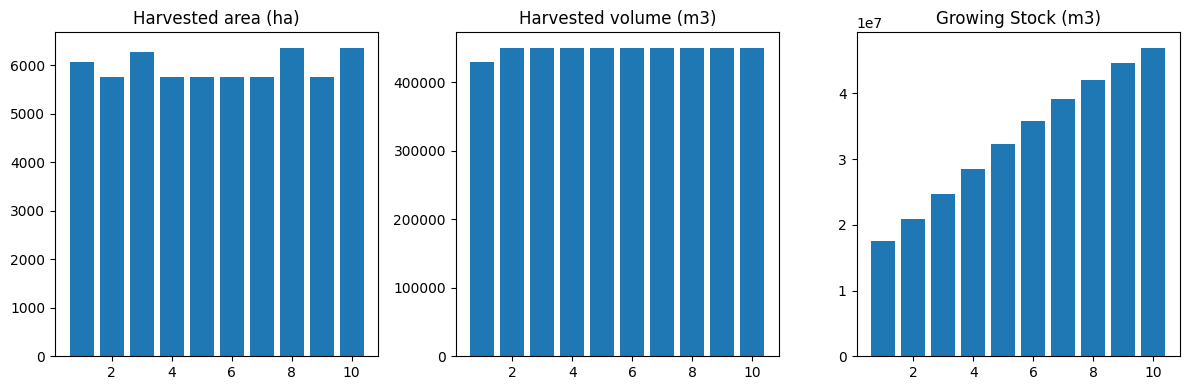

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_40%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  4741
The economic indicator (the provincial government revenues) is:  161682
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


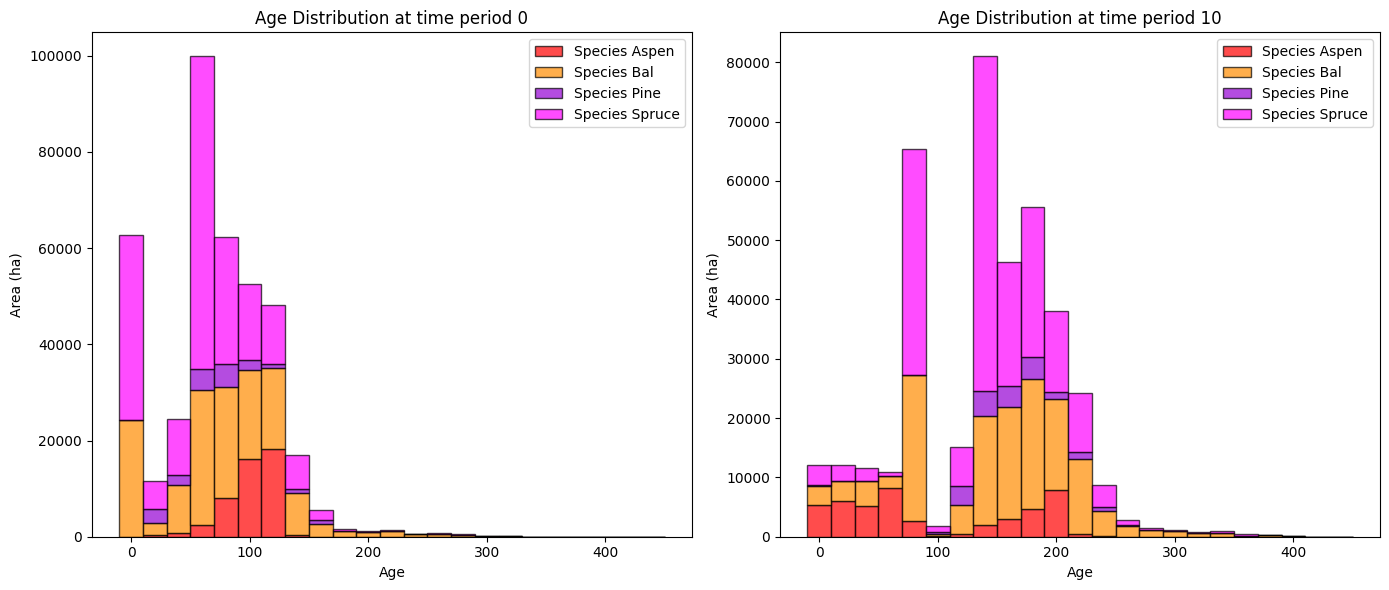

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_40%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  16941.198811  15995.885123
Pine     602.782616   9364.421082   8761.638466
Bal     4315.588546  52193.590457  47878.001911
Spruce  1072.814408  41436.275558  40363.461150

Old growth has **increased** by 112998.99 hectares from time period 0 to time period 10.


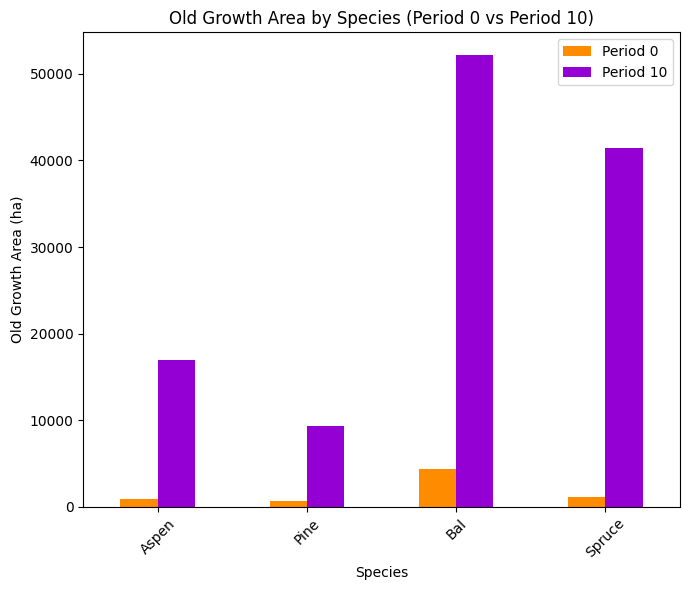

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_40%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7725

Diversity has **decreased** by 11.23% from time 0 to time 10.


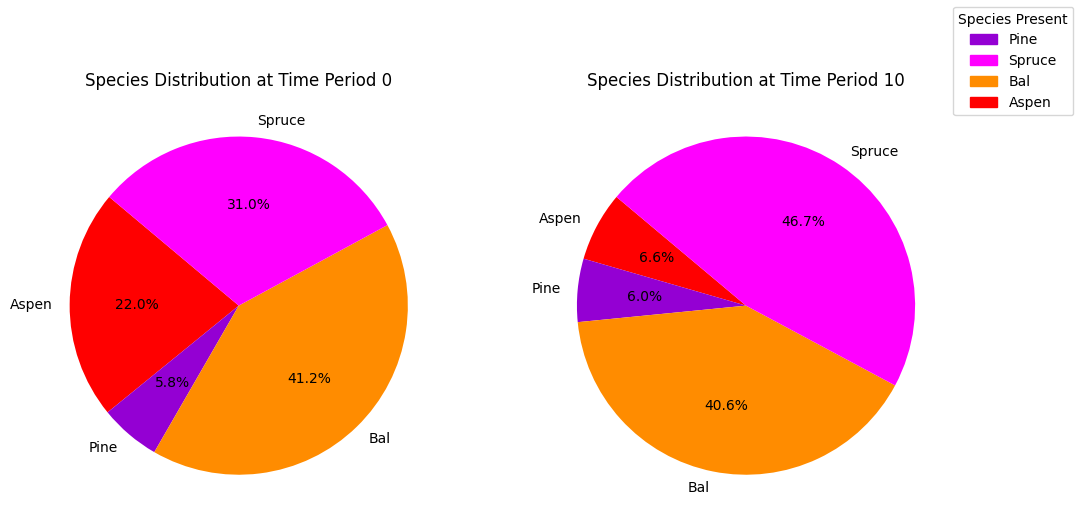

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_40%_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.12s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0

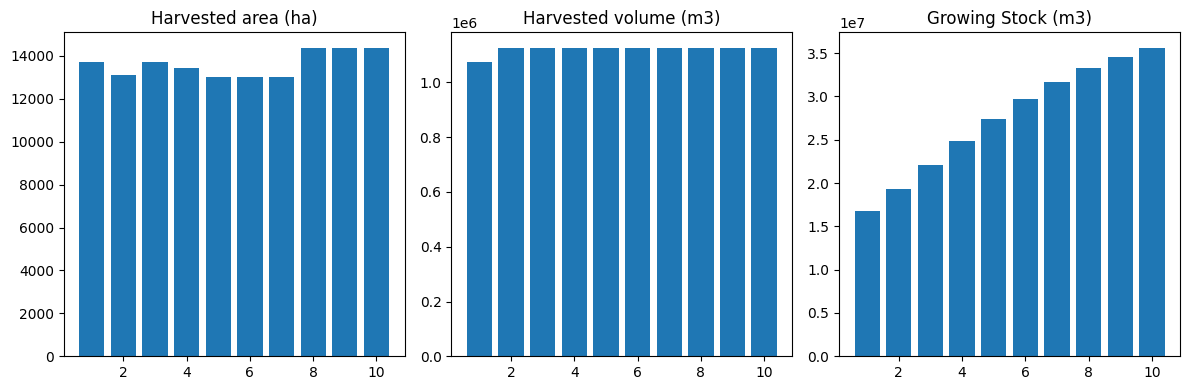

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


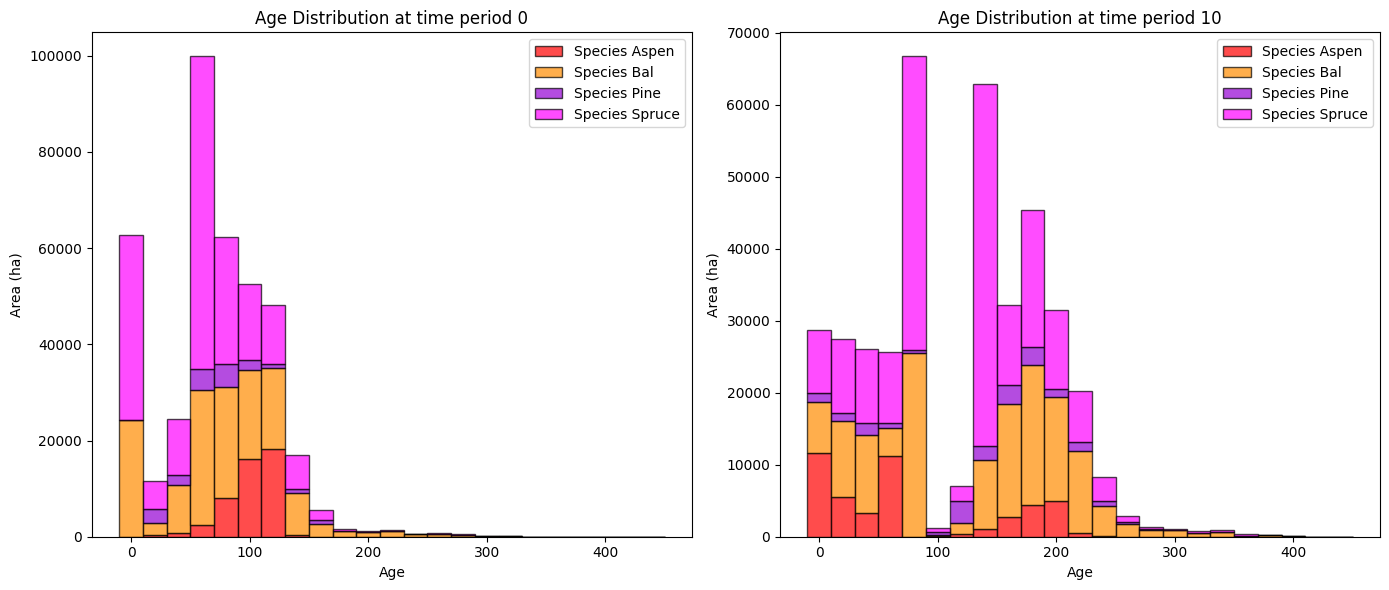

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


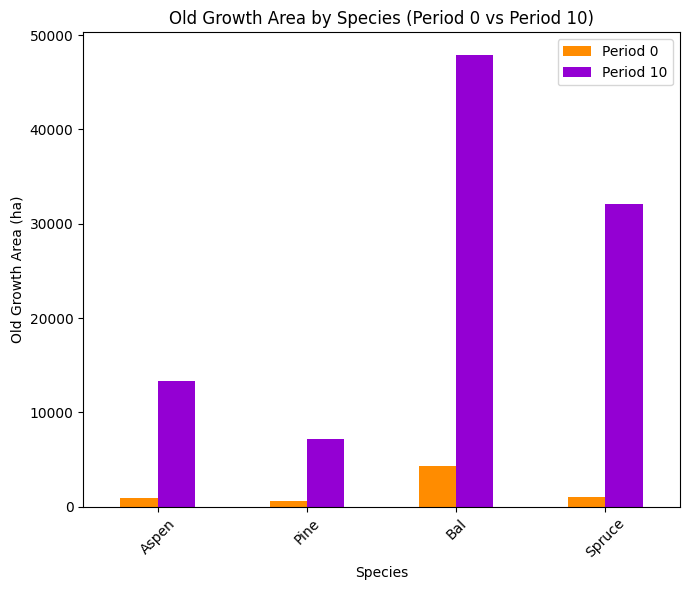

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


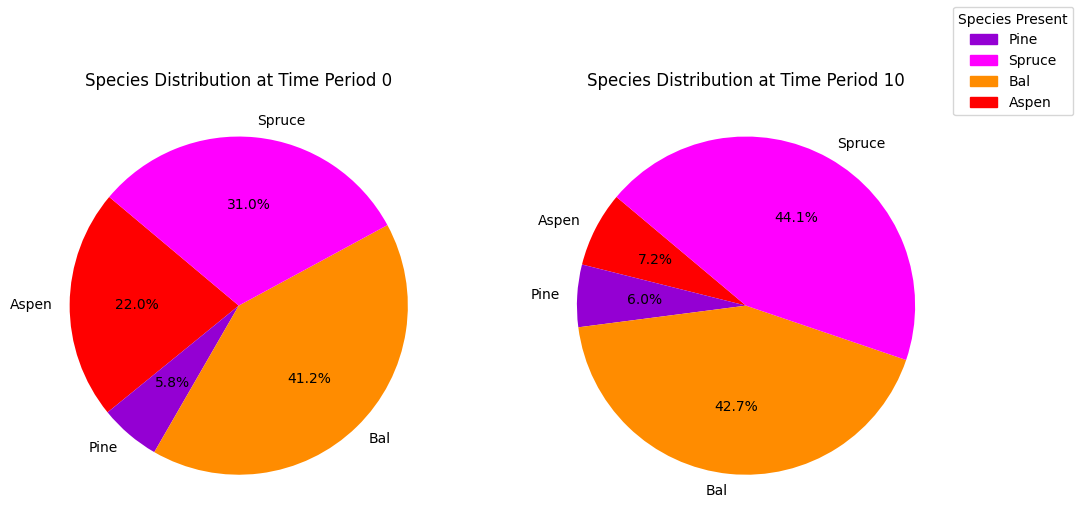

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


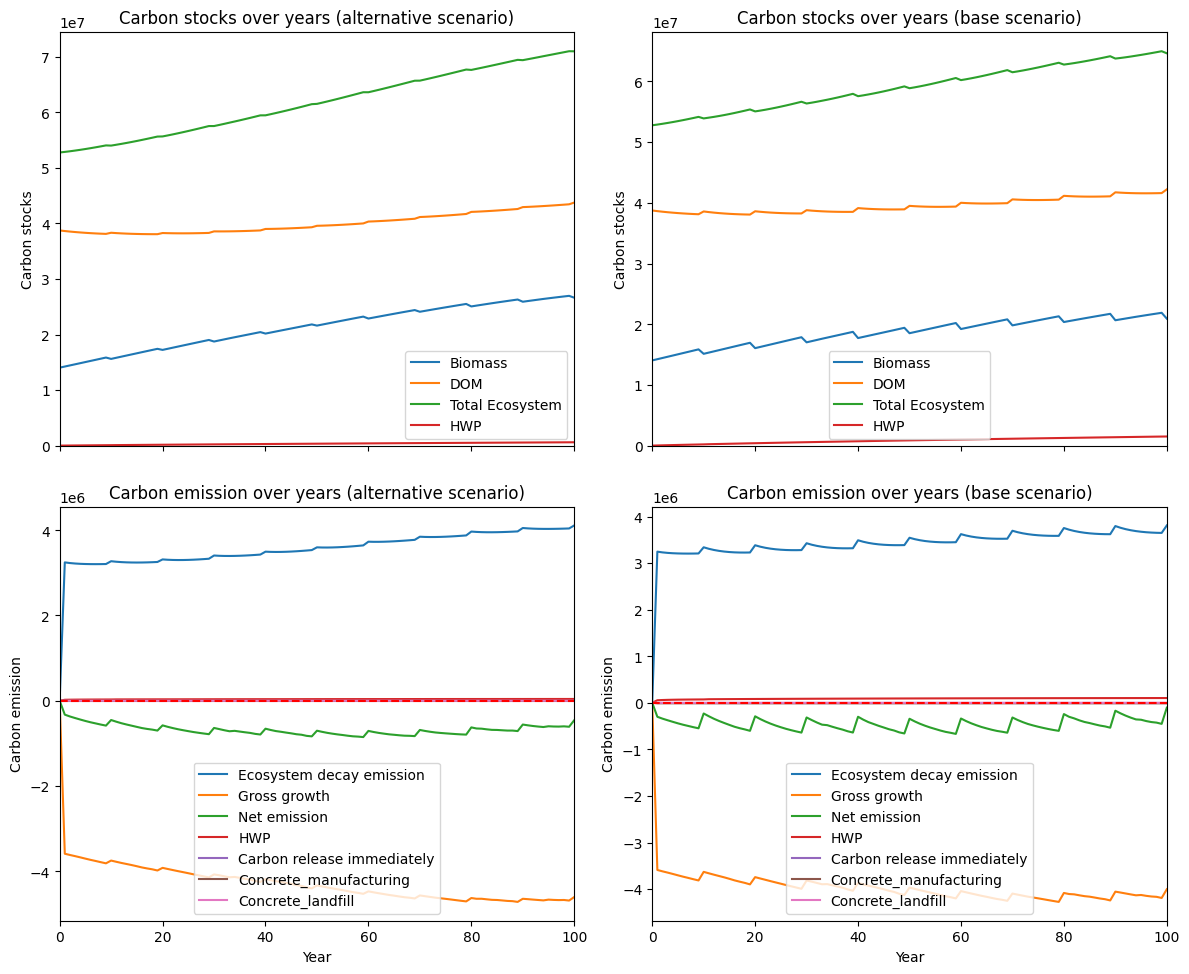

---------------------------------------------------------------------------------------
Net emission difference -22245474.19780057
Net emission base scenario -46083355.39637767
Net emission alternative scenario -68328829.59417821
dollar_per_ton is:  0.4495296396508693
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0  3654.214680  3654.214680
Pine    0.0  2183.434670  2183.434670
Bal     0.0  4300.830133  4300.830133
Spruce  0.0  9395.343637  9395.343637

Overall, the old growth area has **increased** by 19533.82 hectares in the alternative scenario compared to the base scenario.


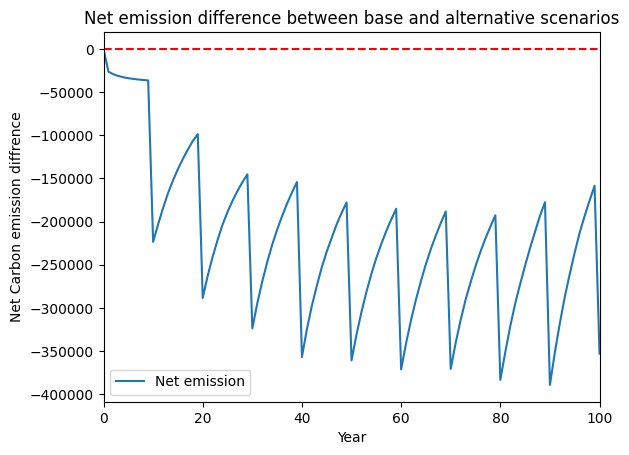

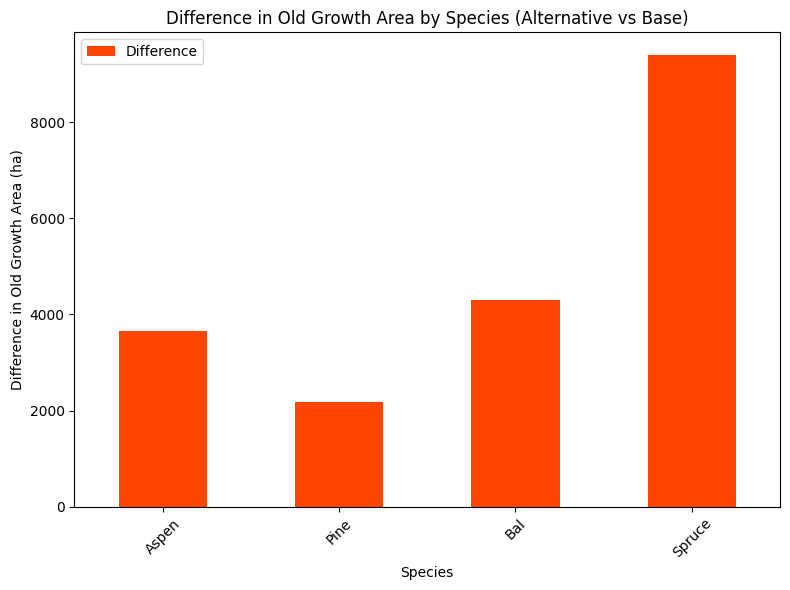

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


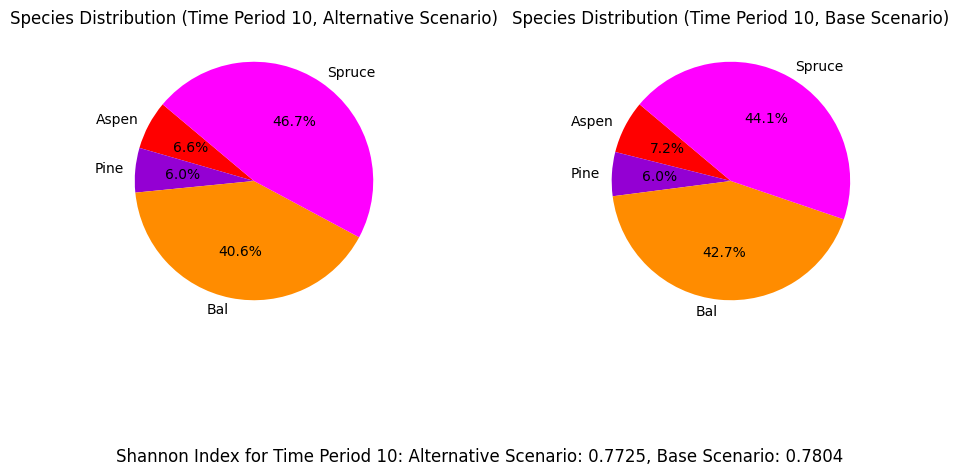

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for mining_site_3_max_hv_ms3_AAC_30%...
running the scenario for the  mining site 3 (30%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xa316f686
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.14s
Presolved: 1699 rows, 30867 co

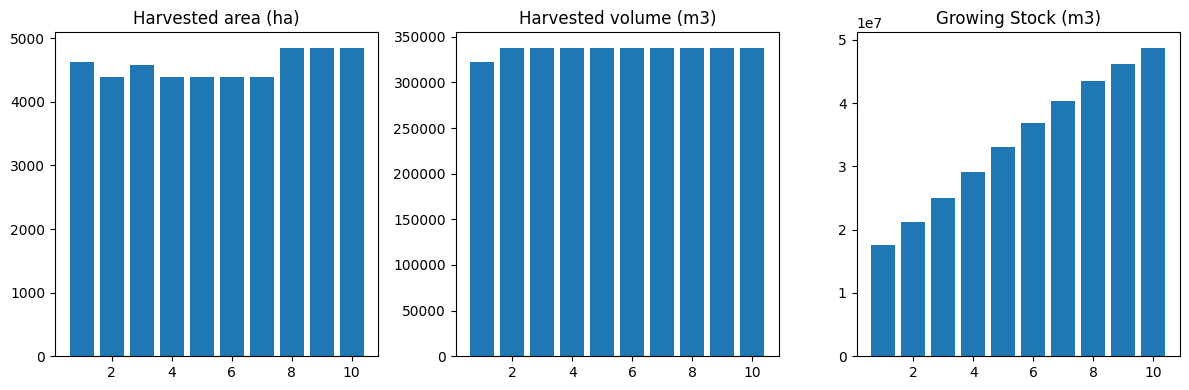

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_30%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  3555
The economic indicator (the provincial government revenues) is:  121262
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


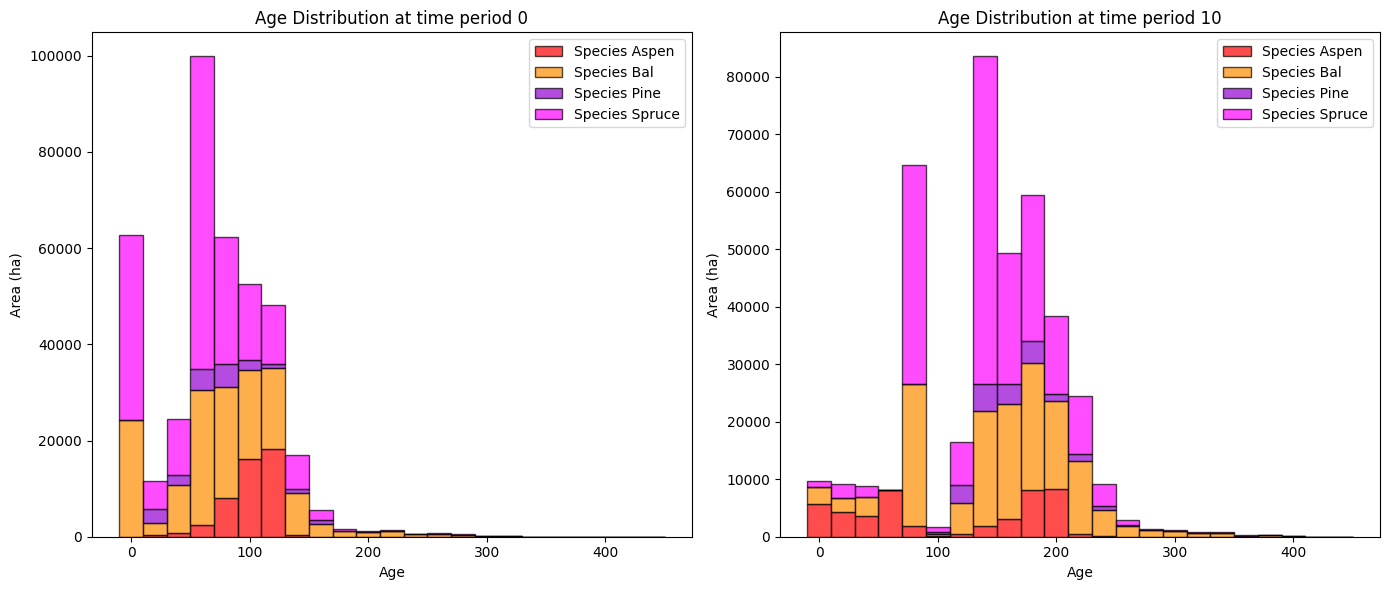

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_30%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  20847.995518  19902.681830
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  52741.950632  48426.362086
Spruce  1072.814408  41754.254469  40681.440062

Old growth has **increased** by 117797.69 hectares from time period 0 to time period 10.


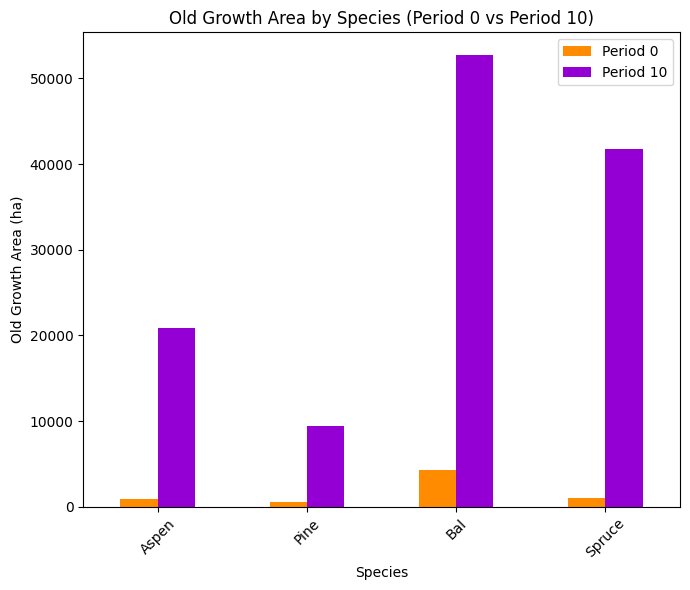

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_30%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7810

Diversity has **decreased** by 10.38% from time 0 to time 10.


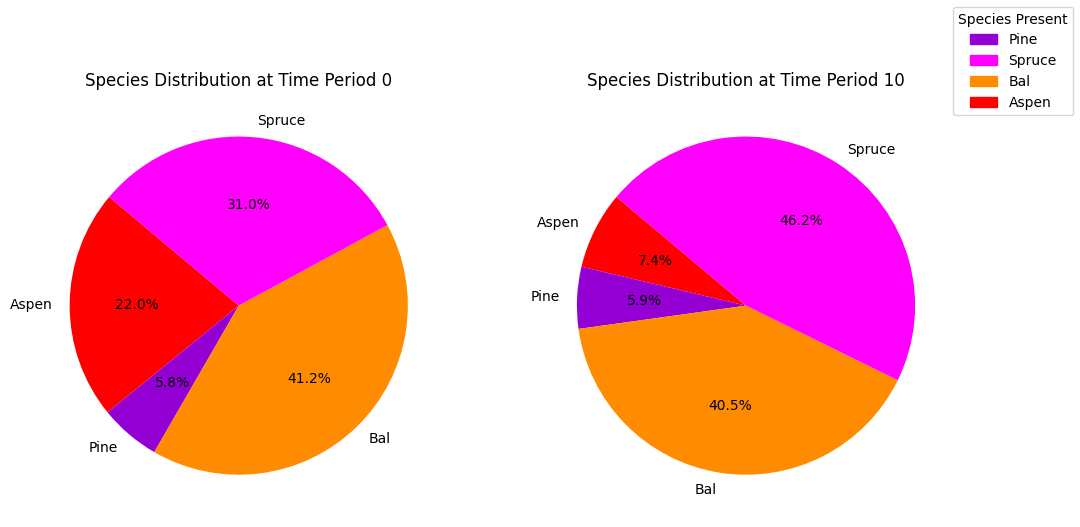

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_30%_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.13s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0

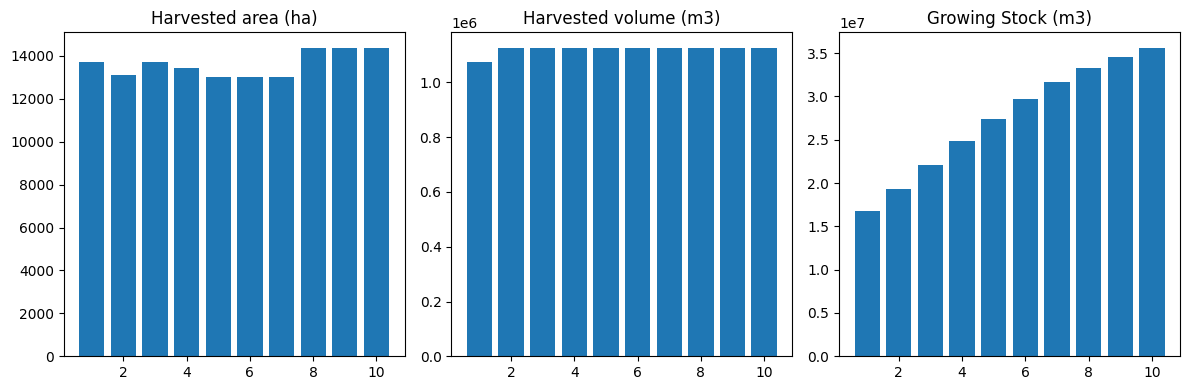

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


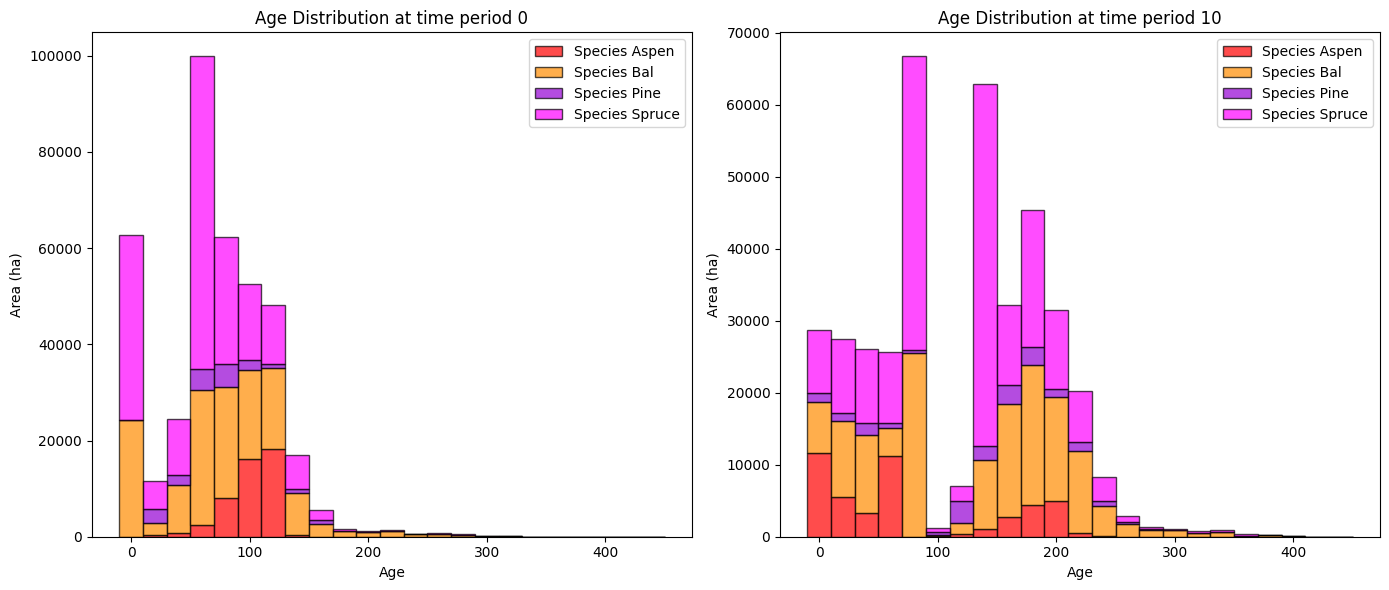

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


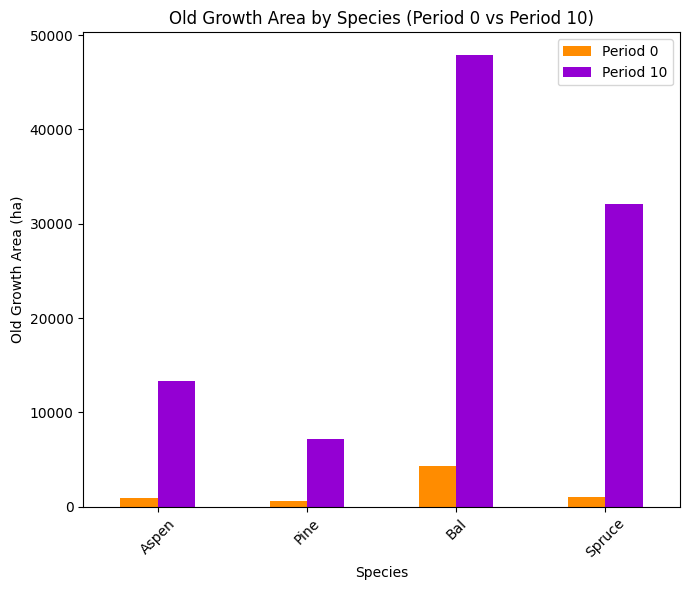

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


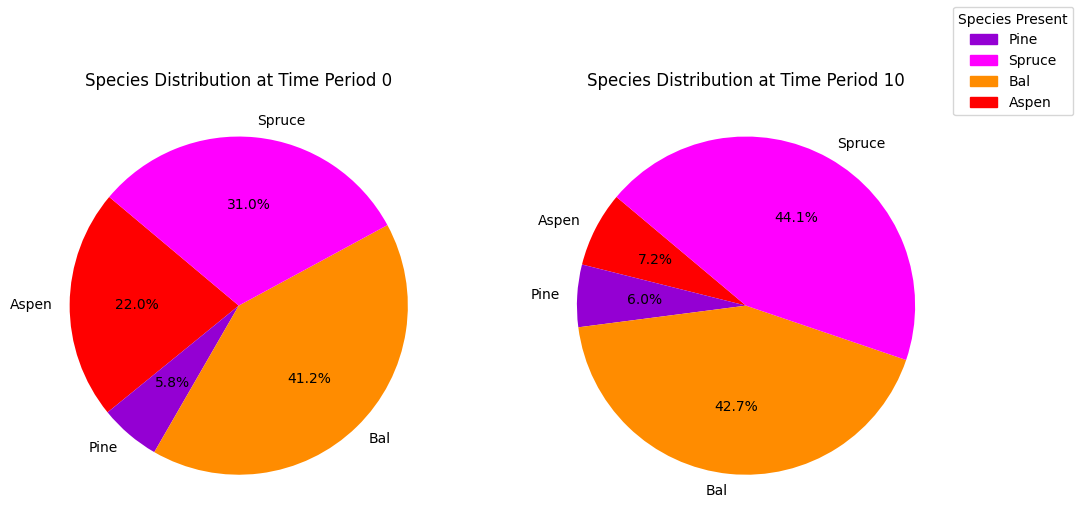

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


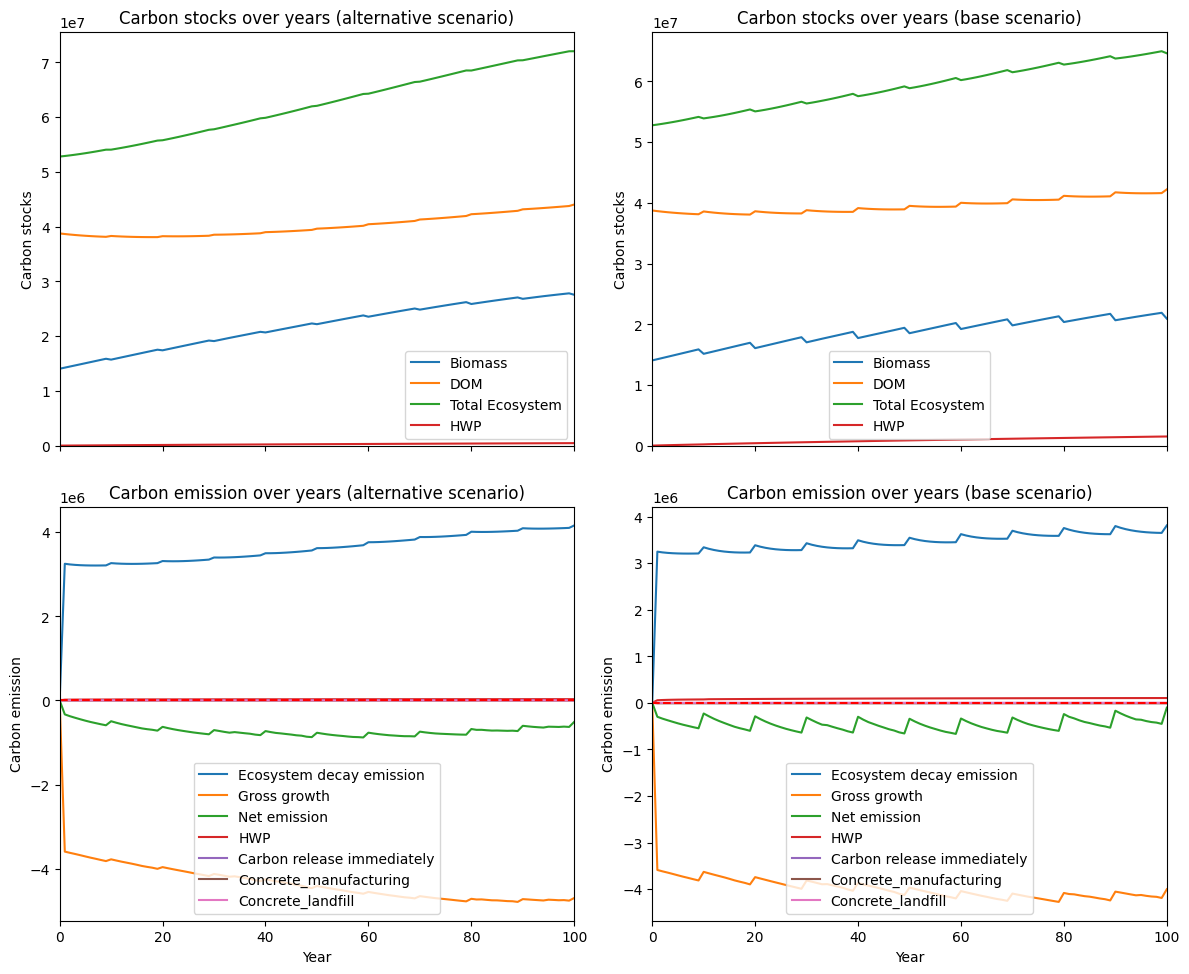

---------------------------------------------------------------------------------------
Net emission difference -25632186.590267
Net emission base scenario -46083355.39637767
Net emission alternative scenario -71715541.98664466
dollar_per_ton is:  0.3901344883232545
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0  7561.011388  7561.011388
Pine    0.0  2208.999860  2208.999860
Bal     0.0  4849.190308  4849.190308
Spruce  0.0  9713.322549  9713.322549

Overall, the old growth area has **increased** by 24332.52 hectares in the alternative scenario compared to the base scenario.


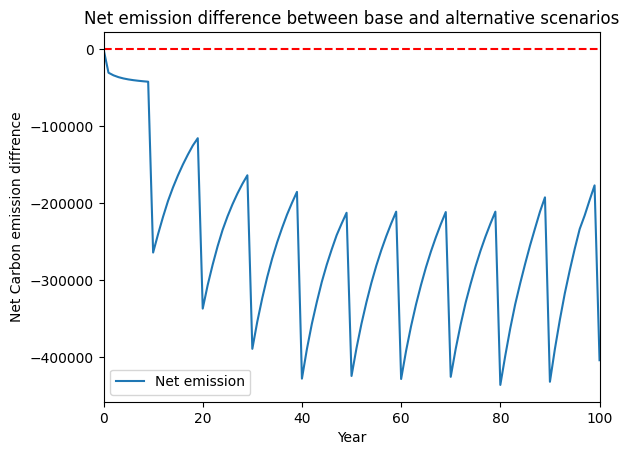

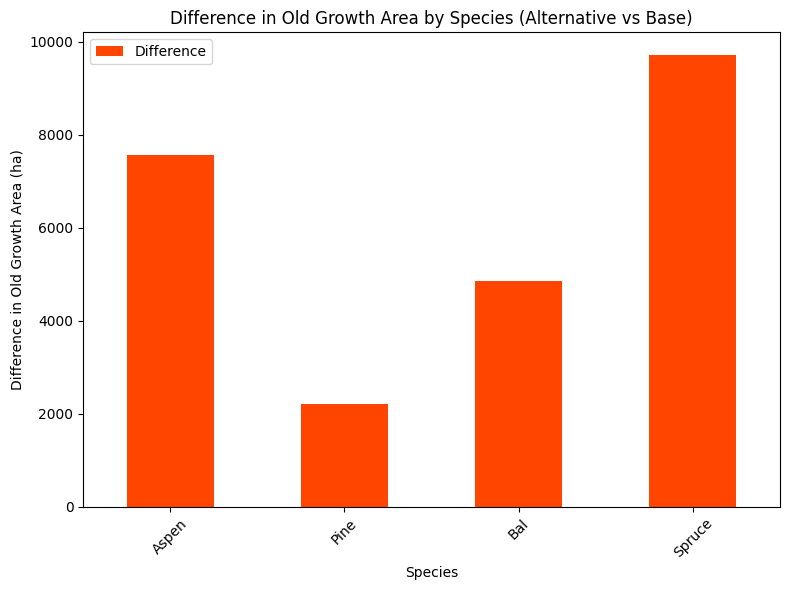

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


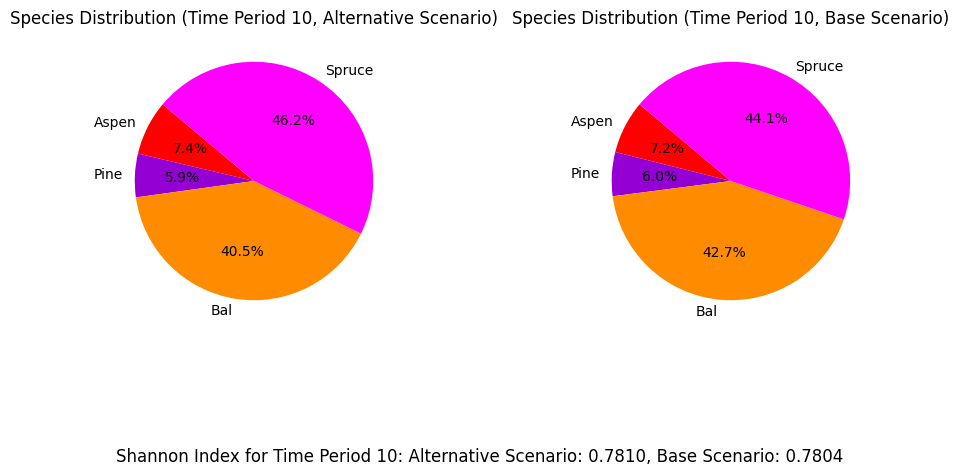

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for mining_site_3_max_hv_ms3_AAC_20%...
running the scenario for the  mining site 3 (20%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x8ce551ef
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.18s
Presolved: 1699 rows, 30867 co

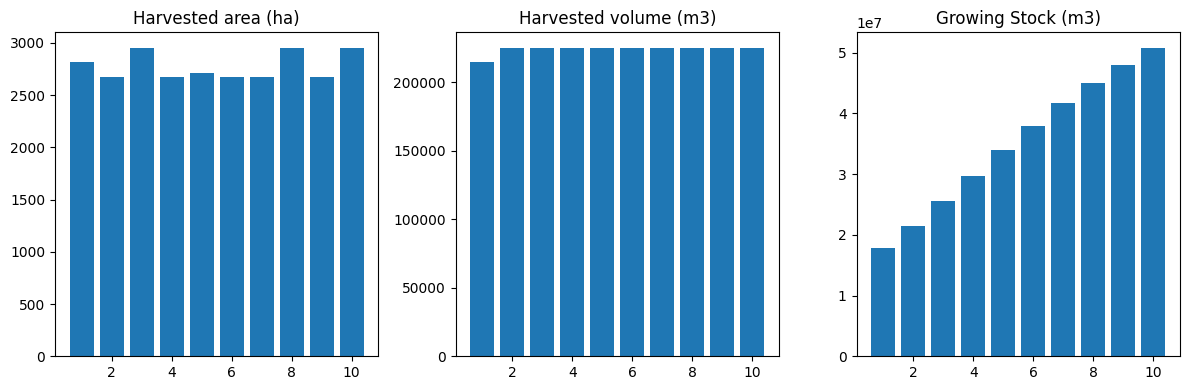

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_20%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  2370
The economic indicator (the provincial government revenues) is:  80841
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


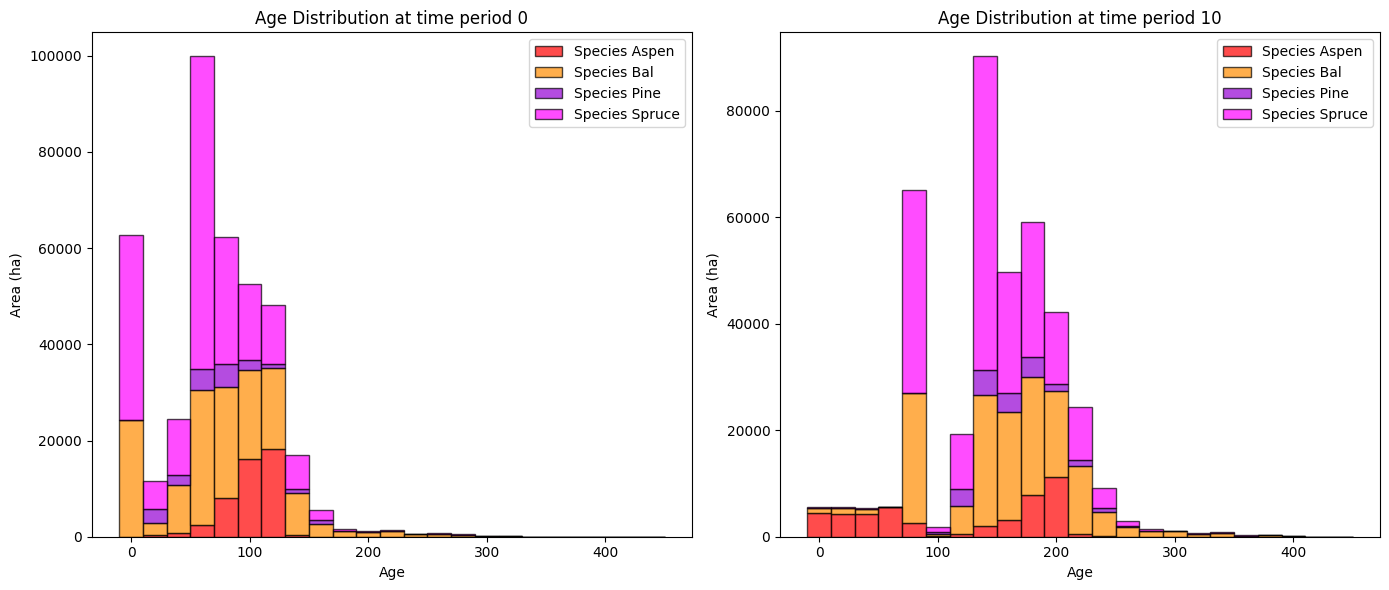

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_20%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  23525.257196  22579.943508
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  53579.735001  49264.146455
Spruce  1072.814408  41791.198387  40718.383979

Old growth has **increased** by 121349.68 hectares from time period 0 to time period 10.


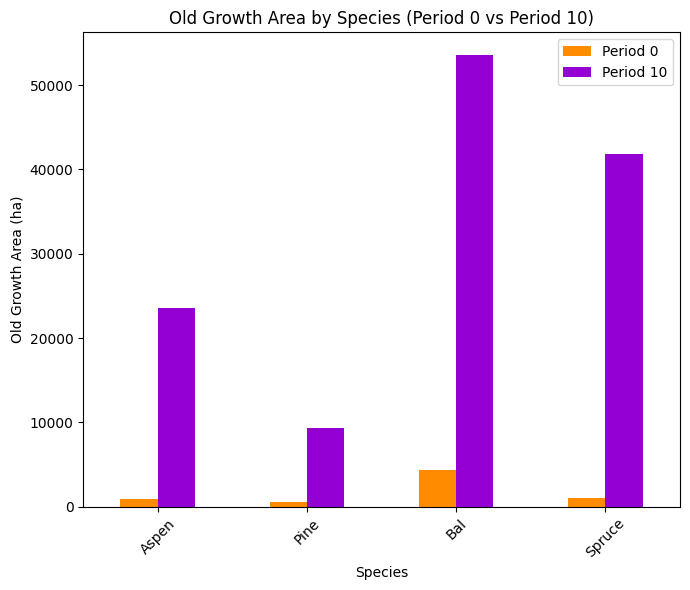

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_20%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.44% from time 0 to time 10.


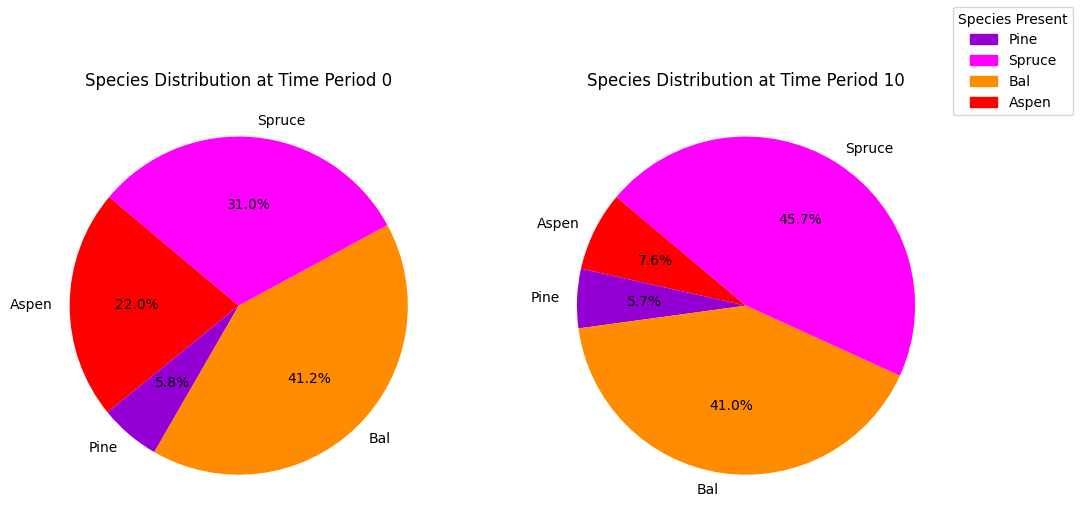

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_20%_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.12s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0

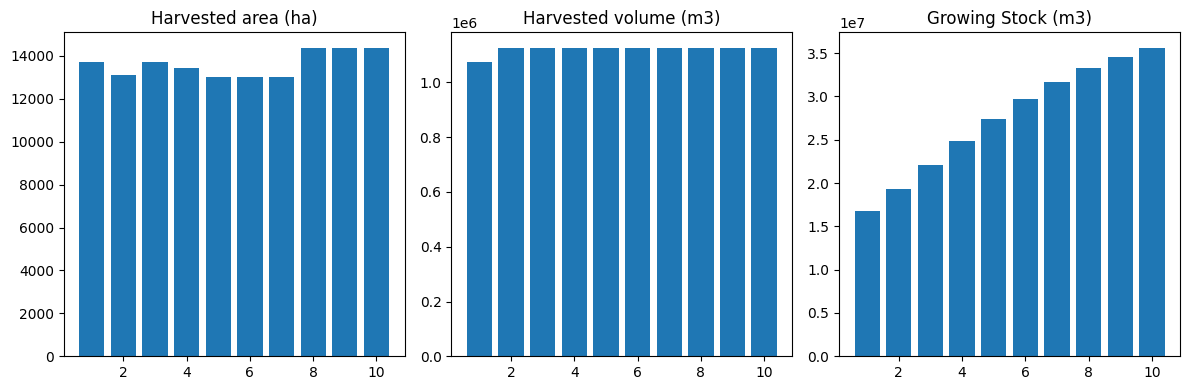

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


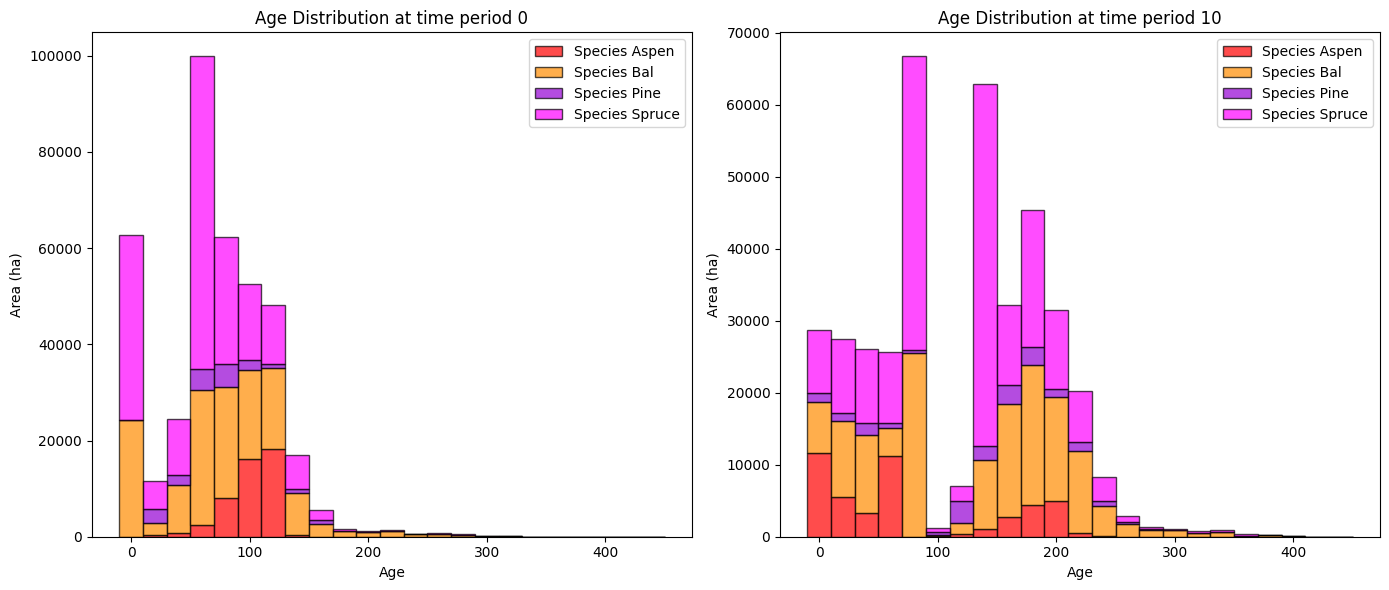

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


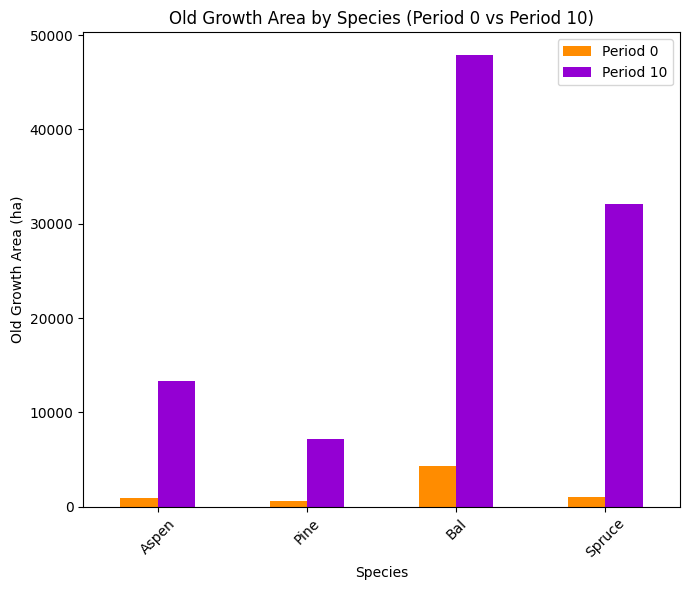

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


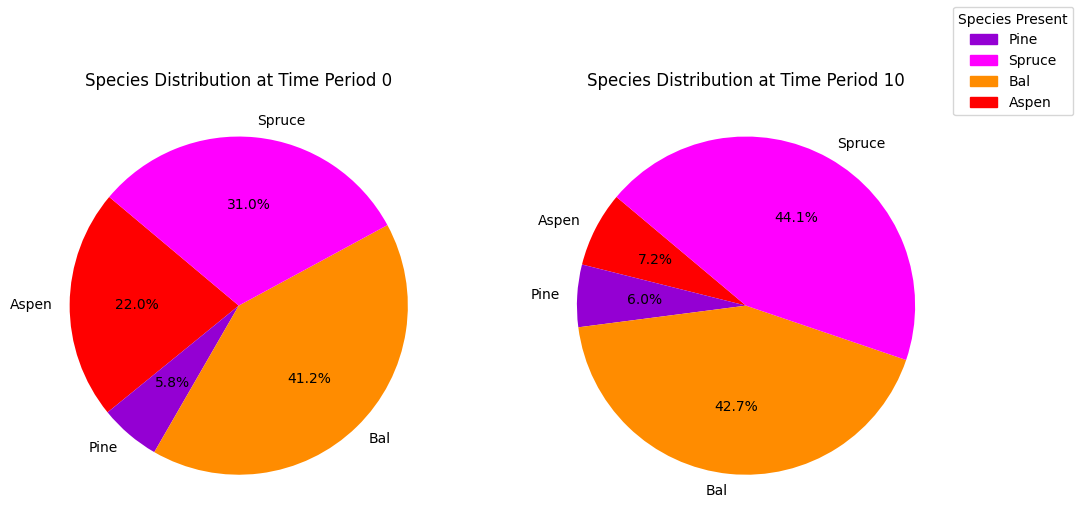

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


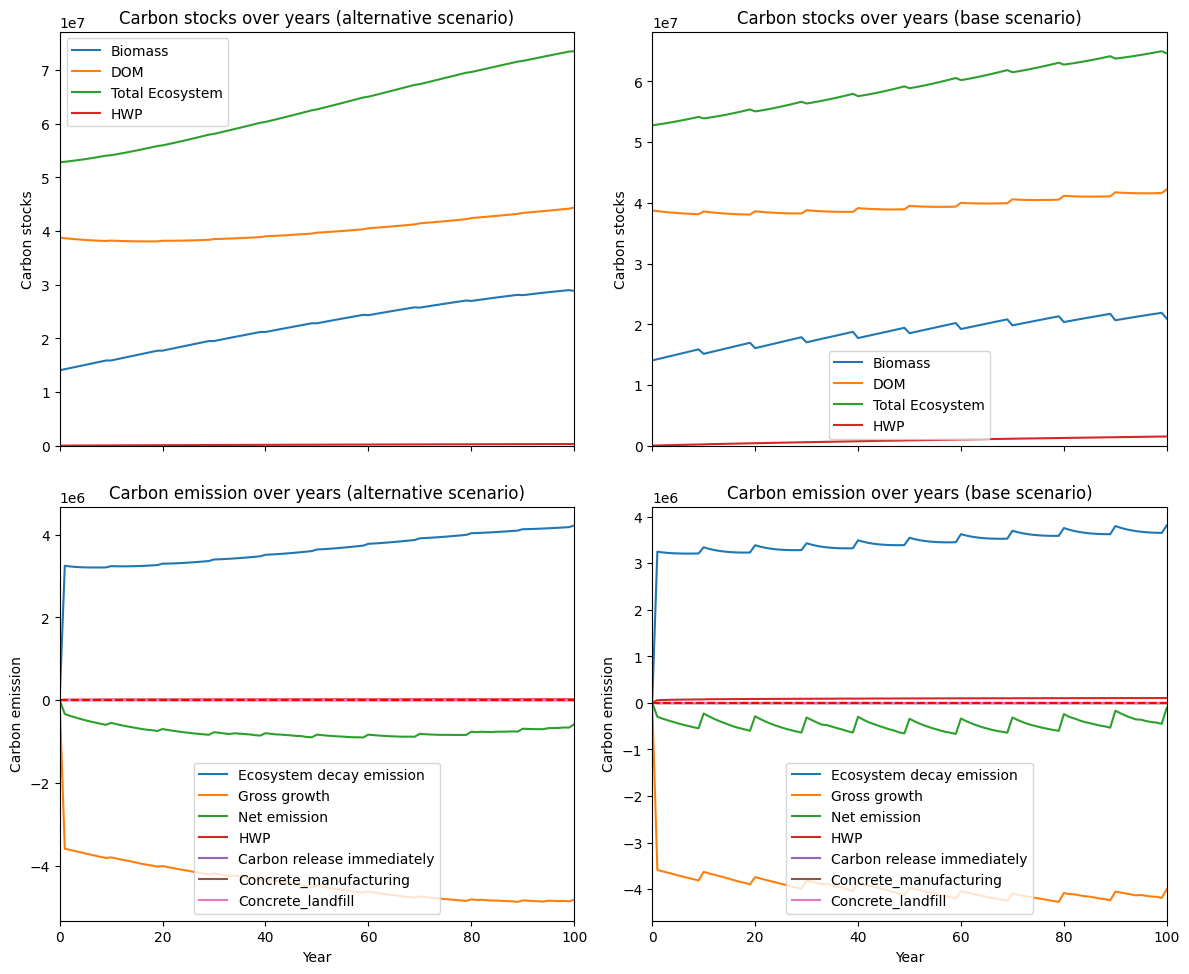

---------------------------------------------------------------------------------------
Net emission difference -30029392.001662984
Net emission base scenario -46083355.39637767
Net emission alternative scenario -76112747.39804064
dollar_per_ton is:  0.3330070751830811
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  10238.273065  10238.273065
Pine    0.0   2208.999860   2208.999860
Bal     0.0   5686.974676   5686.974676
Spruce  0.0   9750.266467   9750.266467

Overall, the old growth area has **increased** by 27884.51 hectares in the alternative scenario compared to the base scenario.


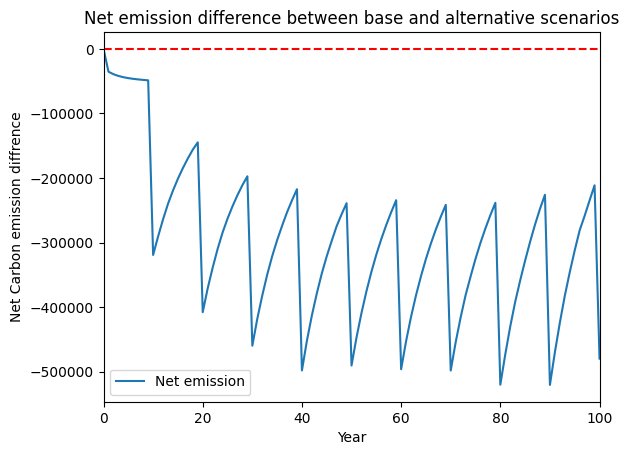

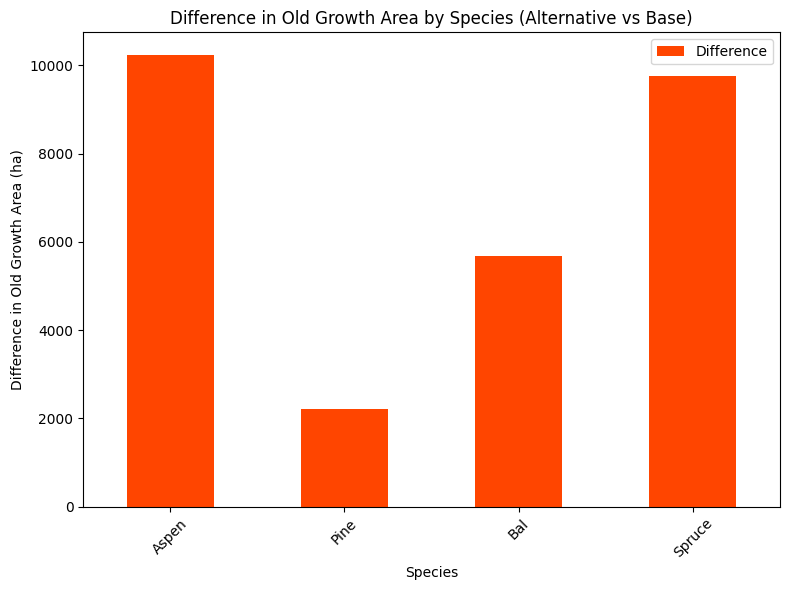

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


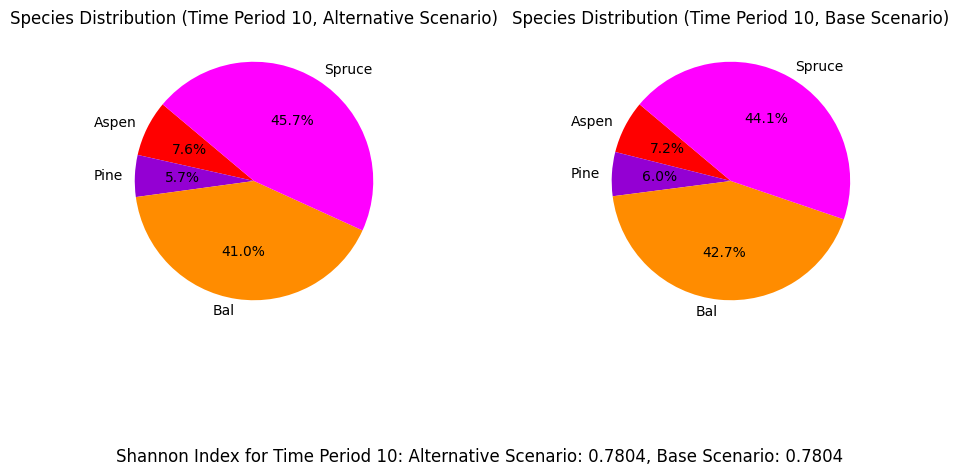

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for mining_site_3_max_hv_ms3_AAC_10%...
running the scenario for the mining site 3 (10%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xfd7d3b40
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.12s
Presolved: 1699 rows, 30867 col

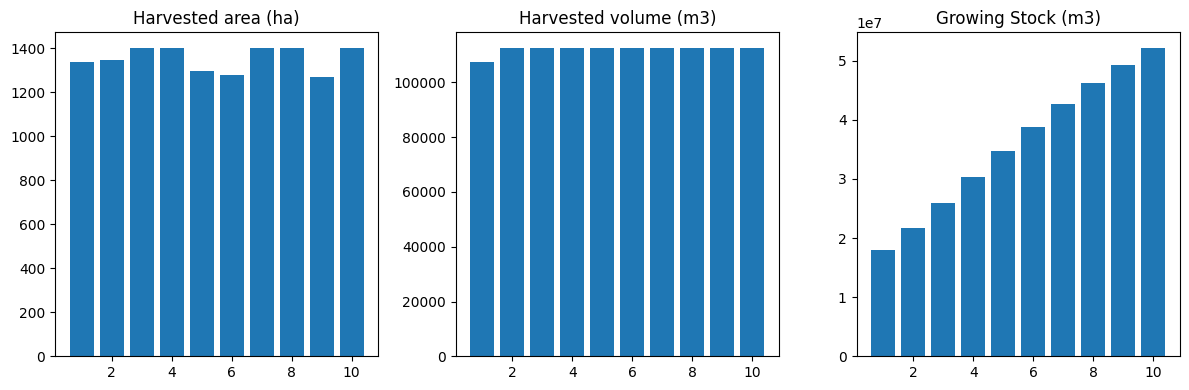

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_10%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  1185
The economic indicator (the provincial government revenues) is:  40420
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


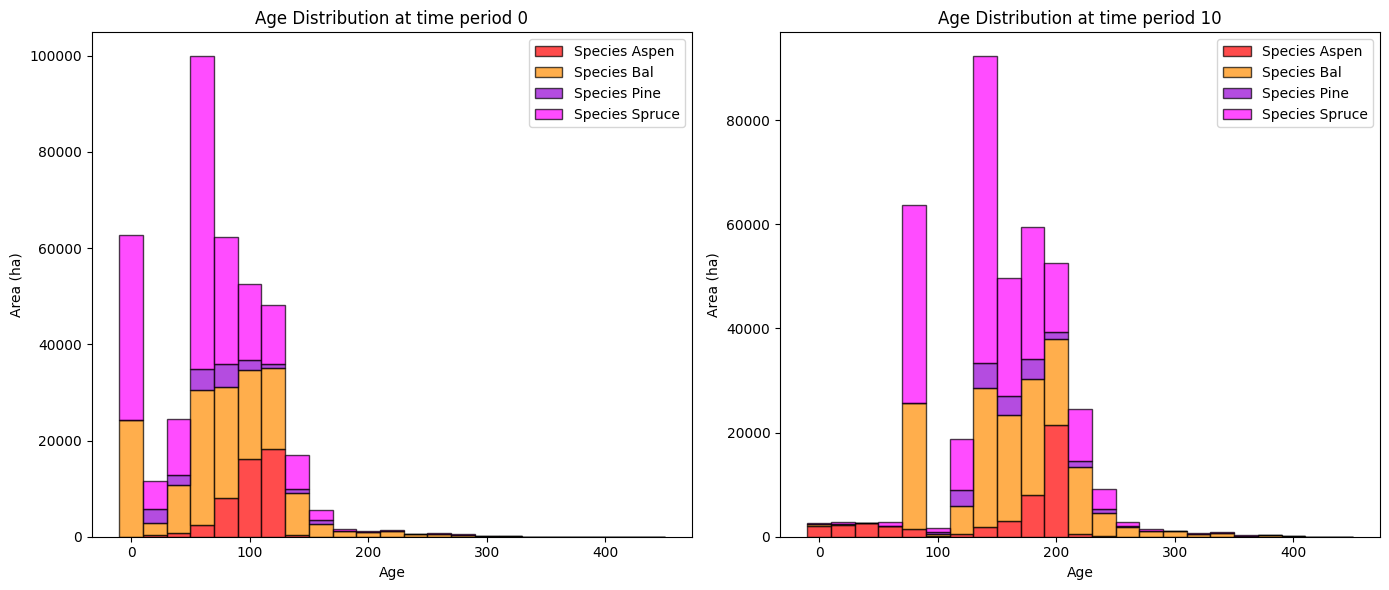

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_10%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  34157.749172  33212.435484
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  54087.103674  49771.515128
Spruce  1072.814408  41544.331677  40471.517269

Old growth has **increased** by 132242.67 hectares from time period 0 to time period 10.


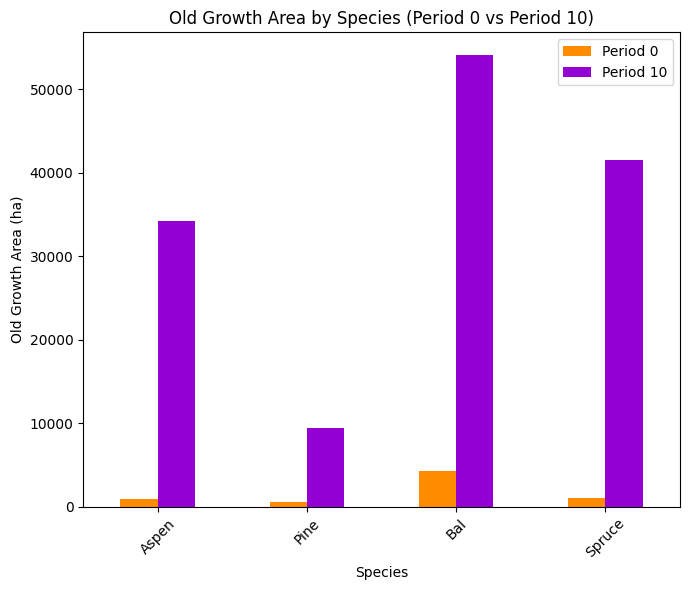

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_10%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7985

Diversity has **decreased** by 8.63% from time 0 to time 10.


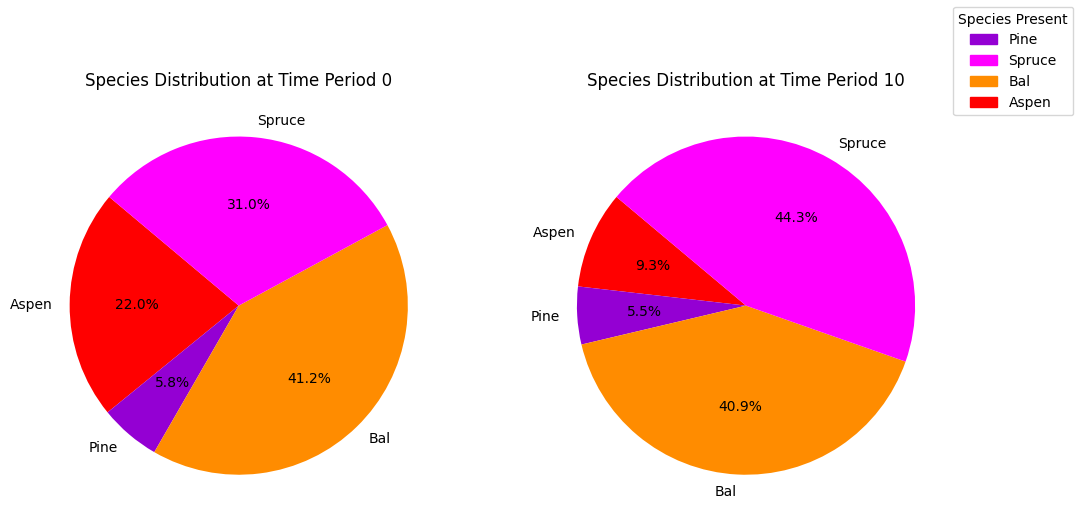

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_ms3_AAC_10%_species_pie.pdf
running business as usual scenario for the mining site, 3
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4976d622
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 3667 columns
Presolve time: 0.13s
Presolved: 1699 rows, 30866 columns, 420629 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0

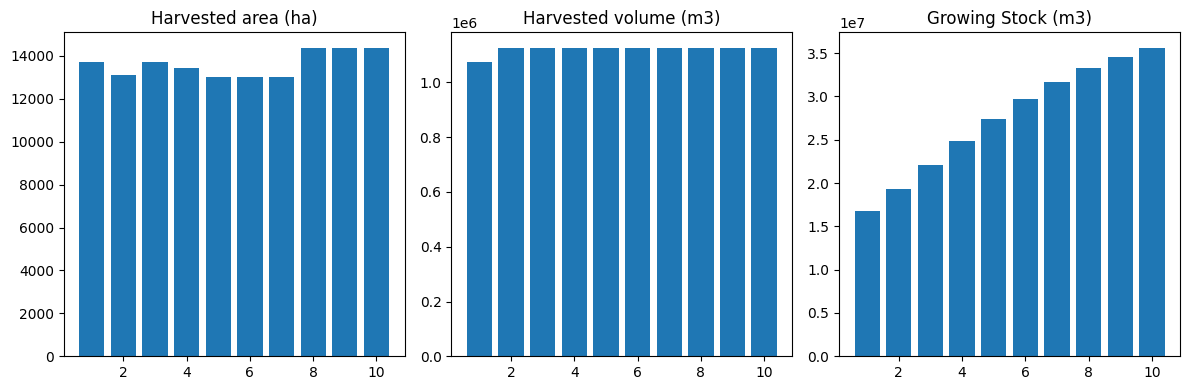

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  11852
The economic indicator (the provincial government revenues) is:  404205
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


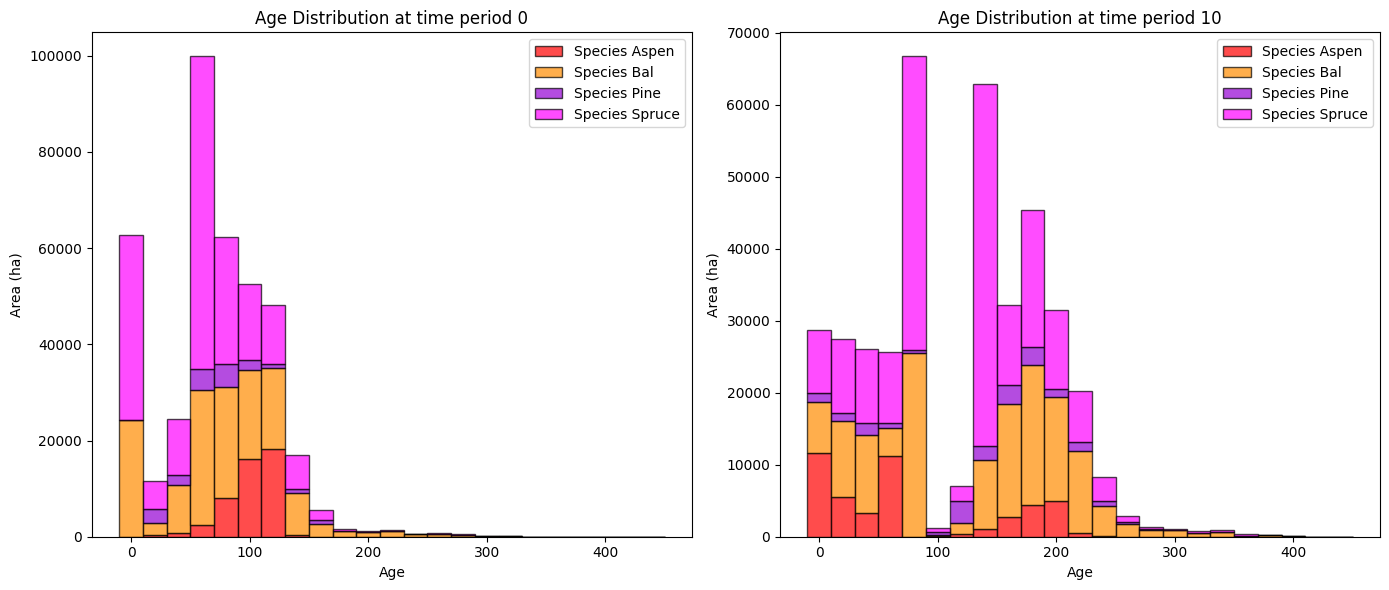

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  13286.984131  12341.670443
Pine     602.782616   7180.986413   6578.203796
Bal     4315.588546  47892.760325  43577.171778
Spruce  1072.814408  32040.931920  30968.117513

Old growth has **increased** by 93465.16 hectares from time period 0 to time period 10.


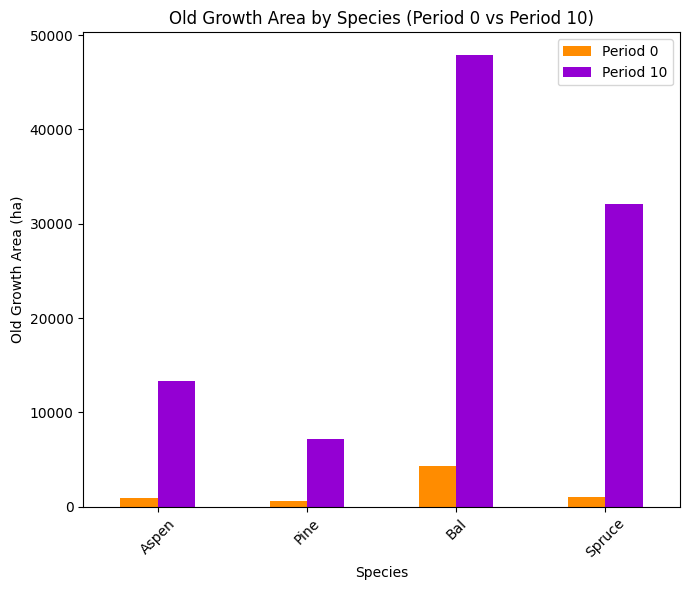

Clustered column plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7804

Diversity has **decreased** by 10.45% from time 0 to time 10.


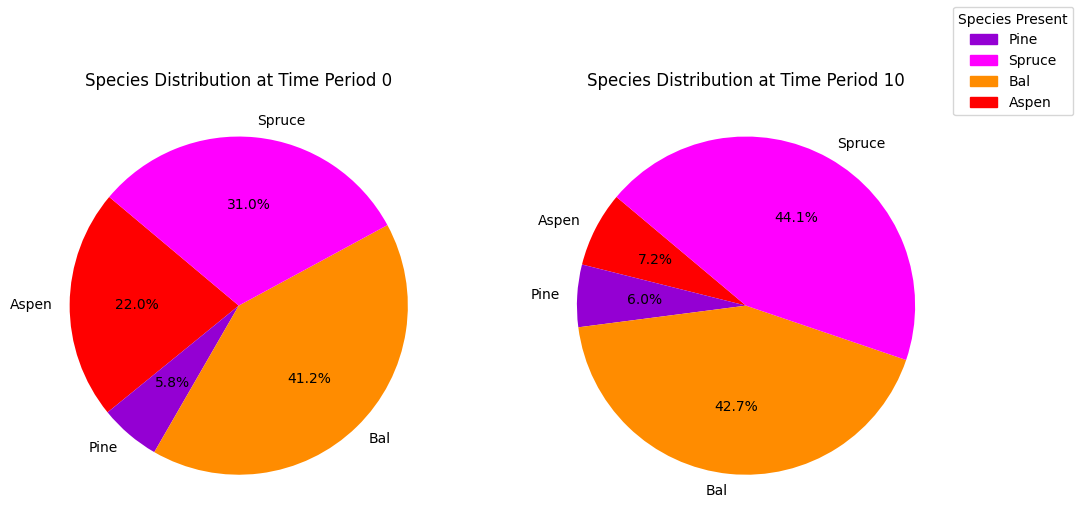

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_bau_ms3_species_pie.pdf


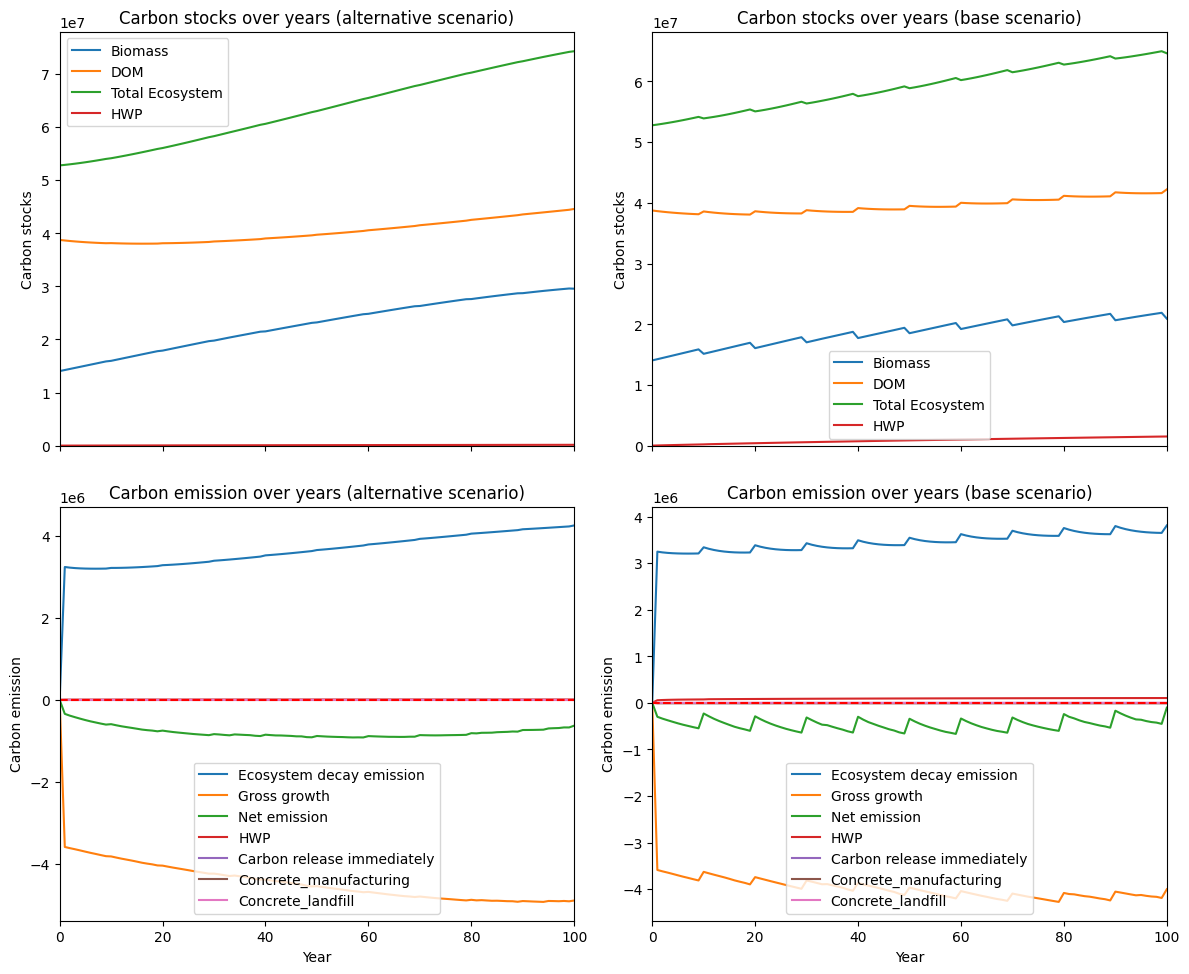

---------------------------------------------------------------------------------------
Net emission difference -32851442.33567895
Net emission base scenario -46083355.39637767
Net emission alternative scenario -78934797.7320566
dollar_per_ton is:  0.30440063781124477
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  20870.765041  20870.765041
Pine    0.0   2208.999860   2208.999860
Bal     0.0   6194.343350   6194.343350
Spruce  0.0   9503.399757   9503.399757

Overall, the old growth area has **increased** by 38777.51 hectares in the alternative scenario compared to the base scenario.


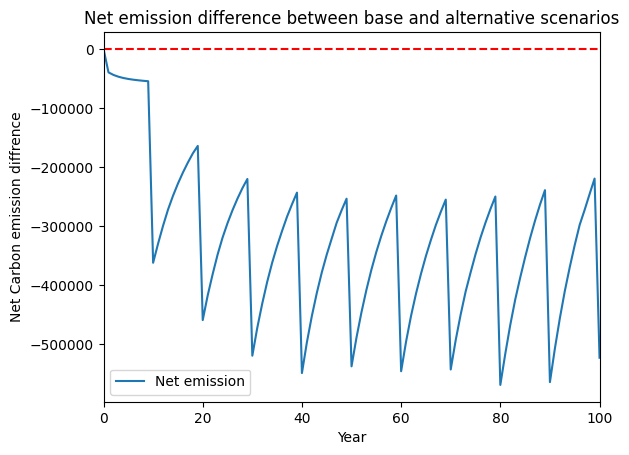

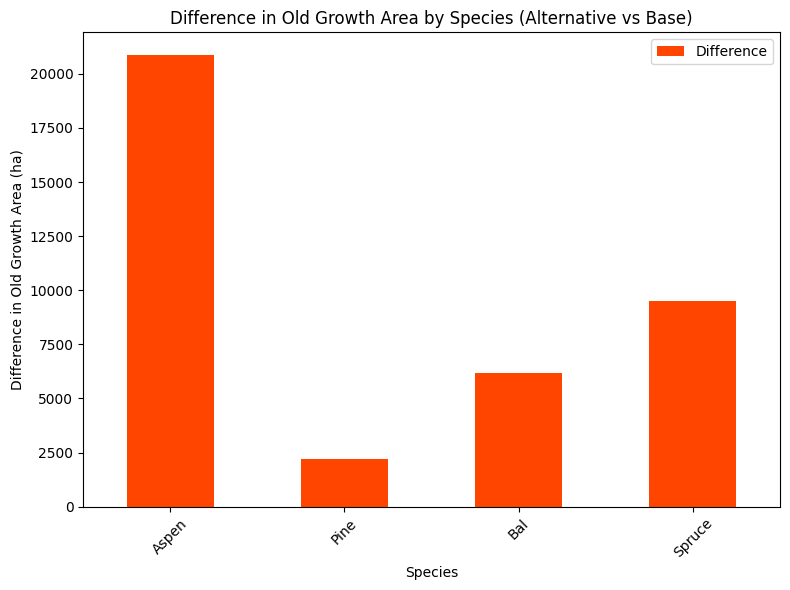

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_age_difference.pdf


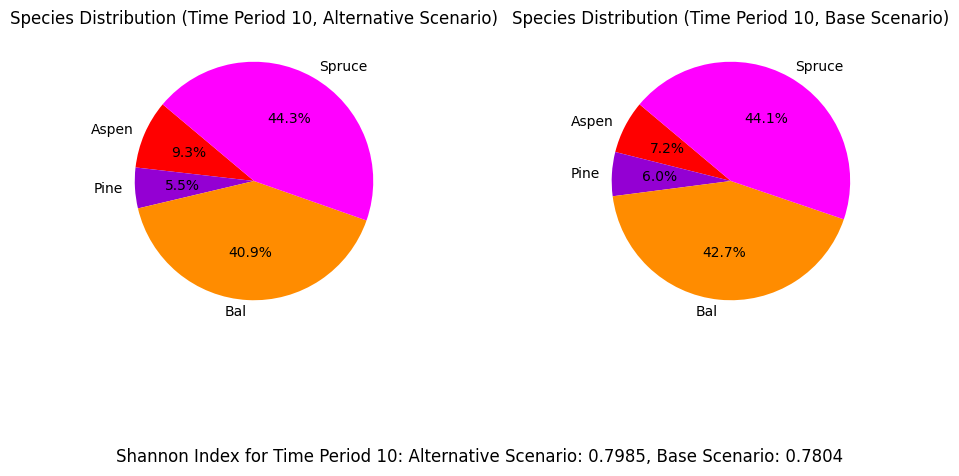

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/mining_site_3/mining_site_3_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 63.5 minutes to run all scenarios.


In [12]:
# Run all scenarios in a loop
Start = time.time()
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

In [13]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 63.5 minutes to run this script.
